In [1]:
from __future__ import annotations

import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from typing import Literal, Final, List, TypeVar, Dict, Tuple, Any, Optional, Iterable, Union, NoReturn
import sklearn
import os

from assignment2.a2_utils.seed_utils import *

import assignment2.a2_utils.misc_utils as misc_utils
import assignment2.a2_utils.metric_utils as metric_utils
import assignment2.a2_utils.dataframe_utils as df_utils
import assignment2.a2_utils.simple_learner_utils as slearner

import econml

import warnings
warnings.filterwarnings("ignore")


from sklearn.linear_model import ARDRegression, SGDRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn import set_config


set_config(display="diagram")




#sns.set_theme(style="darkgrid",context="paper")

import matplotlib.style
if "seaborn-darkgrid" in matplotlib.style.available:
    matplotlib.style.use("seaborn-darkgrid")

%matplotlib inline


import pickle

import dill

In [2]:
dataset: Literal["ihdp","jobs"] = "ihdp"

# Opening the IHDP dataset


In [3]:

ihdp_full: pd.DataFrame = df_utils.turn_01_columns_into_int(
    pd.read_csv(f"{dataset}_full.csv")
)
"The full IHDP dataset (with supplementary t0 and t1 info) as a dataframe"

ihdp_full.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x22,x23,x24,t,yf,ycf,ite,tcf,t0,t1
0,1.397395,0.996346,-1.105624,-0.879606,0.308569,-1.023402,1,0,0,0,...,0,0,1,1,4.771232,-0.298509,4.657928,0,-0.298509,4.771232
1,0.269033,0.196818,0.383828,0.161703,-0.629189,1.460832,1,0,1,0,...,0,0,0,0,2.956273,5.783770,3.428604,1,2.956273,5.783770
2,1.051537,1.795874,-1.105624,0.161703,-0.629189,0.963985,1,0,1,1,...,0,0,1,0,4.164164,7.055789,3.658195,1,4.164164,7.055789
3,0.662446,0.196818,-0.733261,-0.879606,0.371086,-0.692171,1,0,0,0,...,0,0,0,1,6.172307,1.379697,4.585505,0,1.379697,6.172307
4,0.856992,1.795874,0.011465,-0.879606,0.558638,0.301522,0,1,1,0,...,0,0,0,1,7.834469,2.747986,4.265591,0,2.747986,7.834469


In [4]:
ihdp_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 747 entries, 0 to 746
Data columns (total 32 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x0      747 non-null    float64
 1   x1      747 non-null    float64
 2   x2      747 non-null    float64
 3   x3      747 non-null    float64
 4   x4      747 non-null    float64
 5   x5      747 non-null    float64
 6   x6      747 non-null    uint8  
 7   x7      747 non-null    uint8  
 8   x8      747 non-null    uint8  
 9   x9      747 non-null    uint8  
 10  x10     747 non-null    uint8  
 11  x11     747 non-null    uint8  
 12  x12     747 non-null    uint8  
 13  x13     747 non-null    uint8  
 14  x14     747 non-null    uint8  
 15  x15     747 non-null    uint8  
 16  x16     747 non-null    uint8  
 17  x17     747 non-null    uint8  
 18  x18     747 non-null    uint8  
 19  x19     747 non-null    uint8  
 20  x20     747 non-null    uint8  
 21  x21     747 non-null    uint8  
 22  x2

In [5]:
dfm: df_utils.DataframeManager = df_utils.DataframeManager.make(
    dataset_name = dataset,
    the_df = ihdp_full,
    test_proportion = 0.1,
    split_randomstate = rng_state(),
    columns_for_training_stratification= ["t"],
    t_column = "t",
    t_cf_column = "tcf",
    y_column = "yf",
    e_column = "e",
    default_e_if_e_not_present = 1,
    ycf_column= "ycf",
    t0_column= "t0",
    t1_column = "t1",
    ite_column = "ite"
)


In [6]:
dfm.save_self()

pickling self as \ihdp\ihdp DataframeManager.pickle...
pickled!


True

# Part 3 - Simple Learners

In [7]:
%%time

rf_min_samples = [2,4,6]
rf_min_impurity_decrease =  [0, *np.geomspace(0.00001, 0.15,4)[1:]]
rf_max_features = [None,"sqrt","log2",0.5,2]
rf_ccp_alpha =  [0, *np.geomspace(0.00001, 0.15,4)[1:]]
rf_n_estimators = [50,100,150]

rf_simple_searched: List[
    slearner.SimpleHalvingGridSearchResults
] = slearner.simple_halving_grid_searcher(
    RandomForestRegressor(criterion="squared_error", random_state=seed()),
    {
        #"estimator__n_estimators": [75,100,125],
        "estimator__min_samples_split": rf_min_samples,
        "estimator__min_impurity_decrease": rf_min_impurity_decrease,
        "estimator__max_features": rf_max_features,
        # "estimator__oob_score": [False, True],
        "estimator__ccp_alpha":  rf_ccp_alpha
    },
    df_m=dfm,
    df_selection=df_utils.DatasetEnum.FACTUAL,
    learner_name="Random Forest simple",
    kfold_splits=10,
    scorer_to_use=slearner.r2_score_id(),
    stratify_on=["t"],
    resource="estimator__n_estimators",
    resource_param_values=rf_n_estimators,
    #classes_ndarray=ihdp_learn_df_x["t"].to_numpy()
)


-- 10-fold attempt 1/3 start --
max: 50, min: 7, factor: 8
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 1
min_resources_: 7
max_resources_: 50
aggressive_elimination: True
factor: 8
----------
iter: 0
n_candidates: 240
n_resources: 7
Fitting 10 folds for each of 240 candidates, totalling 2400 fits
----------
iter: 1
n_candidates: 30
n_resources: 7
Fitting 10 folds for each of 30 candidates, totalling 300 fits
----------
iter: 2
n_candidates: 4
n_resources: 7
Fitting 10 folds for each of 4 candidates, totalling 40 fits
best from this iteration: 
GridSearchResults summary Random Forest simple ihdp
	test score:	0.644123234074506
	train score:0.7564297983880856
	yf score:	0.8535078650166091
	ycf score:	0.6955739988398464
	t0 score:	0.6905341325181477
	t1 score:	0.09377904968056439
	ite score:	0.516677388593185
	abs ATE:	0.04530629291874799
	PEHE:   	0.5973004893576587
	abs ATT:	0.09430517492174406
	p. risk:	-5.473185188281667

--- 1/3 END ---
-- 10-fold attempt 2/3 start

In [8]:

rf_simple_best: slearner.SimpleHalvingGridSearchResults = max(
    rf_simple_searched
)


In [9]:

print(rf_simple_best.info)



rf_simple_best.best_estimator_


GridSearchResults summary Random Forest simple ihdp
	test score:	0.7025444813007882
	train score:0.7283555982472381
	yf score:	0.7395090031744529
	ycf score:	0.6812144871945791
	t0 score:	0.5015229296143691
	t1 score:	-0.0017911736391860167
	ite score:	0.6985193472979756
	abs ATE:	0.04366266896597448
	PEHE:   	0.4717414496808599
	abs ATT:	0.11724985825270862
	p. risk:	-5.491525000452395
	best params:
		estimator__ccp_alpha : 0.000246621207433047
		estimator__max_features : None
		estimator__min_impurity_decrease : 0.15
		estimator__min_samples_split : 4
		estimator__n_estimators : 100


PPipeline(steps=[('scaler', QuantileTransformer(output_distribution='normal')),
                 ('imputer', KNNImputer(weights='distance')),
                 ('estimator',
                  RandomForestRegressor(ccp_alpha=0.000246621207433047,
                                        max_features=None,
                                        min_impurity_decrease=0.15,
                                        min_samples_split=4,
                                        random_state=42))])

In [10]:
rf_simple_best.save_me()

Pickling results to: \ihdp\ihdp Random Forest simple results.pickle
pickled results!
Pickling simple estimator to \ihdp\ihdp Random Forest simple estimator.pickle
pickled estimator!


Exporting feature importance graph to \ihdp\ihdp Random Forest simple feature importances.pdf


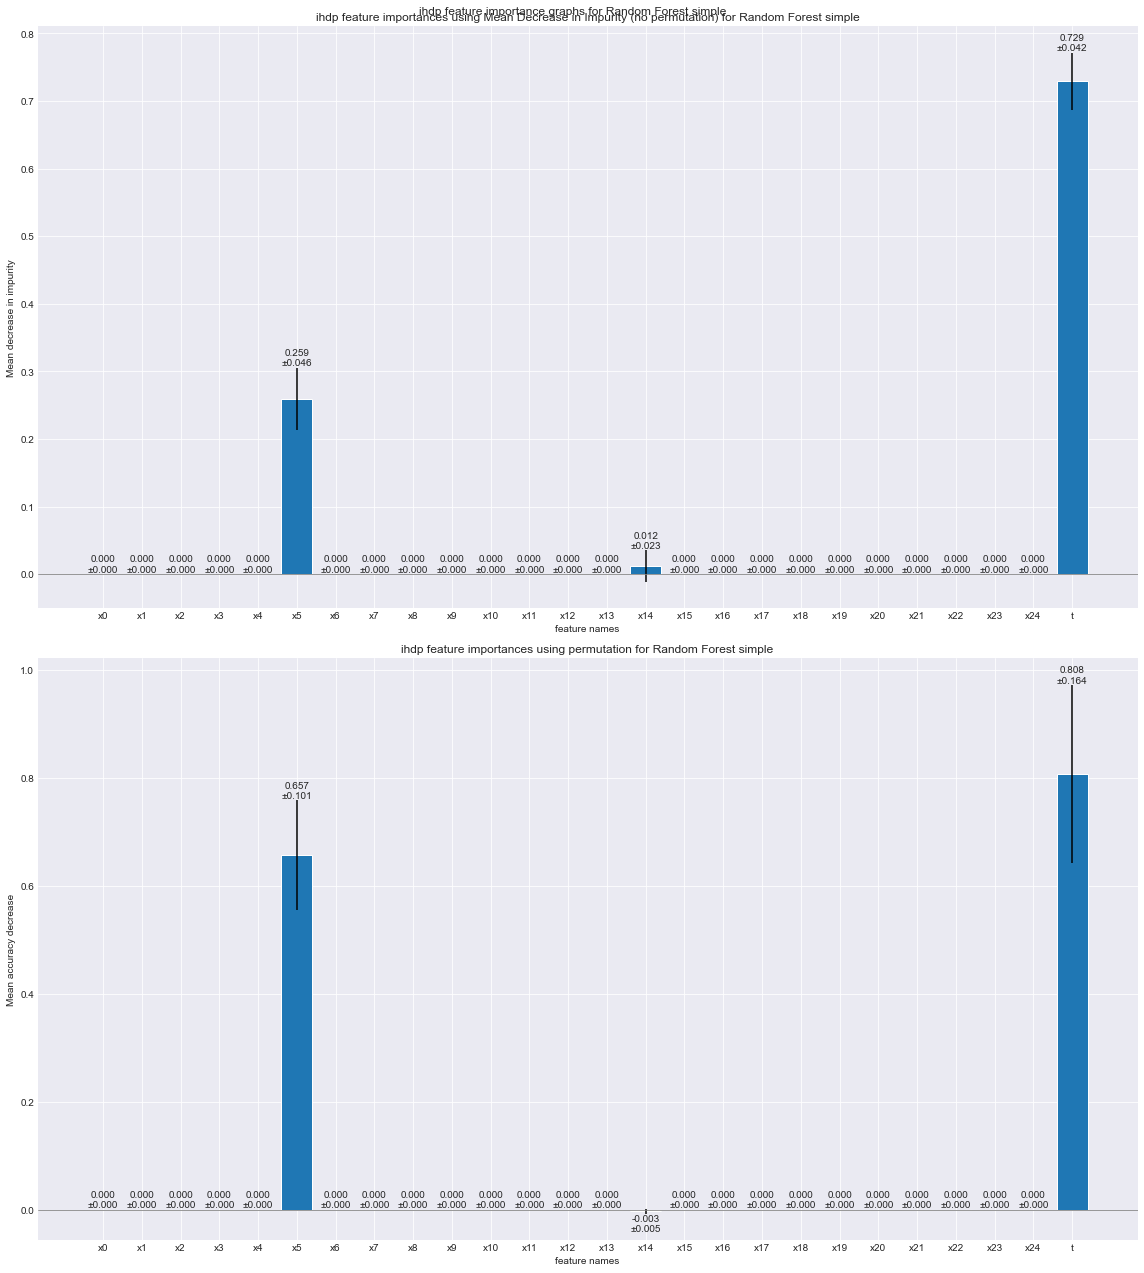

In [11]:
rf_simple_best.importance_plotter().show()

Permutation explainer: 76it [00:39,  1.60it/s]                        


Saving SHAP figure to ihdp\ihdp SHAP values for Random Forest simple.pdf...


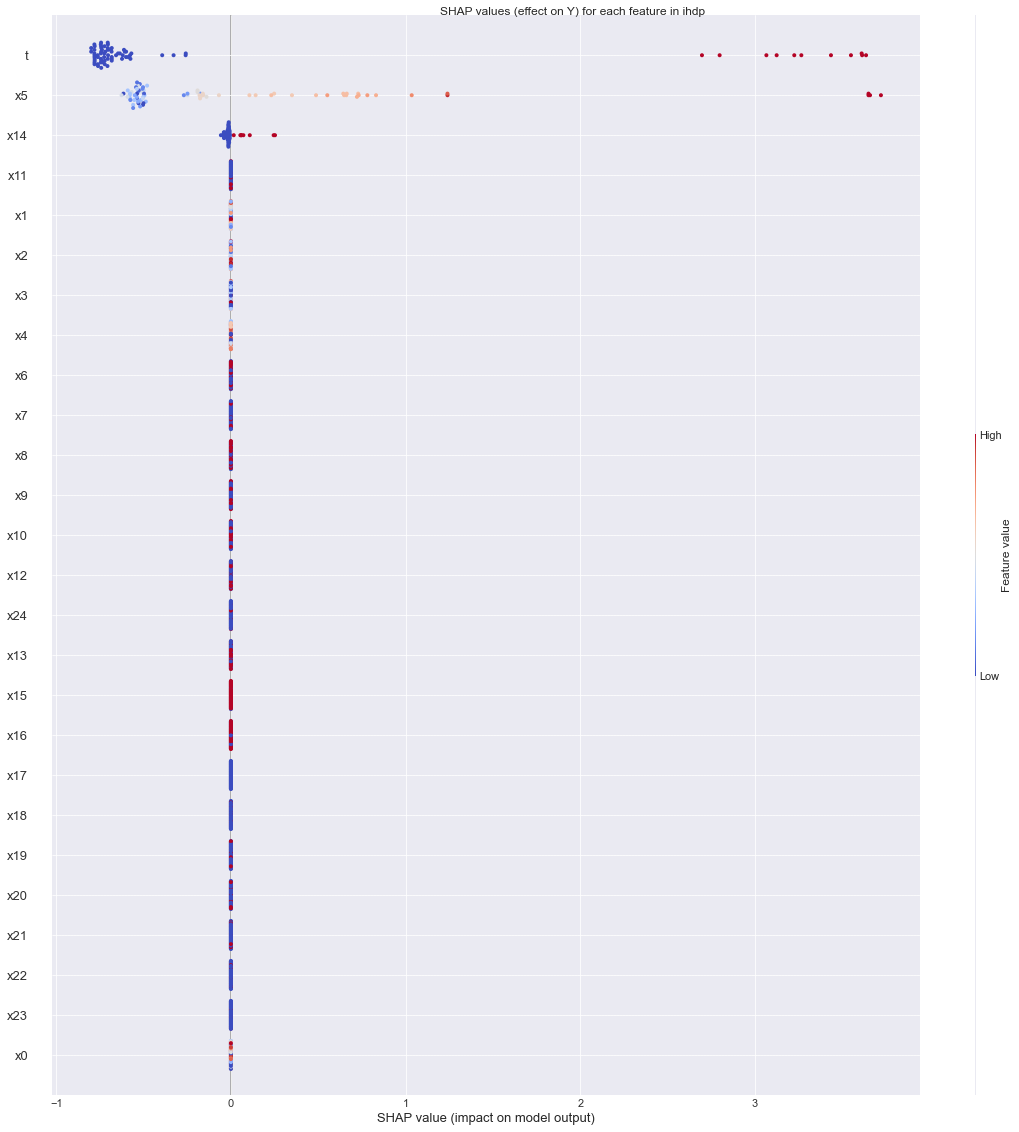

In [12]:
rf_simple_best.shap_importance_plotter().show()

In [13]:
%%time

ard_iter: List[int] = [200, 250, 300]
ard_tol: List[float] = [1e-2, 1e-3, 1e-4]
ard_alpha_lambda: List[float] = [1e-5, 1e-6, 1e-7]
ard_thresh_lambda: List[float] = [1e3, 1e4, 1e5]



ard_simple_searched: List[
    slearner.SimpleHalvingGridSearchResults
] = slearner.simple_halving_grid_searcher(
    ARDRegression(),
    {
        #"regressor__n_iter": ard_iter,
        "estimator__tol": ard_tol,
        "estimator__alpha_1" : ard_alpha_lambda,
        "estimator__alpha_2" : ard_alpha_lambda,
        "estimator__lambda_1" : ard_alpha_lambda,
        "estimator__lambda_2" : ard_alpha_lambda,
        "estimator__threshold_lambda": ard_thresh_lambda
    },
    df_m=dfm,
    df_selection=df_utils.DatasetEnum.FACTUAL,
    learner_name="ARD simple",
    kfold_splits=10,
    scorer_to_use=slearner.r2_score_id(),
    stratify_on=["t"],
    resource="estimator__n_iter",
    resource_param_values=ard_iter
)

-- 10-fold attempt 1/3 start --
max: 200, min: 14, factor: 15
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 1
min_resources_: 14
max_resources_: 200
aggressive_elimination: True
factor: 15
----------
iter: 0
n_candidates: 729
n_resources: 14
Fitting 10 folds for each of 729 candidates, totalling 7290 fits
----------
iter: 1
n_candidates: 49
n_resources: 14
Fitting 10 folds for each of 49 candidates, totalling 490 fits
----------
iter: 2
n_candidates: 4
n_resources: 14
Fitting 10 folds for each of 4 candidates, totalling 40 fits
best from this iteration: 
GridSearchResults summary ARD simple ihdp
	test score:	0.5564596977895747
	train score:0.7174340703816985
	yf score:	0.7230858128688201
	ycf score:	0.6696308622344906
	t0 score:	0.49420677538586866
	t1 score:	-0.0880853724951618
	ite score:	-0.0008744474291235704
	abs ATE:	0.02540628505630016
	PEHE:   	0.8595360866486239
	abs ATT:	0.10410522166326874
	p. risk:	-5.4930213795885985

--- 1/3 END ---
-- 10-fold attempt 2/

In [14]:

ard_simple_best: slearner.SimpleHalvingGridSearchResults = max(
    ard_simple_searched
)




In [15]:

print(ard_simple_best.info)


ard_simple_best.best_estimator_


GridSearchResults summary ARD simple ihdp
	test score:	0.5564596977895747
	train score:0.7174340703816985
	yf score:	0.7230858128688201
	ycf score:	0.6696308622344906
	t0 score:	0.49420677538586866
	t1 score:	-0.0880853724951618
	ite score:	-0.0008744474291235704
	abs ATE:	0.02540628505630016
	PEHE:   	0.8595360866486239
	abs ATT:	0.10410522166326874
	p. risk:	-5.4930213795885985
	best params:
		estimator__alpha_1 : 1e-07
		estimator__alpha_2 : 1e-05
		estimator__lambda_1 : 1e-05
		estimator__lambda_2 : 1e-05
		estimator__threshold_lambda : 10000.0
		estimator__tol : 0.01
		estimator__n_iter : 14


PPipeline(steps=[('scaler', QuantileTransformer(output_distribution='normal')),
                 ('imputer', KNNImputer(weights='distance')),
                 ('estimator',
                  ARDRegression(alpha_1=1e-07, alpha_2=1e-05, lambda_1=1e-05,
                                lambda_2=1e-05, n_iter=14, tol=0.01))])

In [16]:
ard_simple_best.save_me()

Pickling results to: \ihdp\ihdp ARD simple results.pickle
pickled results!
Pickling simple estimator to \ihdp\ihdp ARD simple estimator.pickle
pickled estimator!


Exporting feature importance graph to \ihdp\ihdp ARD simple feature importances.pdf


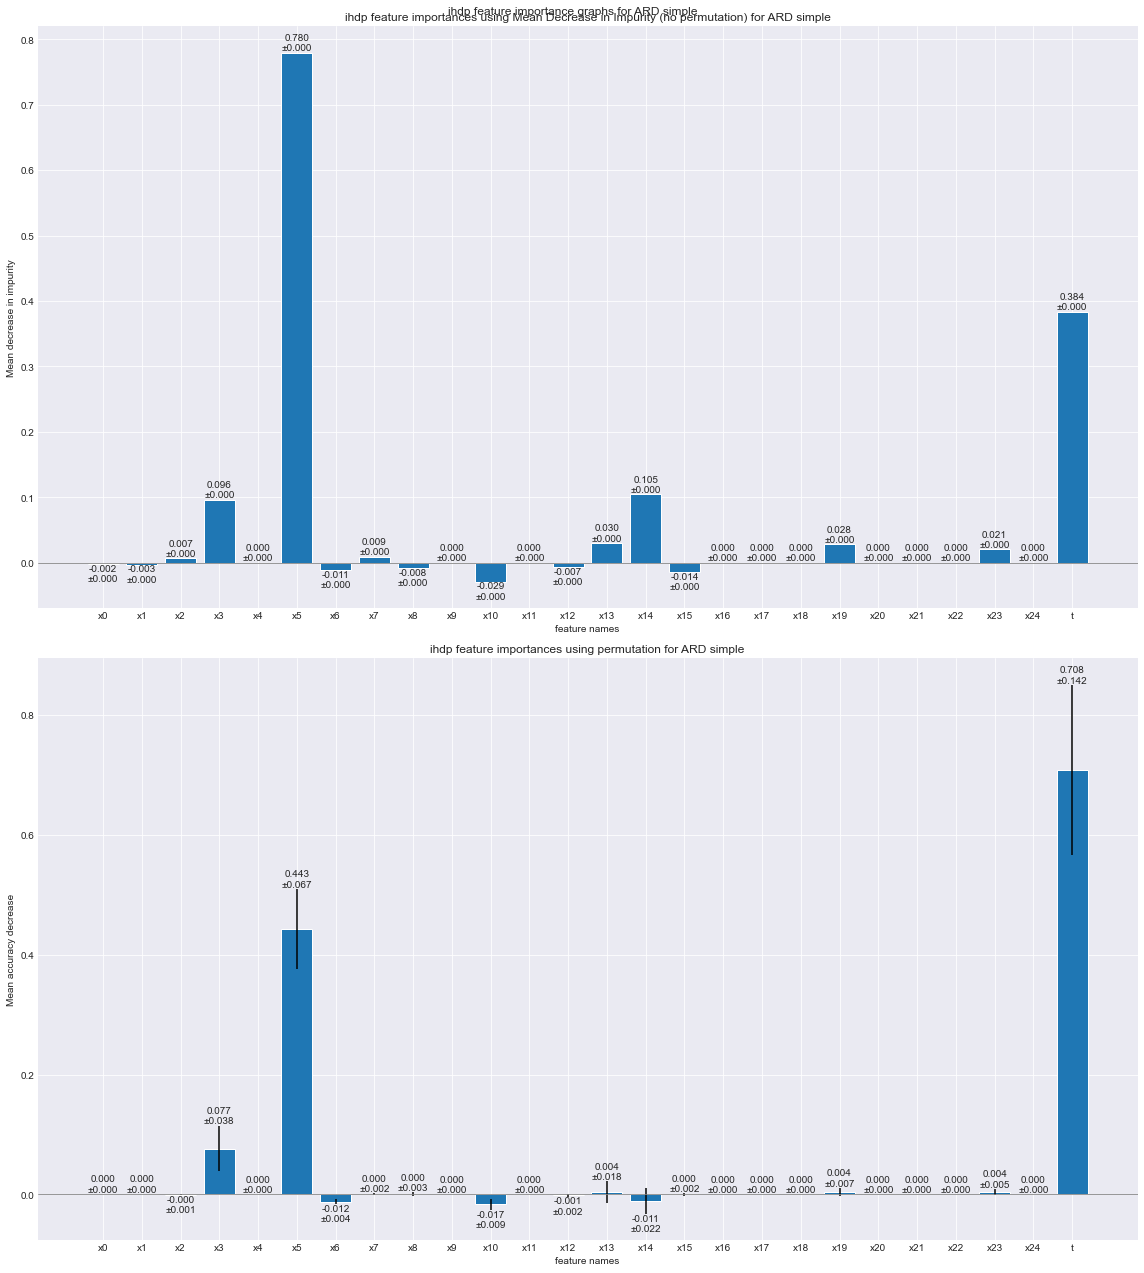

In [17]:
ard_simple_best.importance_plotter().show()

Permutation explainer: 76it [00:17,  1.89it/s]                        


Saving SHAP figure to ihdp\ihdp SHAP values for ARD simple.pdf...


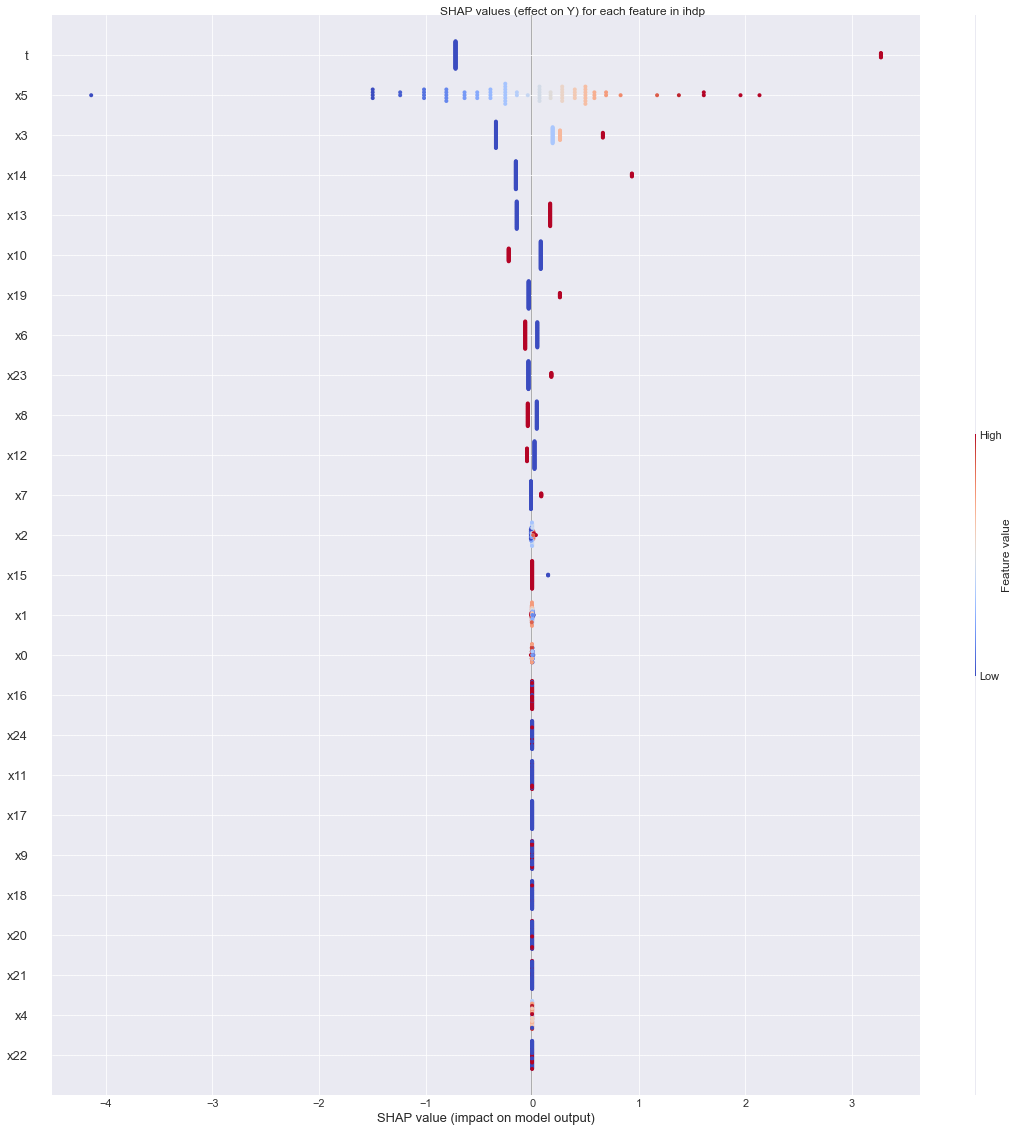

In [18]:
ard_simple_best.shap_importance_plotter().show()

In [19]:
%%time

sgd_max_iter: List[int] = [500,1000,1500]
sgd_alpha: List[float] = [0.001, 0.0001, 0.00001]
sgd_learning_rate: List[str] =  ["constant","optimal","invscaling","adaptive"]
sgd_power_t: List[float] = [0.25,0.5,0.75]
sgd_l1_ratio: List[float] = [0, 0.5, 1]


sgd_simple_searched: List[
    slearner.SimpleHalvingGridSearchResults
] = slearner.simple_halving_grid_searcher(
    SGDRegressor(
        random_state=seed(),
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=5,
        penalty="elasticnet"
    ),
    {
        #"regressor__n_iter": ard_iter,
        "estimator__alpha": sgd_alpha,
        "estimator__power_t": sgd_power_t,
        "estimator__learning_rate": sgd_learning_rate,
        "estimator__l1_ratio": sgd_l1_ratio
    },
    df_m=dfm,
    df_selection=df_utils.DatasetEnum.FACTUAL,
    learner_name="sgd simple",
    kfold_splits=10,
    scorer_to_use=slearner.r2_score_id(),
    stratify_on=["t"],
    resource="estimator__max_iter",
    resource_param_values=sgd_max_iter
)

-- 10-fold attempt 1/3 start --
max: 500, min: 22, factor: 23
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 1
min_resources_: 22
max_resources_: 500
aggressive_elimination: True
factor: 23
----------
iter: 0
n_candidates: 108
n_resources: 22
Fitting 10 folds for each of 108 candidates, totalling 1080 fits
----------
iter: 1
n_candidates: 5
n_resources: 22
Fitting 10 folds for each of 5 candidates, totalling 50 fits
best from this iteration: 
GridSearchResults summary sgd simple ihdp
	test score:	0.4425780268844929
	train score:0.6269645946519098
	yf score:	0.6427940441859836
	ycf score:	0.5531127392764995
	t0 score:	0.3320840758703357
	t1 score:	-0.4380164106561475
	ite score:	-0.03812289984639472
	abs ATE:	0.1677518344022335
	PEHE:   	0.8753841915845768
	abs ATT:	0.2949318616657459
	p. risk:	-5.323169480673895

--- 1/3 END ---
-- 10-fold attempt 2/3 start --
max: 1000, min: 32, factor: 32
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 1
min_resources

In [20]:

sgd_simple_best: slearner.SimpleHalvingGridSearchResults = max(
    sgd_simple_searched
)



In [21]:

print(sgd_simple_best.info)

sgd_simple_best.best_estimator_


GridSearchResults summary sgd simple ihdp
	test score:	0.4425780268844929
	train score:0.6269645946519098
	yf score:	0.6427940441859836
	ycf score:	0.5531127392764995
	t0 score:	0.3320840758703357
	t1 score:	-0.4380164106561475
	ite score:	-0.03812289984639472
	abs ATE:	0.1677518344022335
	PEHE:   	0.8753841915845768
	abs ATT:	0.2949318616657459
	p. risk:	-5.323169480673895
	best params:
		estimator__alpha : 0.001
		estimator__l1_ratio : 1
		estimator__learning_rate : invscaling
		estimator__power_t : 0.5
		estimator__max_iter : 22


PPipeline(steps=[('scaler', QuantileTransformer(output_distribution='normal')),
                 ('imputer', KNNImputer(weights='distance')),
                 ('estimator',
                  SGDRegressor(alpha=0.001, early_stopping=True, l1_ratio=1,
                               max_iter=22, penalty='elasticnet', power_t=0.5,
                               random_state=42))])

In [22]:
sgd_simple_best.save_me()

Pickling results to: \ihdp\ihdp sgd simple results.pickle
pickled results!
Pickling simple estimator to \ihdp\ihdp sgd simple estimator.pickle
pickled estimator!


Exporting feature importance graph to \ihdp\ihdp sgd simple feature importances.pdf


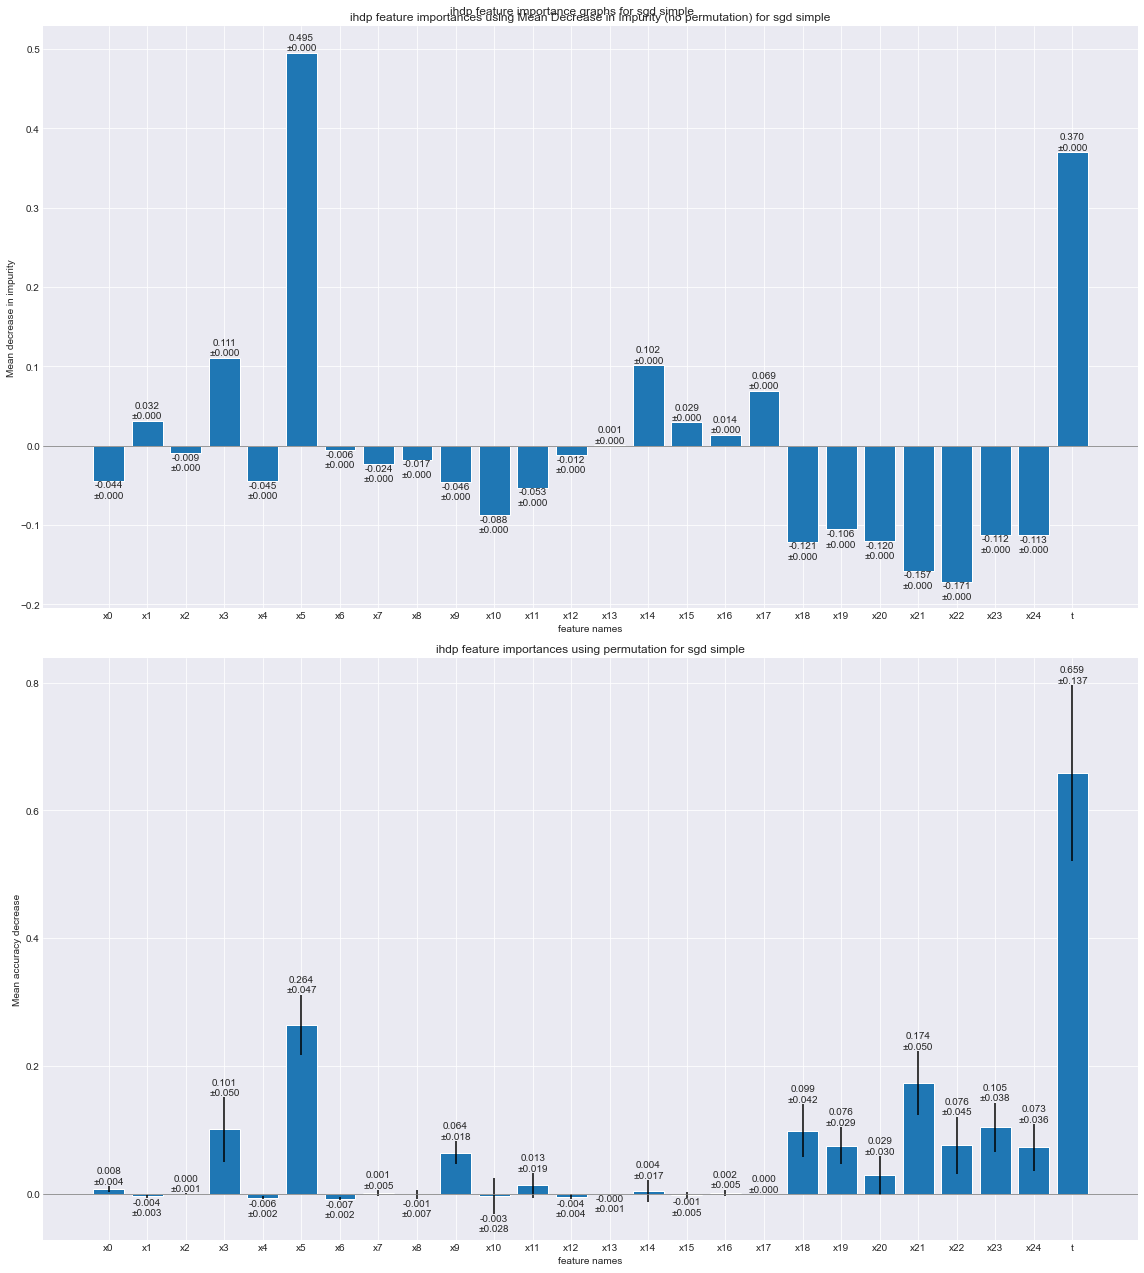

In [23]:
sgd_simple_best.importance_plotter().show()

Permutation explainer: 76it [00:21,  1.94it/s]                        


Saving SHAP figure to ihdp\ihdp SHAP values for sgd simple.pdf...


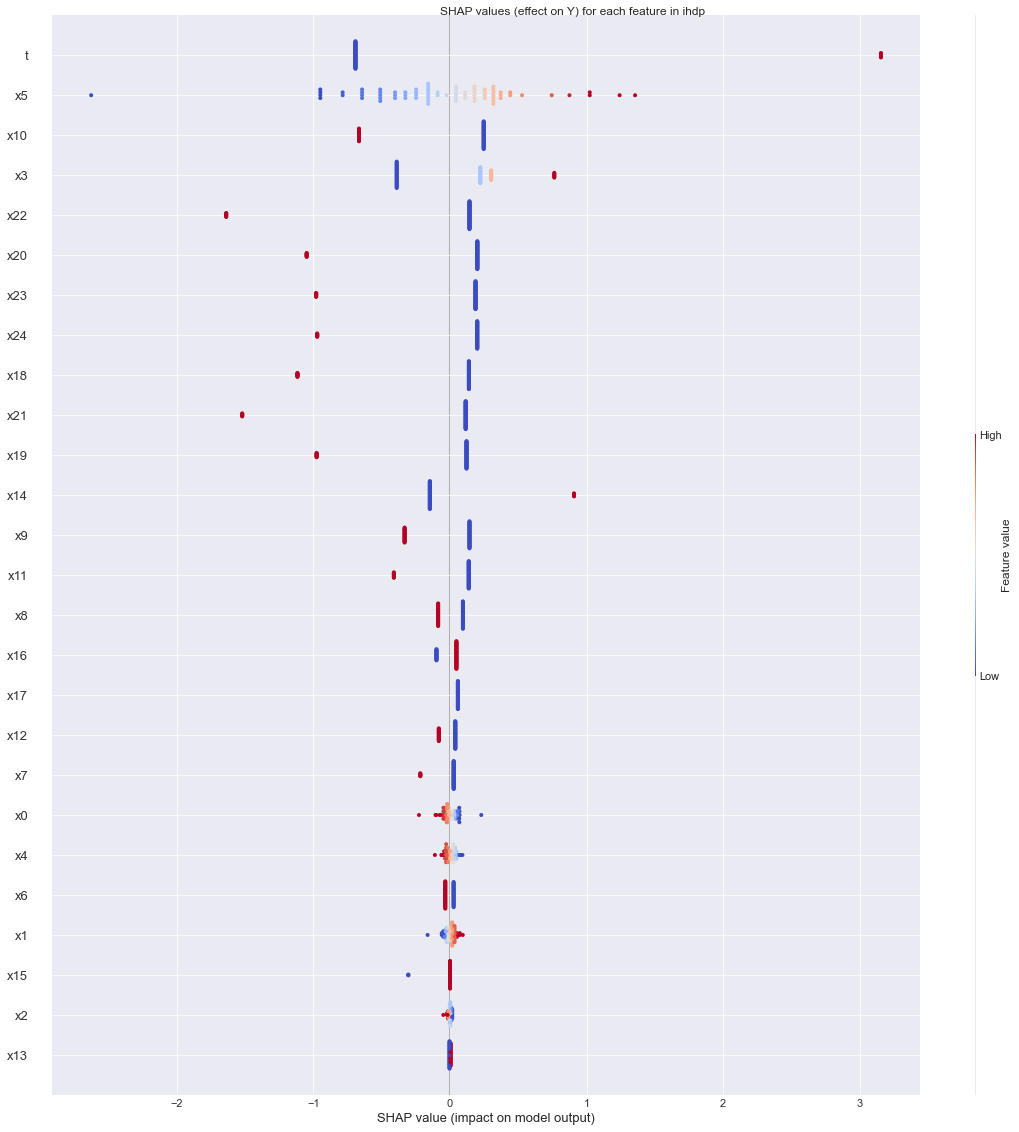

In [24]:
sgd_simple_best.shap_importance_plotter().show()

In [25]:
%%time

adaboost_estimators: List[int] = [25, 50, 75]
adaboost_learn_rate: List[float] = [0.8, 1.0, 1.2]
adaboost_loss: List[str]= ["linear", "square", "exponential"]

ada_rf_simple_searched: List[
    slearner.SimpleHalvingGridSearchResults
] = slearner.simple_halving_grid_searcher(
    AdaBoostRegressor(
        random_state = seed()
    ),
    {
        #"regressor__base_estimator": [
        #    Pipeline(
        #        steps = [i for i in rf.best_estimator_.named_steps.items()]
        #    ) for rf in random_forest_searched_dict.keys()
        #],
        #"regressor__n_estimators": adaboost_estimators,
        "estimator__learning_rate": adaboost_learn_rate,
        "estimator__loss": adaboost_loss,
        "estimator__base_estimator": [
            *[pl.clone_best_final_estimator for pl in rf_simple_searched],
            RandomForestRegressor(random_state=seed()),
            RandomForestRegressor(random_state=seed(), max_depth=10),
            DecisionTreeRegressor(random_state=seed()),
            DecisionTreeRegressor(random_state=seed(), max_depth=10)
        ]
    },
    df_m=dfm,
    df_selection=df_utils.DatasetEnum.FACTUAL,
    learner_name="Adaboost Random Forest simple",
    kfold_splits=10,
    scorer_to_use=slearner.r2_score_id(),
    stratify_on=["t"],
    resource="estimator__n_estimators",
    resource_param_values=adaboost_estimators,
)

-- 10-fold attempt 1/3 start --
max: 25, min: 1, factor: 5
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 1
max_resources_: 25
aggressive_elimination: True
factor: 5
----------
iter: 0
n_candidates: 63
n_resources: 1
Fitting 10 folds for each of 63 candidates, totalling 630 fits
----------
iter: 1
n_candidates: 13
n_resources: 5
Fitting 10 folds for each of 13 candidates, totalling 130 fits
----------
iter: 2
n_candidates: 3
n_resources: 25
Fitting 10 folds for each of 3 candidates, totalling 30 fits
best from this iteration: 
GridSearchResults summary Adaboost Random Forest simple ihdp
	test score:	0.6451151456399878
	train score:0.7647881231497995
	yf score:	0.9331340121563024
	ycf score:	0.6809523159575235
	t0 score:	0.8111136160660275
	t1 score:	0.10497306121133942
	ite score:	0.04569268384567937
	abs ATE:	0.05910762227097255
	PEHE:   	0.8393023527994102
	abs ATT:	0.053589010912391544
	p. risk:	-5.443254773257158

--- 1/3 END ---
-- 10-fold attemp

In [26]:

ada_rf_simple_best: slearner.SimpleHalvingGridSearchResults = max(
    ada_rf_simple_searched
)



In [27]:

print(ada_rf_simple_best.info)



ada_rf_simple_best.best_estimator_


GridSearchResults summary Adaboost Random Forest simple ihdp
	test score:	0.6874527684187223
	train score:0.7717375370449718
	yf score:	0.7949866672400211
	ycf score:	0.6874438521286699
	t0 score:	0.6006350067021621
	t1 score:	0.027300132322316095
	ite score:	0.5947668249136354
	abs ATE:	0.011366591926843306
	PEHE:   	0.5469237842457962
	abs ATT:	0.10211627901466658
	p. risk:	-5.466444278879323
	best params:
		estimator__base_estimator : RandomForestRegressor(ccp_alpha=0.000246621207433047, max_features=None,
                      min_impurity_decrease=0.15, min_samples_split=4,
                      random_state=42)
		estimator__learning_rate : 0.8
		estimator__loss : square
		estimator__n_estimators : 9


PPipeline(steps=[('scaler', QuantileTransformer(output_distribution='normal')),
                 ('imputer', KNNImputer(weights='distance')),
                 ('estimator',
                  AdaBoostRegressor(base_estimator=RandomForestRegressor(ccp_alpha=0.000246621207433047,
                                                                         max_features=None,
                                                                         min_impurity_decrease=0.15,
                                                                         min_samples_split=4,
                                                                         random_state=42),
                                    learning_rate=0.8, loss='square',
                                    n_estimators=9, random_state=42))])

In [28]:
ada_rf_simple_best.save_me()

Pickling results to: \ihdp\ihdp Adaboost Random Forest simple results.pickle
pickled results!
Pickling simple estimator to \ihdp\ihdp Adaboost Random Forest simple estimator.pickle
pickled estimator!


Exporting feature importance graph to \ihdp\ihdp Adaboost Random Forest simple feature importances.pdf


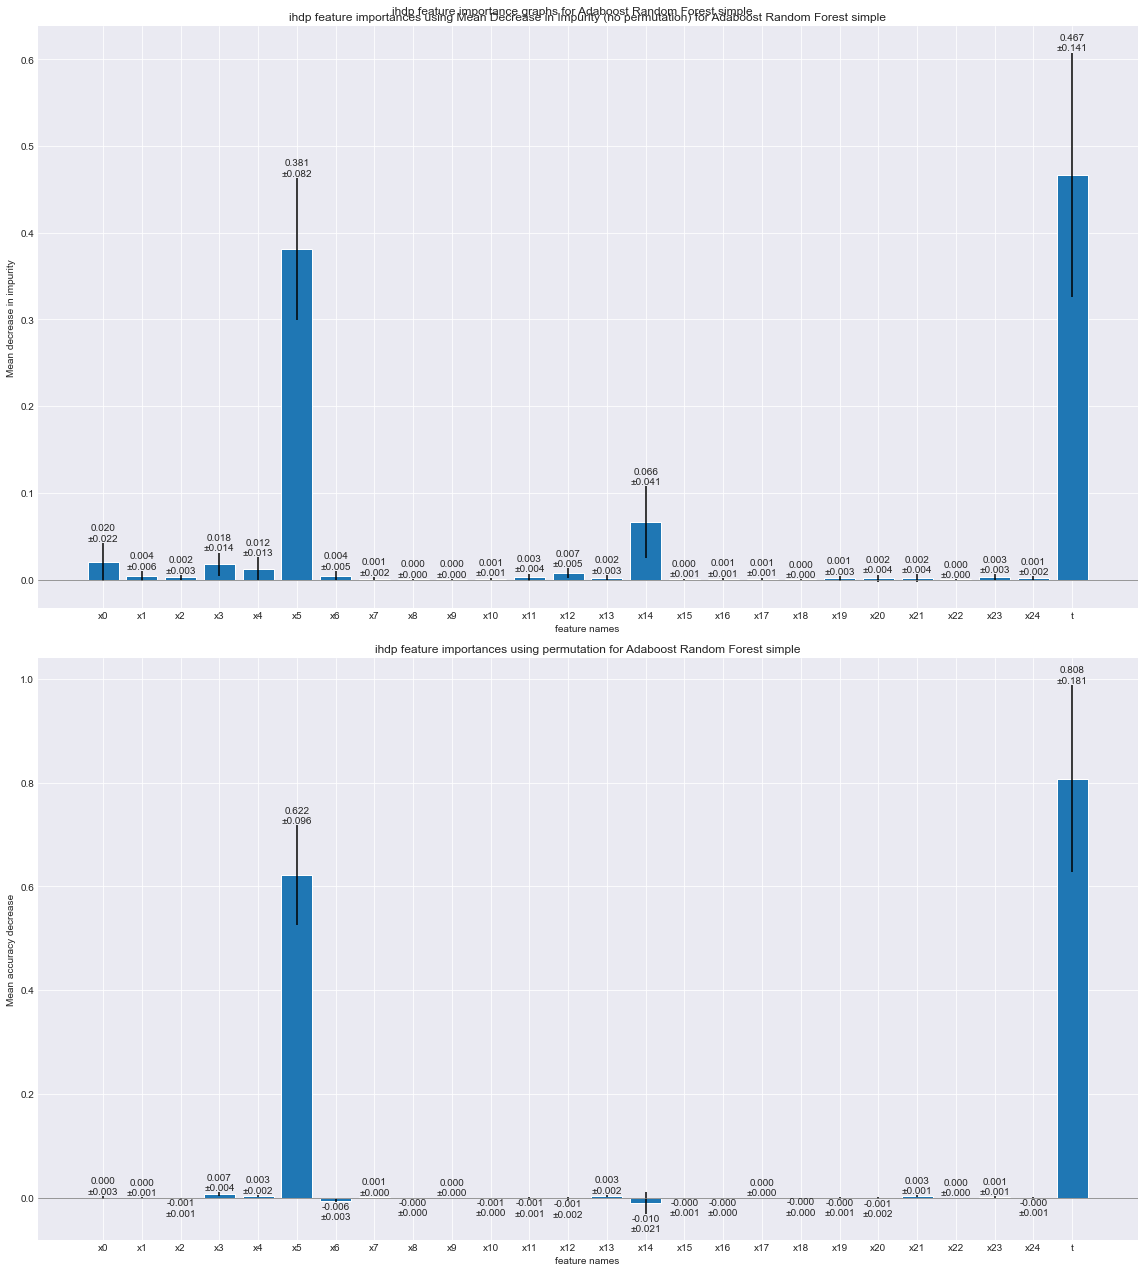

In [29]:
ada_rf_simple_best.importance_plotter().show()

Permutation explainer: 76it [01:55,  1.68s/it]                        


Saving SHAP figure to ihdp\ihdp SHAP values for Adaboost Random Forest simple.pdf...


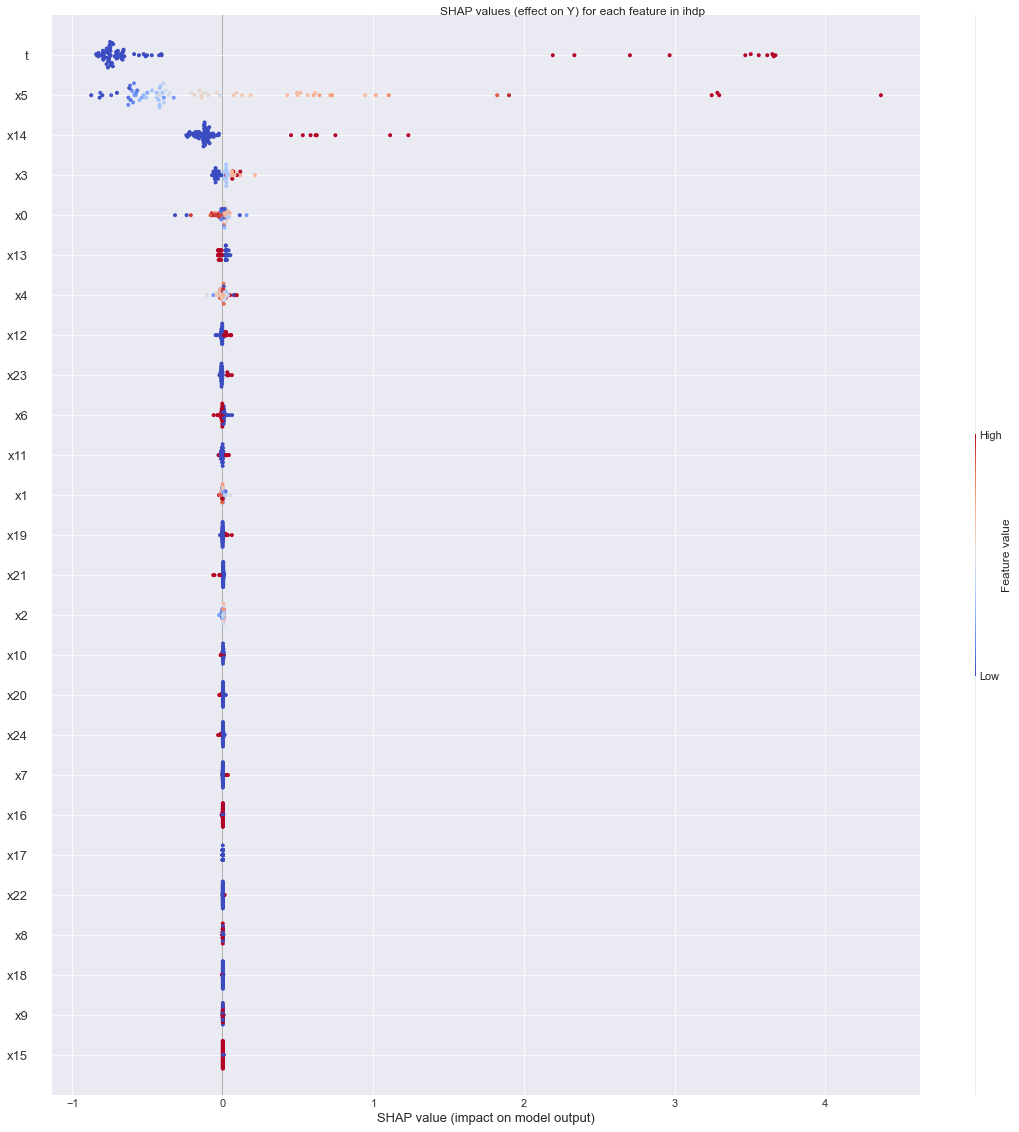

In [30]:
ada_rf_simple_best.shap_importance_plotter().show()

In [31]:
%%time

ada_ard_simple_searched: List[
    slearner.SimpleHalvingGridSearchResults
] = slearner.simple_halving_grid_searcher(
    AdaBoostRegressor(
        random_state=seed()
    ),
    {
        #"regressor__base_estimator": [
        #    Pipeline(
        #        steps = [i for i in ard.best_estimator_.named_steps.items()]
        #    ) for ard in ard_searched_dict.keys()
        #],
        #"regressor__n_estimators": adaboost_estimators,
        "estimator__learning_rate": adaboost_learn_rate,
        "estimator__loss": adaboost_loss,
        "estimator__base_estimator": [
            est for est in
            misc_utils.chain_1(
                [pl.clone_best_final_estimator for pl in ard_simple_searched],
                ARDRegression()
            )
        ]
    },
    df_m=dfm,
    df_selection=df_utils.DatasetEnum.FACTUAL,
    learner_name="Adaboost ARD simple",
    kfold_splits=10,
    scorer_to_use=slearner.r2_score_id(),
    stratify_on=["t"],
    resource="estimator__n_estimators",
    resource_param_values=adaboost_estimators,
)



-- 10-fold attempt 1/3 start --
max: 25, min: 1, factor: 5
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 1
max_resources_: 25
aggressive_elimination: True
factor: 5
----------
iter: 0
n_candidates: 36
n_resources: 1
Fitting 10 folds for each of 36 candidates, totalling 360 fits
----------
iter: 1
n_candidates: 8
n_resources: 5
Fitting 10 folds for each of 8 candidates, totalling 80 fits
----------
iter: 2
n_candidates: 2
n_resources: 25
Fitting 10 folds for each of 2 candidates, totalling 20 fits
best from this iteration: 
GridSearchResults summary Adaboost ARD simple ihdp
	test score:	0.4814613271155289
	train score:0.6964417538154005
	yf score:	0.70466583841806
	ycf score:	0.6469547945746504
	t0 score:	0.4620027411114326
	t1 score:	-0.16574902731910512
	ite score:	-0.037712912703367074
	abs ATE:	0.18672155290622738
	PEHE:   	0.8752113162411824
	abs ATT:	0.1286802065044652
	p. risk:	-5.480629855536226

--- 1/3 END ---
-- 10-fold attempt 2/3 start --

In [32]:

ada_ard_simple_best: slearner.SimpleHalvingGridSearchResults = max(
    ada_ard_simple_searched
)




In [33]:


print(ada_ard_simple_best.info)


ada_ard_simple_best.best_estimator_


GridSearchResults summary Adaboost ARD simple ihdp
	test score:	0.5147180305005219
	train score:0.701508411526615
	yf score:	0.7120585292818122
	ycf score:	0.653687495779796
	t0 score:	0.4743743489776976
	t1 score:	-0.14106293812460202
	ite score:	-0.002860800794475704
	abs ATE:	0.13230236928118666
	PEHE:   	0.8603885892460817
	abs ATT:	0.08370587304708721
	p. risk:	-5.490895910226953
	best params:
		estimator__base_estimator : ARDRegression(alpha_1=1e-07, alpha_2=1e-05, lambda_1=1e-05, lambda_2=1e-05,
              n_iter=14, tol=0.01)
		estimator__learning_rate : 0.8
		estimator__loss : linear
		estimator__n_estimators : 9


PPipeline(steps=[('scaler', QuantileTransformer(output_distribution='normal')),
                 ('imputer', KNNImputer(weights='distance')),
                 ('estimator',
                  AdaBoostRegressor(base_estimator=ARDRegression(alpha_1=1e-07,
                                                                 alpha_2=1e-05,
                                                                 lambda_1=1e-05,
                                                                 lambda_2=1e-05,
                                                                 n_iter=14,
                                                                 tol=0.01),
                                    learning_rate=0.8, n_estimators=9,
                                    random_state=42))])

In [34]:
ada_ard_simple_best.save_me()

Pickling results to: \ihdp\ihdp Adaboost ARD simple results.pickle
pickled results!
Pickling simple estimator to \ihdp\ihdp Adaboost ARD simple estimator.pickle
pickled estimator!


Exporting feature importance graph to \ihdp\ihdp Adaboost ARD simple feature importances.pdf


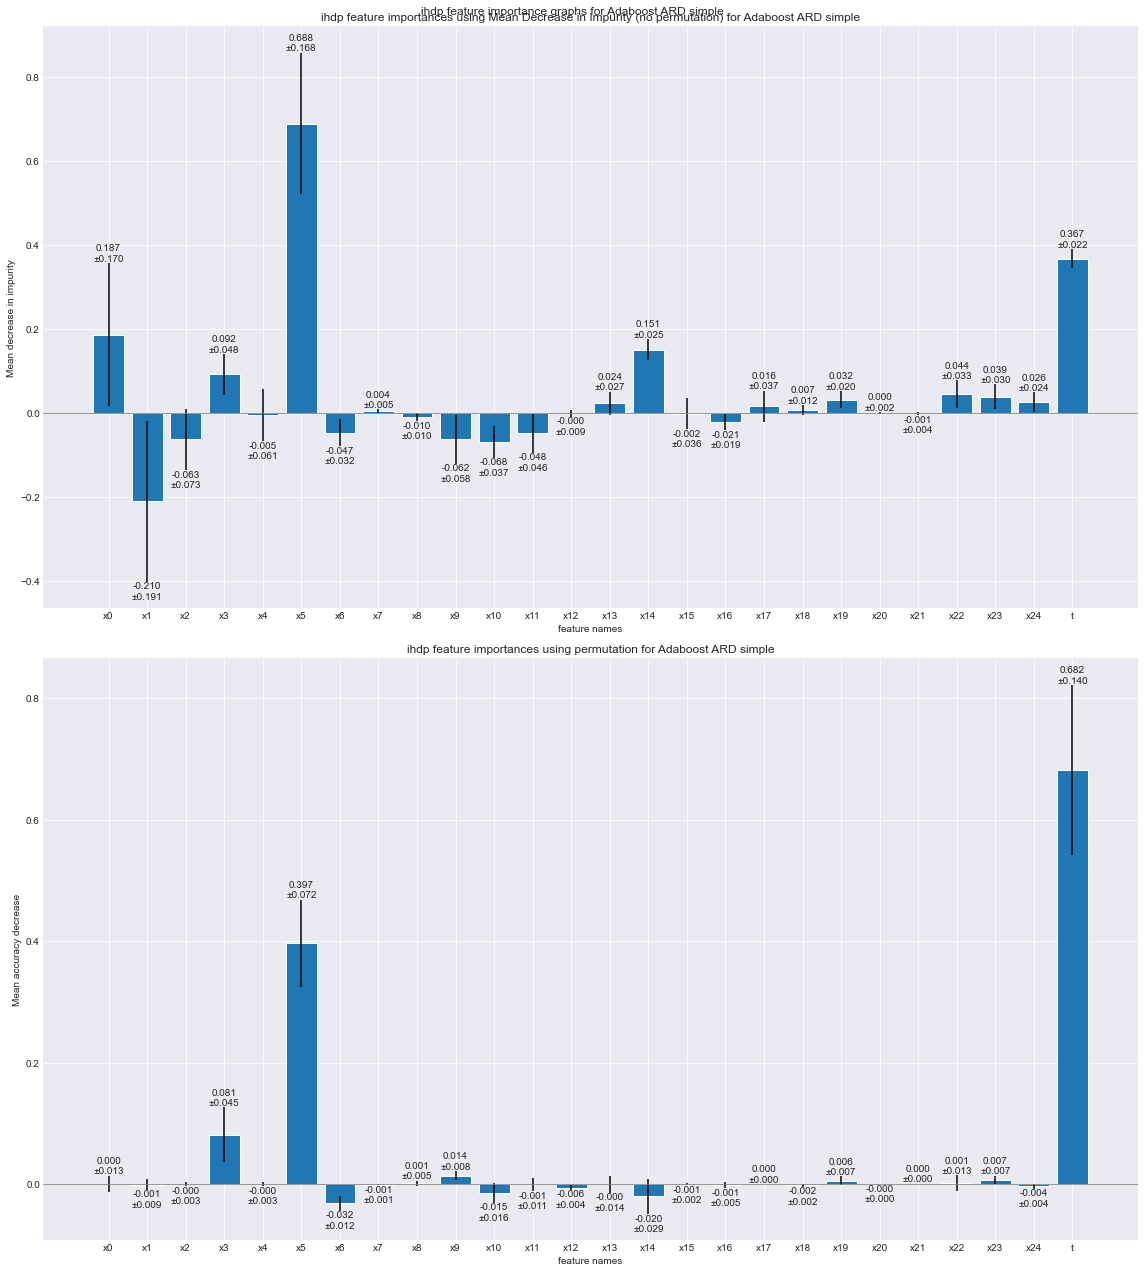

In [35]:
ada_ard_simple_best.importance_plotter().show()

Permutation explainer: 76it [00:19,  1.95it/s]                        


Saving SHAP figure to ihdp\ihdp SHAP values for Adaboost ARD simple.pdf...


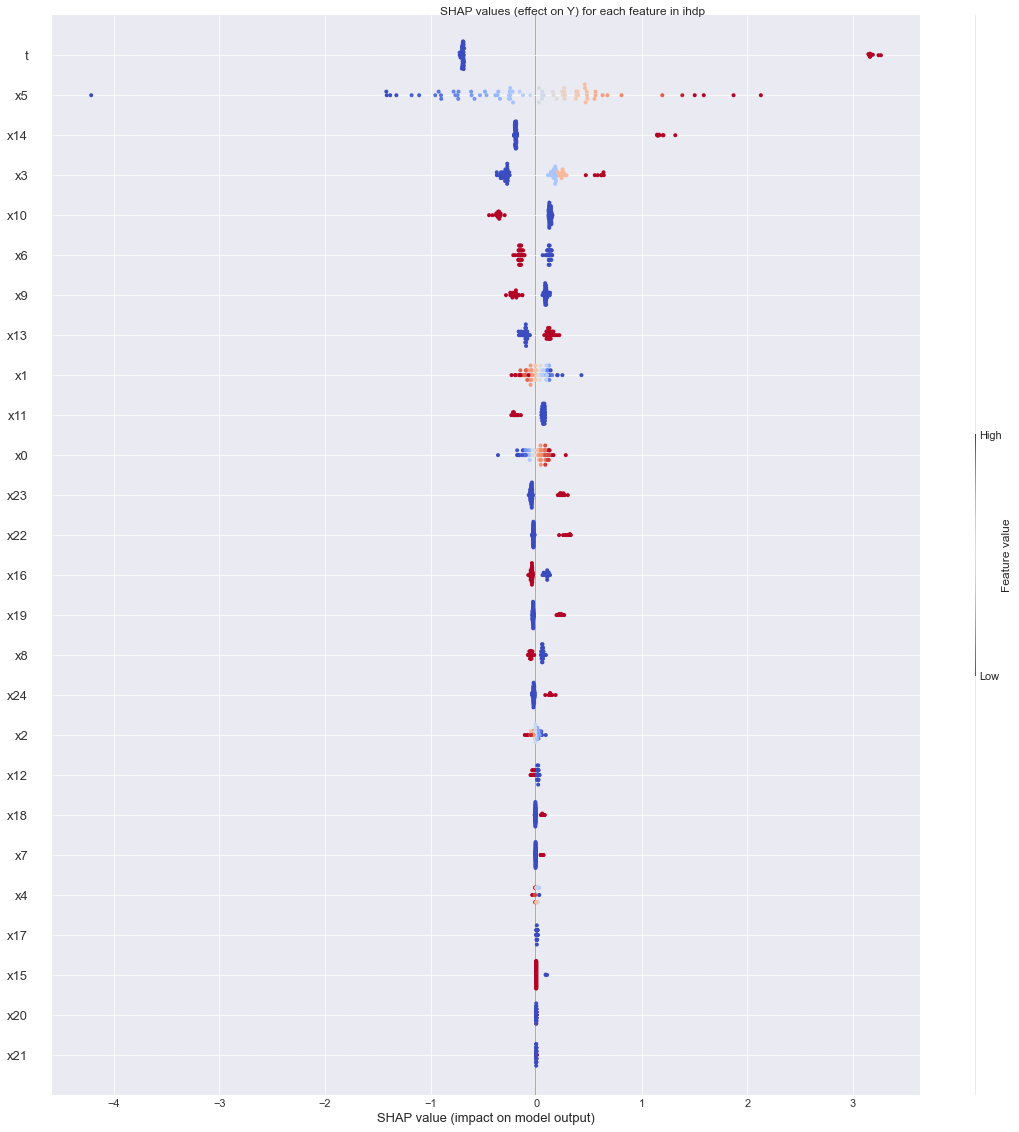

In [36]:
ada_ard_simple_best.shap_importance_plotter().show()

In [37]:
%%time

ada_sgd_simple_searched: List[
    slearner.SimpleHalvingGridSearchResults
] = slearner.simple_halving_grid_searcher(
    AdaBoostRegressor(
        random_state=seed()
    ),
    {
        #"regressor__base_estimator": [
        #    Pipeline(
        #        steps = [i for i in ard.best_estimator_.named_steps.items()]
        #    ) for ard in ard_searched_dict.keys()
        #],
        #"regressor__n_estimators": adaboost_estimators,
        "estimator__learning_rate": adaboost_learn_rate,
        "estimator__loss": adaboost_loss,
        "estimator__base_estimator": [
            pl.clone_best_final_estimator for pl in sgd_simple_searched
        ]
    },
    df_m=dfm,
    df_selection=df_utils.DatasetEnum.FACTUAL,
    learner_name="Adaboost SGD simple",
    kfold_splits=10,
    scorer_to_use=slearner.r2_score_id(),
    stratify_on=["t"],
    resource="estimator__n_estimators",
    resource_param_values=adaboost_estimators,
)


-- 10-fold attempt 1/3 start --
max: 25, min: 1, factor: 5
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 1
max_resources_: 25
aggressive_elimination: True
factor: 5
----------
iter: 0
n_candidates: 27
n_resources: 1
Fitting 10 folds for each of 27 candidates, totalling 270 fits
----------
iter: 1
n_candidates: 6
n_resources: 5
Fitting 10 folds for each of 6 candidates, totalling 60 fits
----------
iter: 2
n_candidates: 2
n_resources: 25
Fitting 10 folds for each of 2 candidates, totalling 20 fits
best from this iteration: 
GridSearchResults summary Adaboost SGD simple ihdp
	test score:	0.3573359105857906
	train score:0.6021236024090766
	yf score:	0.6267845509384288
	ycf score:	0.4914837988411156
	t0 score:	0.30724536891355914
	t1 score:	-0.6474622677203212
	ite score:	-0.3057742673050188
	abs ATE:	0.4874884413278333
	PEHE:   	0.9817668568019696
	abs ATT:	0.32632865671376887
	p. risk:	-5.351600832614066

--- 1/3 END ---
-- 10-fold attempt 2/3 start --

In [38]:
ada_sgd_simple_best: slearner.SimpleHalvingGridSearchResults = max(
    ada_sgd_simple_searched
)

In [39]:

print(ada_sgd_simple_best.info)

ada_sgd_simple_best.best_estimator_


GridSearchResults summary Adaboost SGD simple ihdp
	test score:	0.42940184648106683
	train score:0.6219592046886758
	yf score:	0.6439249643976184
	ycf score:	0.5369588132737715
	t0 score:	0.33026163075630954
	t1 score:	-0.4819142529692544
	ite score:	-0.2830904530221019
	abs ATE:	0.39483118899842795
	PEHE:   	0.9732019056907439
	abs ATT:	0.2516116582282546
	p. risk:	-5.29204169596698
	best params:
		estimator__base_estimator : SGDRegressor(alpha=0.001, early_stopping=True, l1_ratio=1, max_iter=32,
             penalty='elasticnet', power_t=0.5, random_state=42)
		estimator__learning_rate : 0.8
		estimator__loss : exponential
		estimator__n_estimators : 7


PPipeline(steps=[('scaler', QuantileTransformer(output_distribution='normal')),
                 ('imputer', KNNImputer(weights='distance')),
                 ('estimator',
                  AdaBoostRegressor(base_estimator=SGDRegressor(alpha=0.001,
                                                                early_stopping=True,
                                                                l1_ratio=1,
                                                                max_iter=32,
                                                                penalty='elasticnet',
                                                                power_t=0.5,
                                                                random_state=42),
                                    learning_rate=0.8, loss='exponential',
                                    n_estimators=7, random_state=42))])

In [40]:
ada_sgd_simple_best.save_me()

Pickling results to: \ihdp\ihdp Adaboost SGD simple results.pickle
pickled results!
Pickling simple estimator to \ihdp\ihdp Adaboost SGD simple estimator.pickle
pickled estimator!


Exporting feature importance graph to \ihdp\ihdp Adaboost SGD simple feature importances.pdf


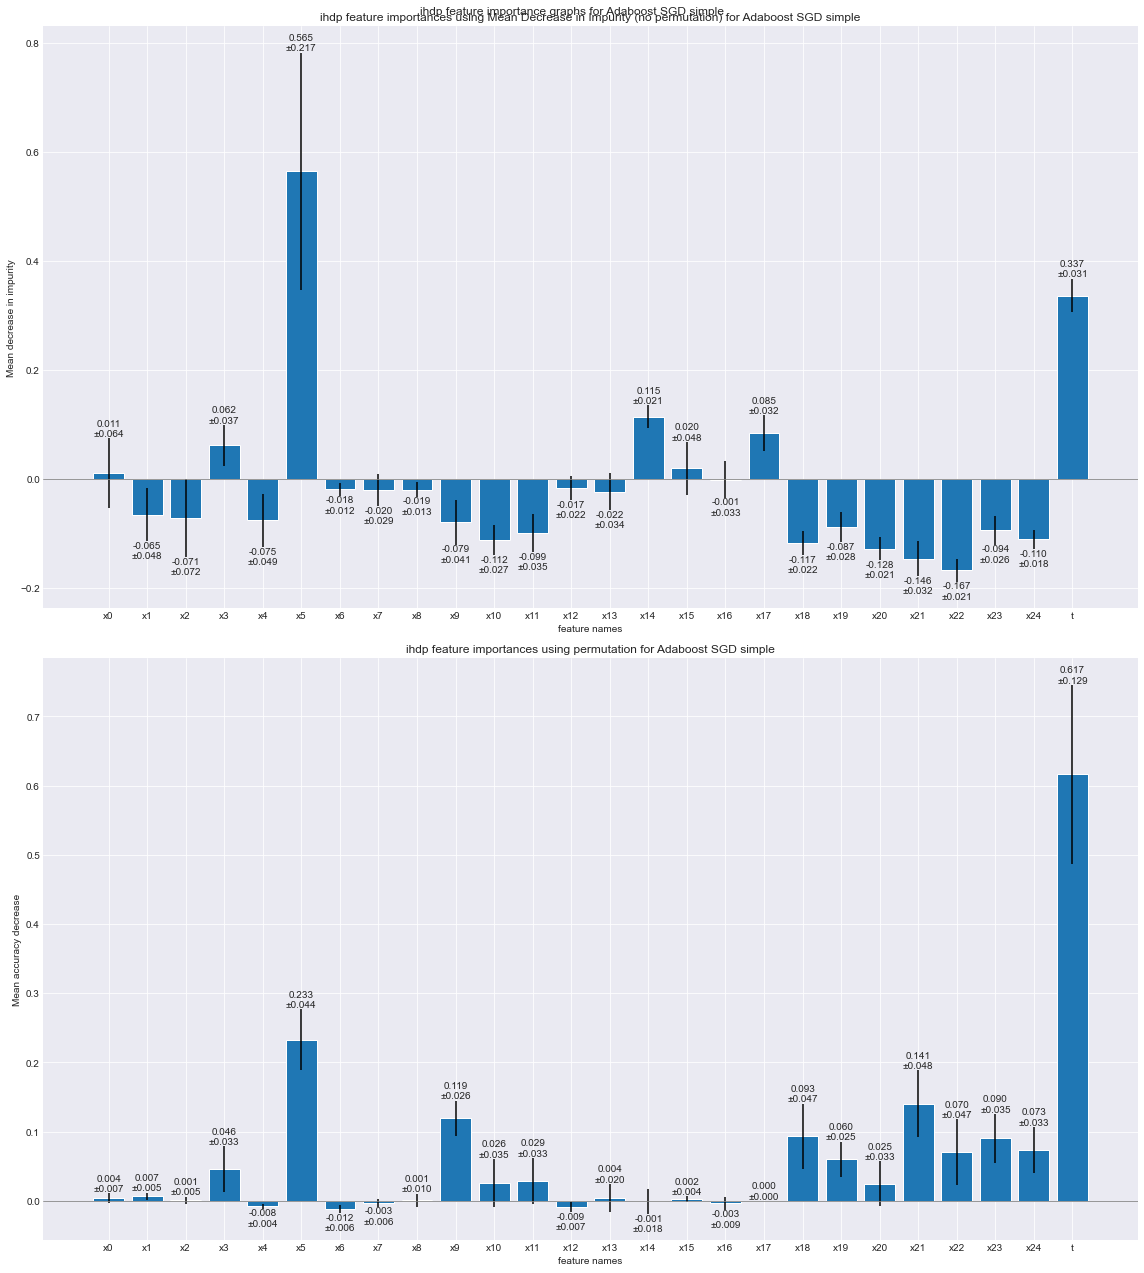

In [41]:
ada_sgd_simple_best.importance_plotter().show()

Permutation explainer: 76it [00:19,  1.89it/s]                        


Saving SHAP figure to ihdp\ihdp SHAP values for Adaboost SGD simple.pdf...


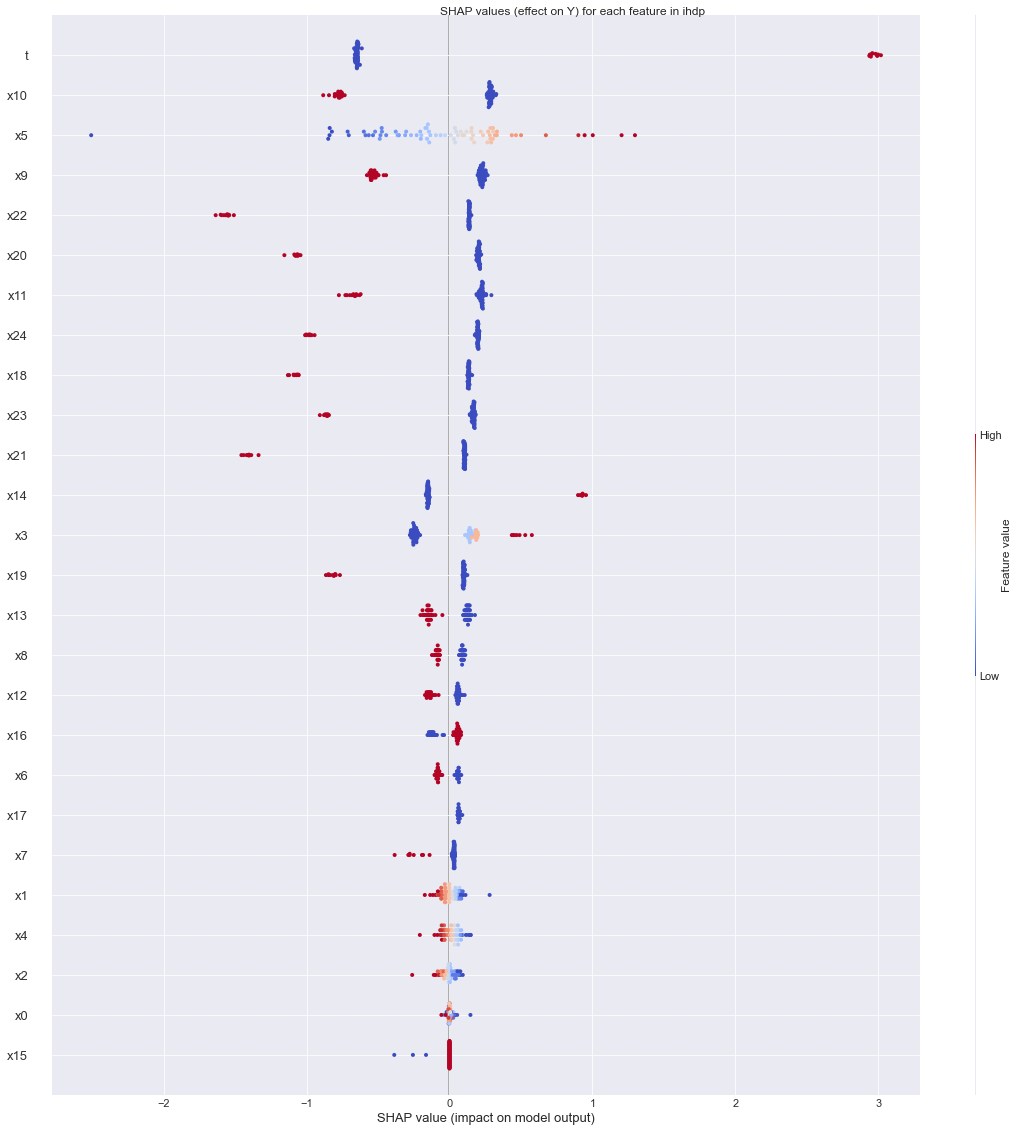

In [42]:
ada_sgd_simple_best.shap_importance_plotter().show()

In [43]:


all_simple_best: List[slearner.SimpleHalvingGridSearchResults] = [
    rf_simple_best,
    ard_simple_best,
    sgd_simple_best,
    ada_rf_simple_best,
    ada_ard_simple_best,
    ada_sgd_simple_best
]

all_simple_best.sort(reverse=True)


In [44]:
for bc in all_simple_best:
    print(bc.summary_info)

print("")

GridSearchResults summary Random Forest simple ihdp
	test score:	0.7025444813007882
	train score:0.7283555982472381
	yf score:	0.7395090031744529
	ycf score:	0.6812144871945791
	t0 score:	0.5015229296143691
	t1 score:	-0.0017911736391860167
	ite score:	0.6985193472979756
	abs ATE:	0.04366266896597448
	PEHE:   	0.4717414496808599
	abs ATT:	0.11724985825270862
	p. risk:	-5.491525000452395
GridSearchResults summary Adaboost Random Forest simple ihdp
	test score:	0.6874527684187223
	train score:0.7717375370449718
	yf score:	0.7949866672400211
	ycf score:	0.6874438521286699
	t0 score:	0.6006350067021621
	t1 score:	0.027300132322316095
	ite score:	0.5947668249136354
	abs ATE:	0.011366591926843306
	PEHE:   	0.5469237842457962
	abs ATT:	0.10211627901466658
	p. risk:	-5.466444278879323
GridSearchResults summary ARD simple ihdp
	test score:	0.5564596977895747
	train score:0.7174340703816985
	yf score:	0.7230858128688201
	ycf score:	0.6696308622344906
	t0 score:	0.49420677538586866
	t1 score:	-0.

In [45]:
best_simple_est: slearner.PPipeline = max(all_simple_best).best_estimator_

# Part 4 - Inverse Propensity Weights


### attempting to find the likelihood of individuals being NOT being included in the treatment group

In [46]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import SGDClassifier

In [47]:
%%time

rf_ipsw_searched: List[
    slearner.SimpleHalvingGridSearchResults
] = slearner.simple_halving_grid_searcher(
    RandomForestClassifier(random_state=seed()),
    {
        #"estimator__n_estimators": [75,100,125],
        "estimator__min_samples_split":  rf_min_samples,
        "estimator__min_impurity_decrease":  rf_min_impurity_decrease,
        "estimator__max_features":rf_max_features,
        # "estimator__oob_score": [False, True],
        "estimator__ccp_alpha": rf_ccp_alpha,
        "estimator__class_weight": ["balanced", "balanced subsample"],
    },
    df_m=dfm,
    df_selection=df_utils.DatasetEnum.X_T,
    learner_name="Random Forest IPSW",
    kfold_splits=10,
    scorer_to_use=slearner.roc_auc_id(),
    stratify_on=["t"],
    resource="estimator__n_estimators",
    resource_param_values=rf_n_estimators,
)

-- 10-fold attempt 1/3 start --
max: 50, min: 7, factor: 8
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 1
min_resources_: 7
max_resources_: 50
aggressive_elimination: True
factor: 8
----------
iter: 0
n_candidates: 480
n_resources: 7
Fitting 10 folds for each of 480 candidates, totalling 4800 fits
----------
iter: 1
n_candidates: 60
n_resources: 7
Fitting 10 folds for each of 60 candidates, totalling 600 fits
----------
iter: 2
n_candidates: 8
n_resources: 7
Fitting 10 folds for each of 8 candidates, totalling 80 fits
best from this iteration: 
GridSearchResults summary Random Forest IPSW ihdp
	test score:	0.6931818181818181
	train score:0.6625809375809376
	yf score:	0.724749148049981

--- 1/3 END ---
-- 10-fold attempt 2/3 start --
max: 100, min: 1, factor: 10
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 1
max_resources_: 100
aggressive_elimination: True
factor: 10
----------
iter: 0
n_candidates: 480
n_resources: 1
Fitting 10 fo

In [48]:

rf_ipsw_best: slearner.SimpleHalvingGridSearchResults = max(
    rf_ipsw_searched
)



In [49]:
print(rf_ipsw_best.info)

rf_ipsw_best.best_estimator_

GridSearchResults summary Random Forest IPSW ihdp
	test score:	0.7045454545454546
	train score:0.6884887334887335
	yf score:	0.7611285971223021
	best params:
		estimator__ccp_alpha : 0.006082201995573401
		estimator__class_weight : balanced
		estimator__max_features : 2
		estimator__min_impurity_decrease : 0.000246621207433047
		estimator__min_samples_split : 2
		estimator__n_estimators : 100


PPipeline(steps=[('scaler', QuantileTransformer(output_distribution='normal')),
                 ('imputer', KNNImputer(weights='distance')),
                 ('estimator',
                  RandomForestClassifier(ccp_alpha=0.006082201995573401,
                                         class_weight='balanced',
                                         max_features=2,
                                         min_impurity_decrease=0.000246621207433047,
                                         random_state=42))])

In [50]:
rf_ipsw_best.save_me()

Pickling results to: \ihdp\ihdp Random Forest IPSW results.pickle
pickled results!
Pickling simple estimator to \ihdp\ihdp Random Forest IPSW estimator.pickle
pickled estimator!


Exporting feature importance graph to \ihdp\ihdp Random Forest IPSW feature importances.pdf


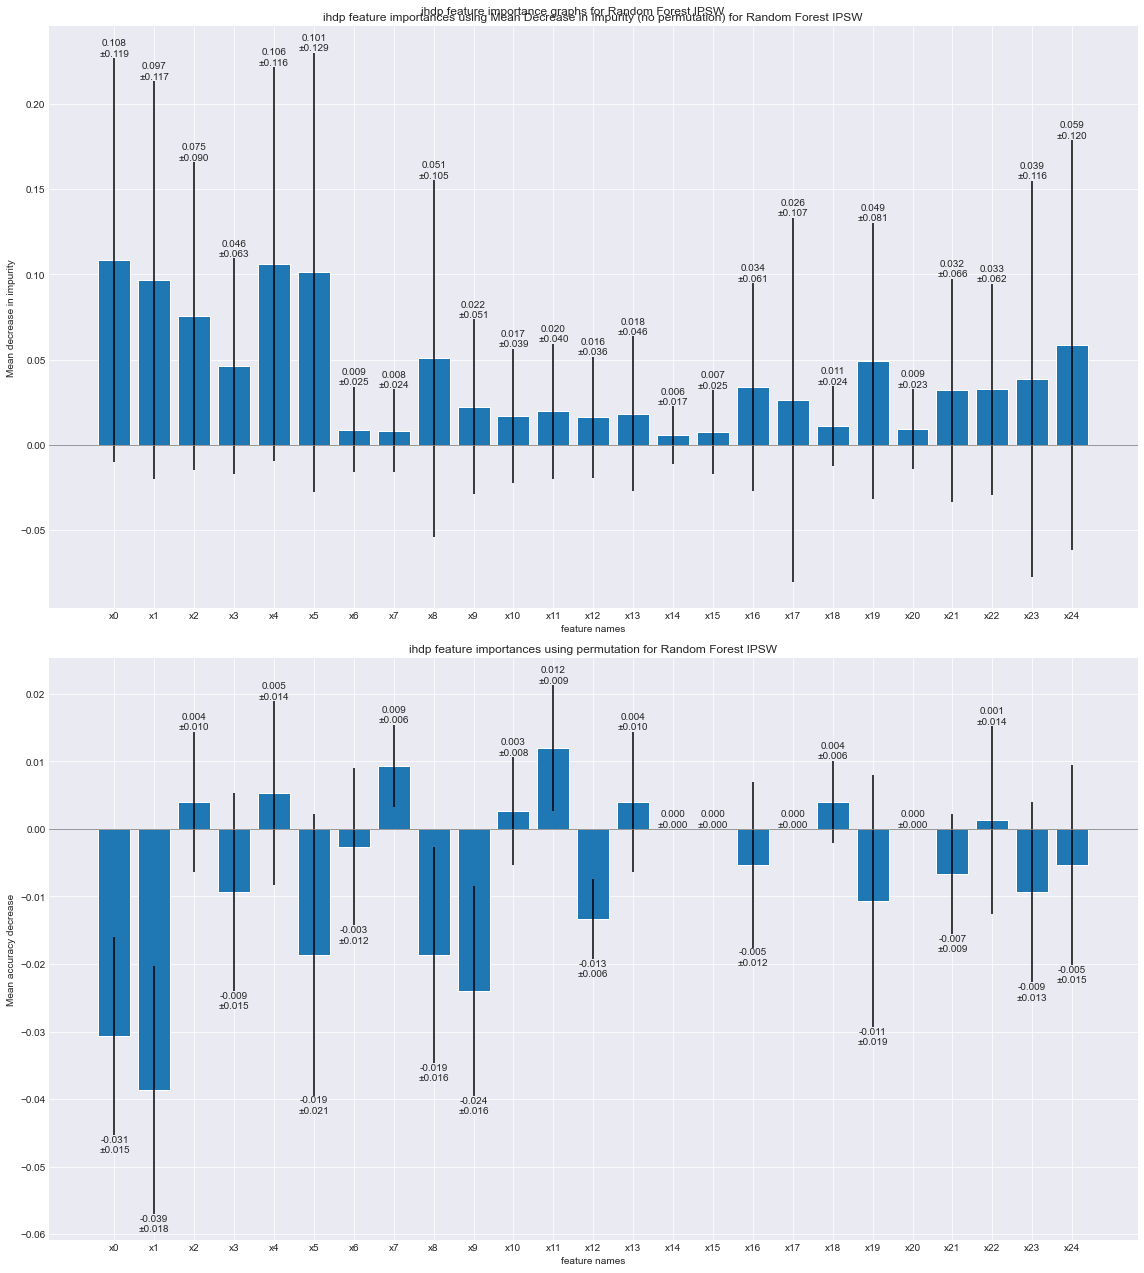

In [51]:
rf_ipsw_best.importance_plotter().show()

Permutation explainer: 76it [00:36,  1.52it/s]                        


Saving SHAP figure to ihdp\ihdp SHAP values for Random Forest IPSW.pdf...


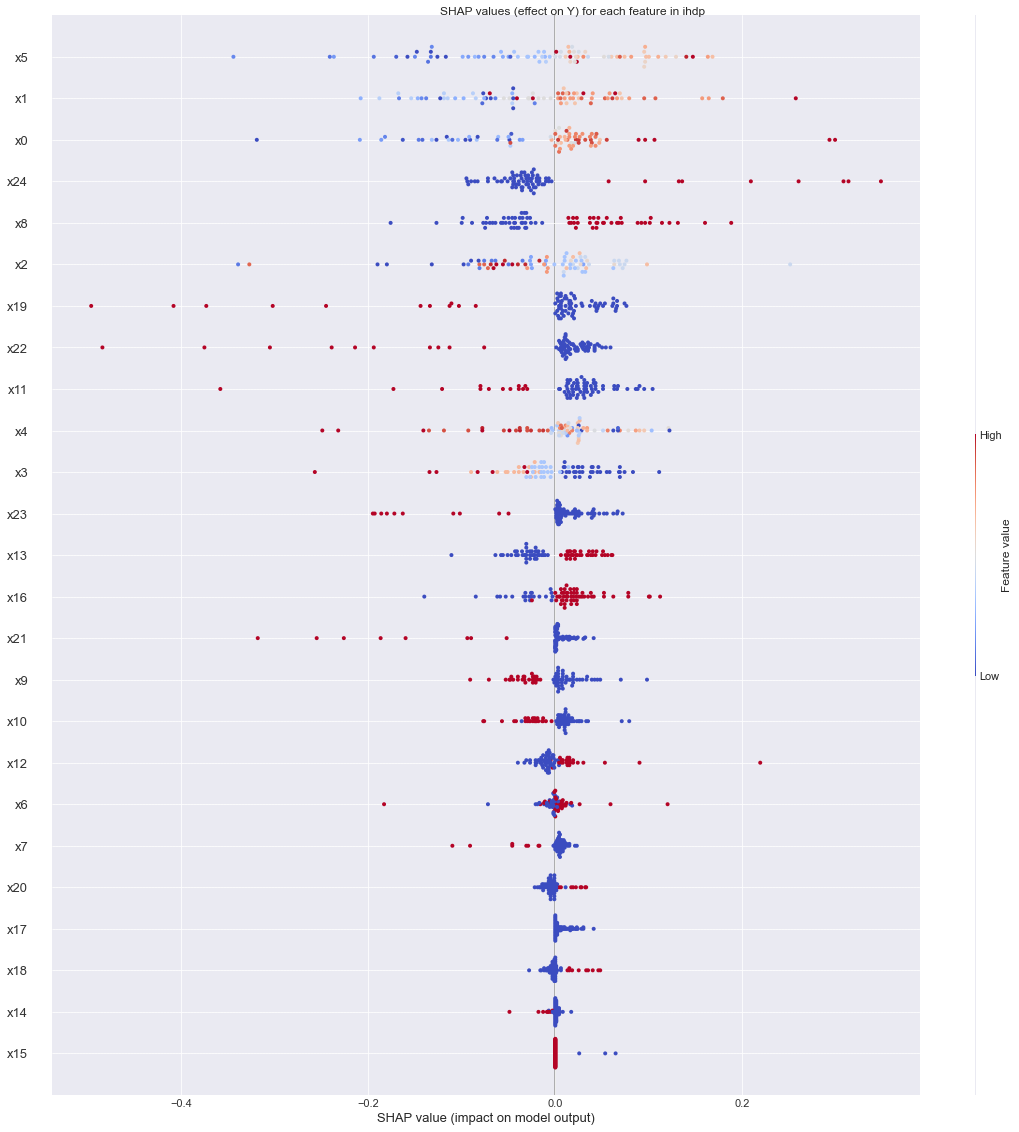

In [52]:
rf_ipsw_best.shap_importance_plotter().show()

In [53]:
%%time

# note: ridge does not support predict_proba, unusable, replaced with SGDClassifier.

sgd_ipsw_searched: List[
    slearner.SimpleHalvingGridSearchResults
] = slearner.simple_halving_grid_searcher(
    SGDClassifier(
        random_state=seed(),
        n_jobs=-1,
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=5,
        loss="log",
        penalty="elasticnet"
    ),
    {
        #"estimator__n_estimators": [75,100,125],
        "estimator__alpha": sgd_alpha,
        "estimator__power_t": sgd_power_t,
        "estimator__learning_rate": sgd_learning_rate,
        "estimator__l1_ratio": sgd_l1_ratio,
        "estimator__class_weight": ["balanced", None]
    },
    df_m=dfm,
    df_selection=df_utils.DatasetEnum.X_T,
    learner_name="sgd IPSW",
    kfold_splits=10,
    scorer_to_use=slearner.roc_auc_id(),
    stratify_on=["t"],
    resource="estimator__max_iter",
    resource_param_values=sgd_max_iter
)


-- 10-fold attempt 1/3 start --
max: 500, min: 22, factor: 23
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 1
min_resources_: 22
max_resources_: 500
aggressive_elimination: True
factor: 23
----------
iter: 0
n_candidates: 216
n_resources: 22
Fitting 10 folds for each of 216 candidates, totalling 2160 fits
----------
iter: 1
n_candidates: 10
n_resources: 22
Fitting 10 folds for each of 10 candidates, totalling 100 fits
best from this iteration: 
GridSearchResults summary sgd IPSW ihdp
	test score:	0.7102272727272727
	train score:0.5921989121989123
	yf score:	0.5538444244604317

--- 1/3 END ---
-- 10-fold attempt 2/3 start --
max: 1000, min: 32, factor: 32
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 1
min_resources_: 32
max_resources_: 1000
aggressive_elimination: True
factor: 32
----------
iter: 0
n_candidates: 216
n_resources: 32
Fitting 10 folds for each of 216 candidates, totalling 2160 fits
----------
iter: 1
n_candidates: 7
n_resources: 32
Fitt

In [54]:
sgd_ipsw_best: slearner.SimpleHalvingGridSearchResults = max(
    sgd_ipsw_searched
)

In [55]:

print(sgd_ipsw_best.info)

sgd_ipsw_best.best_estimator_

GridSearchResults summary sgd IPSW ihdp
	test score:	0.7102272727272727
	train score:0.5921989121989123
	yf score:	0.5538444244604317
	best params:
		estimator__alpha : 1e-05
		estimator__class_weight : balanced
		estimator__l1_ratio : 0.5
		estimator__learning_rate : optimal
		estimator__power_t : 0.75
		estimator__max_iter : 22


PPipeline(steps=[('scaler', QuantileTransformer(output_distribution='normal')),
                 ('imputer', KNNImputer(weights='distance')),
                 ('estimator',
                  SGDClassifier(alpha=1e-05, class_weight='balanced',
                                early_stopping=True, l1_ratio=0.5, loss='log',
                                max_iter=22, n_jobs=-1, penalty='elasticnet',
                                power_t=0.75, random_state=42))])

In [56]:

sgd_ipsw_best.save_me()

Pickling results to: \ihdp\ihdp sgd IPSW results.pickle
pickled results!
Pickling simple estimator to \ihdp\ihdp sgd IPSW estimator.pickle
pickled estimator!


Exporting feature importance graph to \ihdp\ihdp sgd IPSW feature importances.pdf


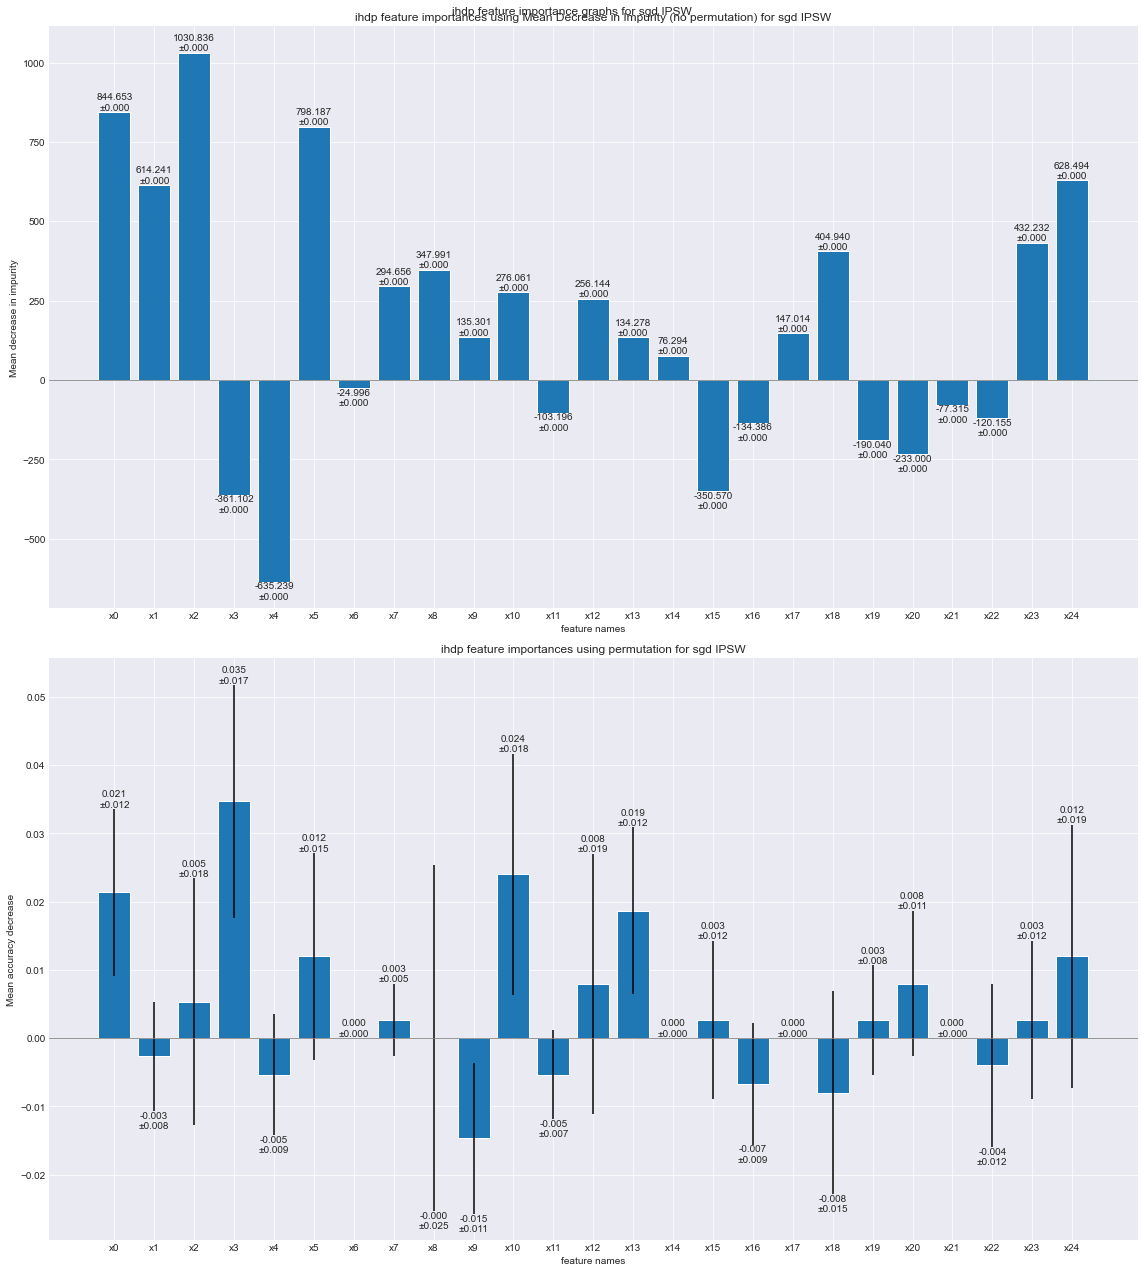

In [57]:

sgd_ipsw_best.importance_plotter().show()

Permutation explainer: 76it [00:16,  1.80it/s]                        


Saving SHAP figure to ihdp\ihdp SHAP values for sgd IPSW.pdf...


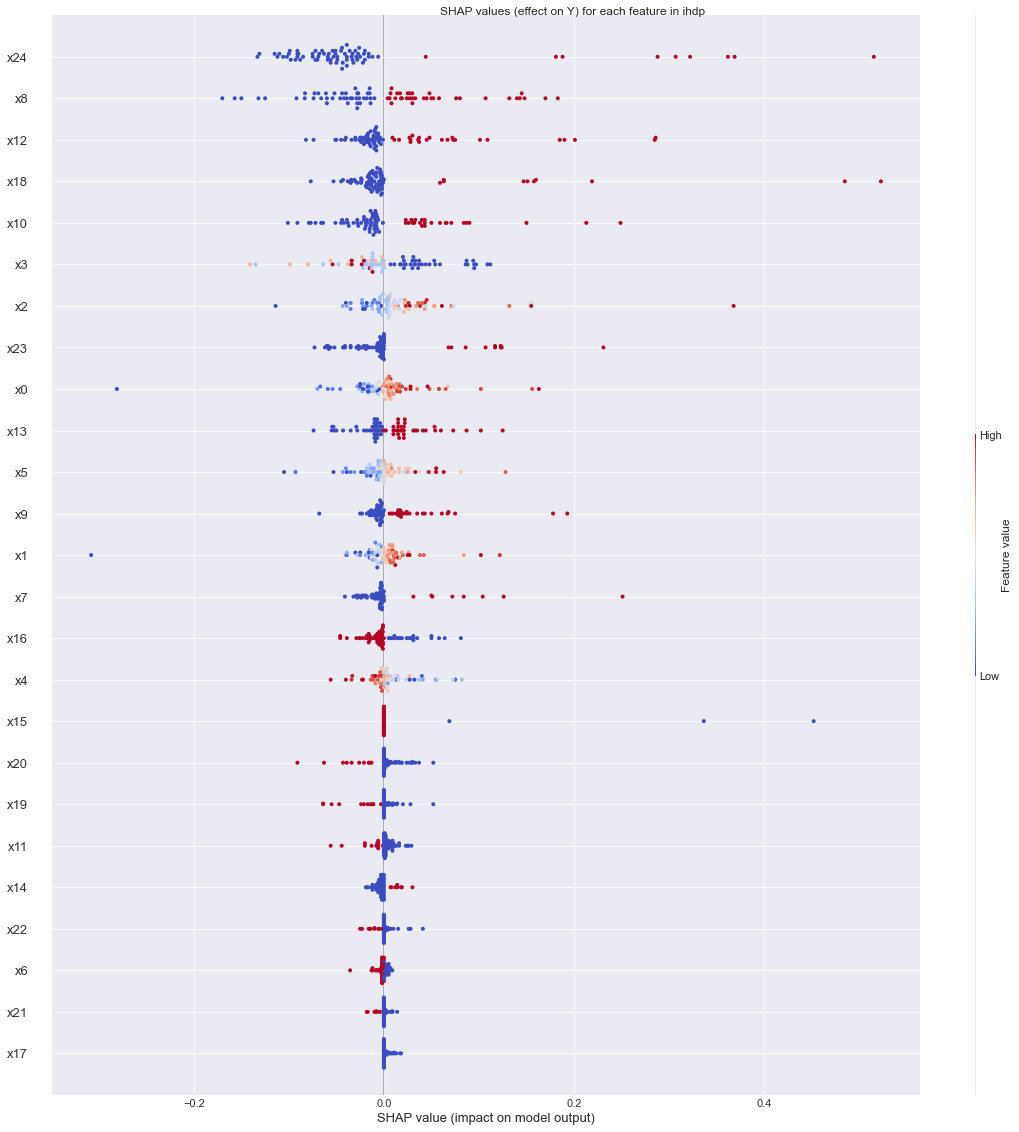

In [58]:
sgd_ipsw_best.shap_importance_plotter().show()

In [59]:
%%time

ada_rf_ipsw_searched: List[
    slearner.SimpleHalvingGridSearchResults
] = slearner.simple_halving_grid_searcher(
    AdaBoostClassifier(
        random_state = seed()
    ),
    {
        #"regressor__base_estimator": [
        #    Pipeline(
        #        steps = [i for i in rf.best_estimator_.named_steps.items()]
        #    ) for rf in random_forest_searched_dict.keys()
        #],
        #"regressor__n_estimators": adaboost_estimators,
        "estimator__learning_rate": adaboost_learn_rate,
        "estimator__base_estimator": [
            *[pl.clone_best_final_estimator for pl in rf_ipsw_searched],
            RandomForestClassifier(random_state=seed()),
            RandomForestClassifier(random_state=seed(), max_depth=10),
            DecisionTreeClassifier(random_state=seed()),
            DecisionTreeClassifier(random_state=seed(), max_depth=10)
        ]
    },
    df_m=dfm,
    df_selection=df_utils.DatasetEnum.X_T,
    learner_name="Adaboost Random Forest IPSW",
    kfold_splits=10,
    scorer_to_use=slearner.roc_auc_id(),
    stratify_on=["t"],
    resource="estimator__n_estimators",
    resource_param_values=adaboost_estimators,
)

-- 10-fold attempt 1/3 start --
max: 25, min: 1, factor: 5
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 3
min_resources_: 1
max_resources_: 25
aggressive_elimination: True
factor: 5
----------
iter: 0
n_candidates: 21
n_resources: 5
Fitting 10 folds for each of 21 candidates, totalling 210 fits
----------
iter: 1
n_candidates: 5
n_resources: 25
Fitting 10 folds for each of 5 candidates, totalling 50 fits
best from this iteration: 
GridSearchResults summary Adaboost Random Forest IPSW ihdp
	test score:	0.6747159090909091
	train score:0.6573737373737373
	yf score:	0.9427477754638394

--- 1/3 END ---
-- 10-fold attempt 2/3 start --
max: 50, min: 7, factor: 8
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 1
min_resources_: 7
max_resources_: 50
aggressive_elimination: True
factor: 8
----------
iter: 0
n_candidates: 21
n_resources: 7
Fitting 10 folds for each of 21 candidates, totalling 210 fits
----------
iter: 1
n_candidates: 3
n_resources: 7
Fitting 10 

In [60]:
ada_rf_ipsw_best: slearner.SimpleHalvingGridSearchResults = max(
    ada_rf_ipsw_searched
)

In [61]:

print(ada_rf_ipsw_best.info)

ada_rf_ipsw_best.best_estimator_

GridSearchResults summary Adaboost Random Forest IPSW ihdp
	test score:	0.6775568181818181
	train score:0.6693162393162393
	yf score:	0.8689476050738356
	best params:
		estimator__base_estimator : RandomForestClassifier(ccp_alpha=0.006082201995573401, class_weight='balanced',
                       max_features=2,
                       min_impurity_decrease=0.000246621207433047,
                       random_state=42)
		estimator__learning_rate : 1.0
		estimator__n_estimators : 7


PPipeline(steps=[('scaler', QuantileTransformer(output_distribution='normal')),
                 ('imputer', KNNImputer(weights='distance')),
                 ('estimator',
                  AdaBoostClassifier(base_estimator=RandomForestClassifier(ccp_alpha=0.006082201995573401,
                                                                           class_weight='balanced',
                                                                           max_features=2,
                                                                           min_impurity_decrease=0.000246621207433047,
                                                                           random_state=42),
                                     n_estimators=7, random_state=42))])

In [62]:

ada_rf_ipsw_best.save_me()

Pickling results to: \ihdp\ihdp Adaboost Random Forest IPSW results.pickle
pickled results!
Pickling simple estimator to \ihdp\ihdp Adaboost Random Forest IPSW estimator.pickle
pickled estimator!


Exporting feature importance graph to \ihdp\ihdp Adaboost Random Forest IPSW feature importances.pdf


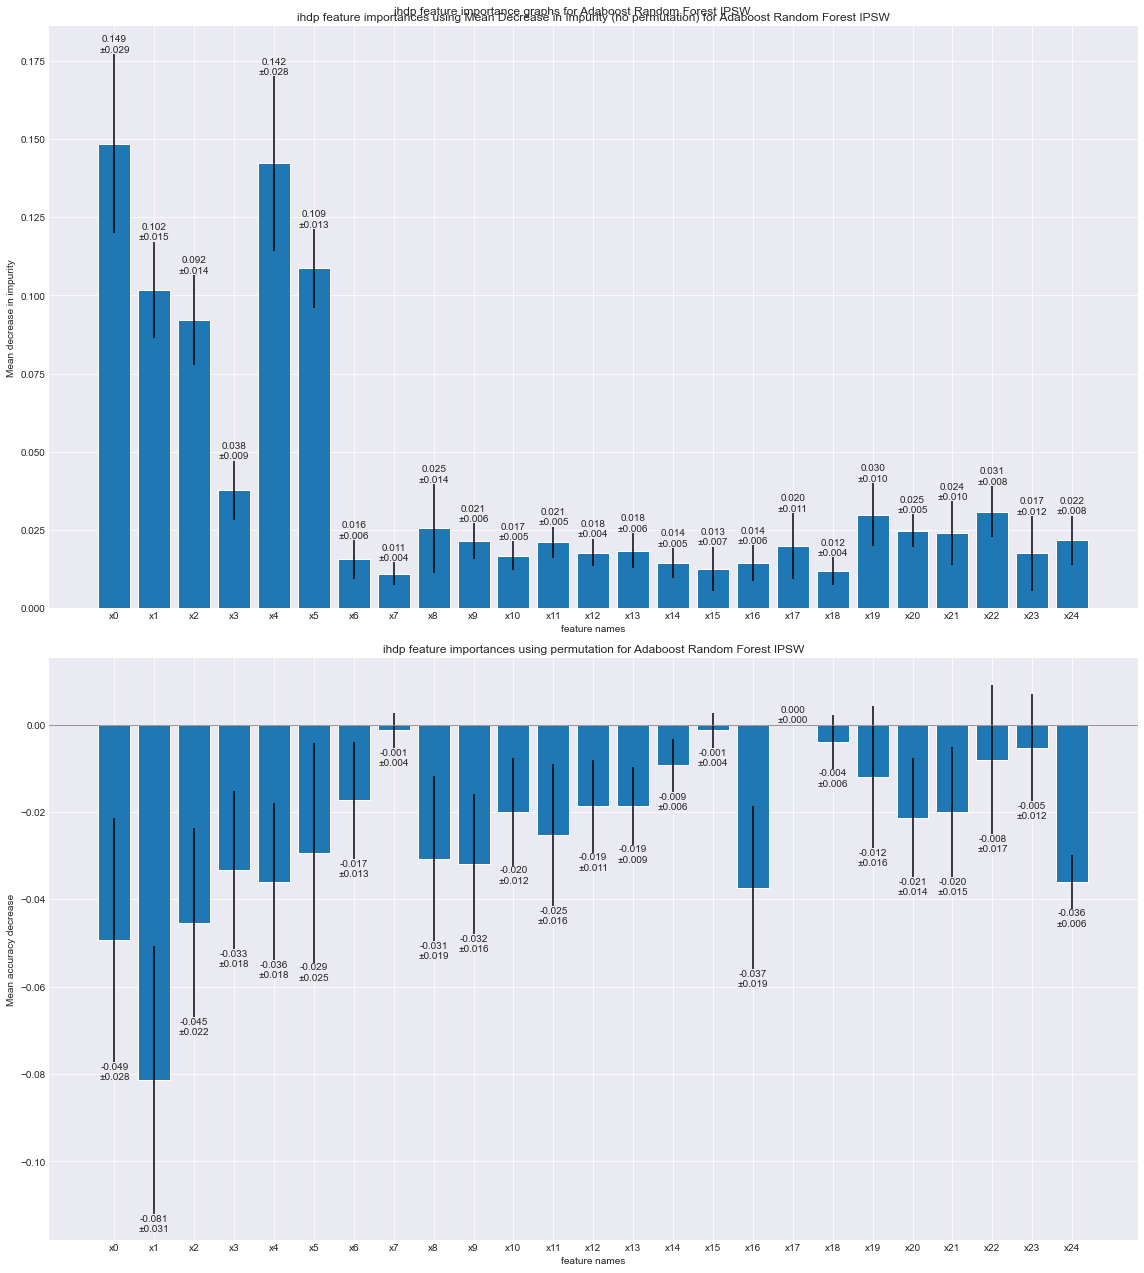

In [63]:

ada_rf_ipsw_best.importance_plotter().show()

Permutation explainer: 76it [02:18,  1.97s/it]                        


Saving SHAP figure to ihdp\ihdp SHAP values for Adaboost Random Forest IPSW.pdf...


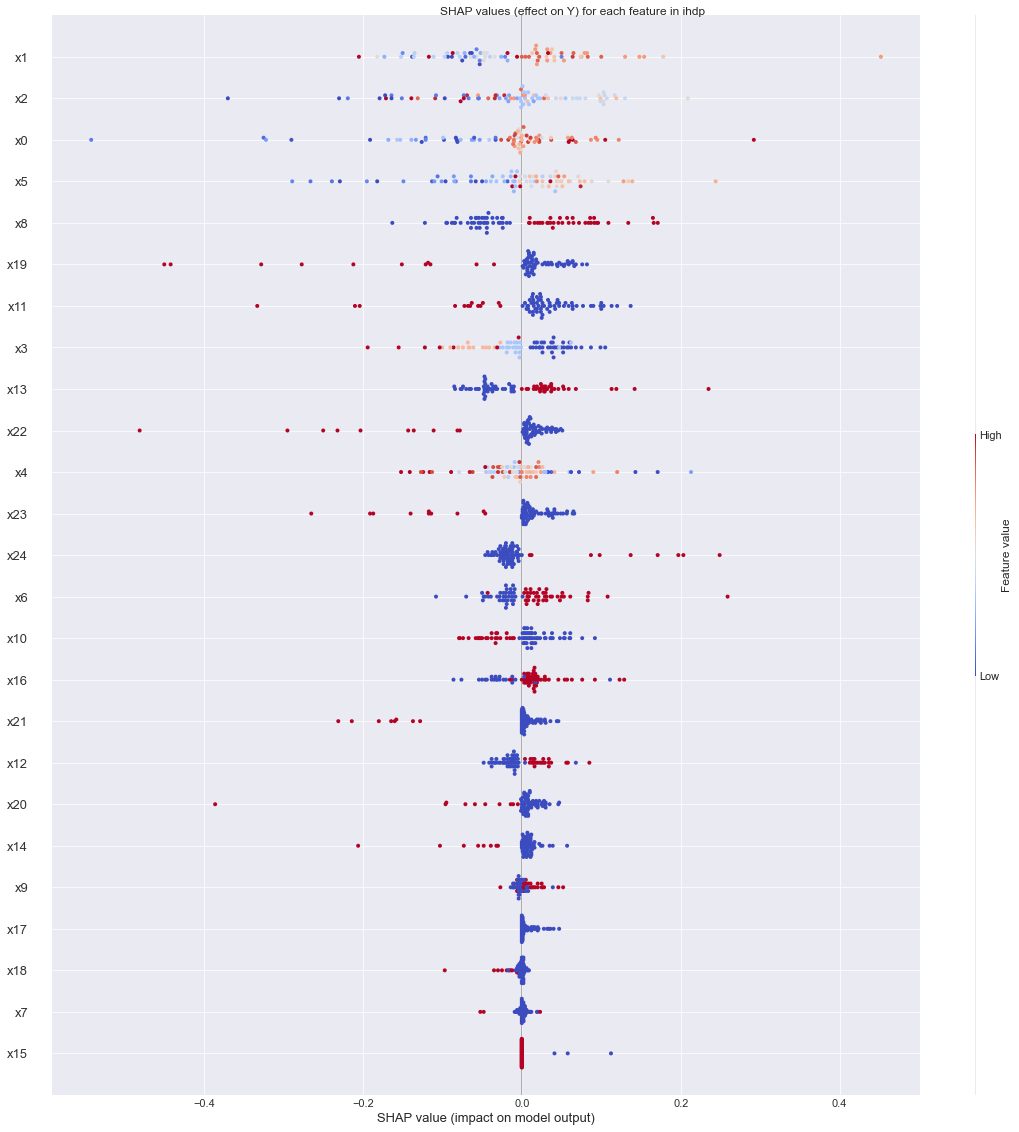

In [64]:
ada_rf_ipsw_best.shap_importance_plotter().show()

In [65]:
all_ipsw_clf_best: List[slearner.SimpleHalvingGridSearchResults] = [
    rf_ipsw_best,
    sgd_ipsw_best,
    ada_rf_ipsw_best
]

all_ipsw_clf_best.sort(reverse=True)

for bc in all_ipsw_clf_best:
    print(bc.summary_info)

print("")

GridSearchResults summary sgd IPSW ihdp
	test score:	0.7102272727272727
	train score:0.5921989121989123
	yf score:	0.5538444244604317
GridSearchResults summary Random Forest IPSW ihdp
	test score:	0.7045454545454546
	train score:0.6884887334887335
	yf score:	0.7611285971223021
GridSearchResults summary Adaboost Random Forest IPSW ihdp
	test score:	0.6775568181818181
	train score:0.6693162393162393
	yf score:	0.8689476050738356



In [66]:
import assignment2.a2_utils.simple_learner_utils as slearner

best_ipsw_predictor: slearner.PPipeline = max(all_ipsw_clf_best).best_estimator_

ipsw_calc: slearner.IpswWrapper = slearner.IpswWrapper.make(
    best_ipsw_predictor,
    dataset_name=dataset
)

ipsw_calc.save_me()


### And now using these weights to redo the earlier simple estimators

In [67]:
%%time


rf_simple_ipsw_searched: List[
    slearner.SimpleHalvingGridSearchResults
] = slearner.simple_halving_grid_searcher(
    RandomForestRegressor(criterion="squared_error", random_state=seed()),
    {
        #"estimator__n_estimators": [75,100,125],
        "estimator__min_samples_split":  rf_min_samples,
        "estimator__min_impurity_decrease":  rf_min_impurity_decrease,
        "estimator__max_features": rf_max_features,
        # "estimator__oob_score": [False, True],
        "estimator__ccp_alpha":  rf_ccp_alpha
    },
    df_m=dfm,
    df_selection=df_utils.DatasetEnum.FACTUAL,
    learner_name="Random Forest simple with IPSW",
    kfold_splits=10,
    scorer_to_use=slearner.r2_score_id(),
    stratify_on=["t"],
    resource="estimator__n_estimators",
    sample_weights=ipsw_calc,
    resource_param_values=rf_n_estimators,
    #classes_ndarray=ihdp_learn_df_x["t"].to_numpy()
)

-- 10-fold attempt 1/3 start --
max: 50, min: 7, factor: 8
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 1
min_resources_: 7
max_resources_: 50
aggressive_elimination: True
factor: 8
----------
iter: 0
n_candidates: 240
n_resources: 7
Fitting 10 folds for each of 240 candidates, totalling 2400 fits
----------
iter: 1
n_candidates: 30
n_resources: 7
Fitting 10 folds for each of 30 candidates, totalling 300 fits
----------
iter: 2
n_candidates: 4
n_resources: 7
Fitting 10 folds for each of 4 candidates, totalling 40 fits
best from this iteration: 
GridSearchResults summary Random Forest simple with IPSW ihdp
	test score:	0.644123234074506
	train score:0.7564297983880856
	yf score:	0.8535078650166091
	ycf score:	0.6955739988398464
	t0 score:	0.6905341325181477
	t1 score:	0.09377904968056439
	ite score:	0.516677388593185
	abs ATE:	0.04530629291874799
	PEHE:   	0.5973004893576587
	abs ATT:	0.09430517492174406
	p. risk:	-5.473185188281667

--- 1/3 END ---
-- 10-fold attempt

In [68]:

rf_simple_ipsw_best: slearner.SimpleHalvingGridSearchResults = max(
    rf_simple_ipsw_searched
)

In [69]:

print(rf_simple_ipsw_best.info)

rf_simple_ipsw_best.best_estimator_

GridSearchResults summary Random Forest simple with IPSW ihdp
	test score:	0.7025444813007882
	train score:0.7283555982472381
	yf score:	0.7395090031744529
	ycf score:	0.6812144871945791
	t0 score:	0.5015229296143691
	t1 score:	-0.0017911736391860167
	ite score:	0.6985193472979756
	abs ATE:	0.04366266896597448
	PEHE:   	0.4717414496808599
	abs ATT:	0.11724985825270862
	p. risk:	-5.491525000452395
	best params:
		estimator__ccp_alpha : 0.000246621207433047
		estimator__max_features : None
		estimator__min_impurity_decrease : 0.15
		estimator__min_samples_split : 4
		estimator__n_estimators : 100


PPipeline(steps=[('scaler', QuantileTransformer(output_distribution='normal')),
                 ('imputer', KNNImputer(weights='distance')),
                 ('estimator',
                  RandomForestRegressor(ccp_alpha=0.000246621207433047,
                                        max_features=None,
                                        min_impurity_decrease=0.15,
                                        min_samples_split=4,
                                        random_state=42))])

In [70]:

rf_simple_ipsw_best.save_me()

Pickling results to: \ihdp\ihdp Random Forest simple with IPSW results.pickle
pickled results!
Pickling simple estimator to \ihdp\ihdp Random Forest simple with IPSW estimator.pickle
pickled estimator!


Exporting feature importance graph to \ihdp\ihdp Random Forest simple with IPSW feature importances.pdf


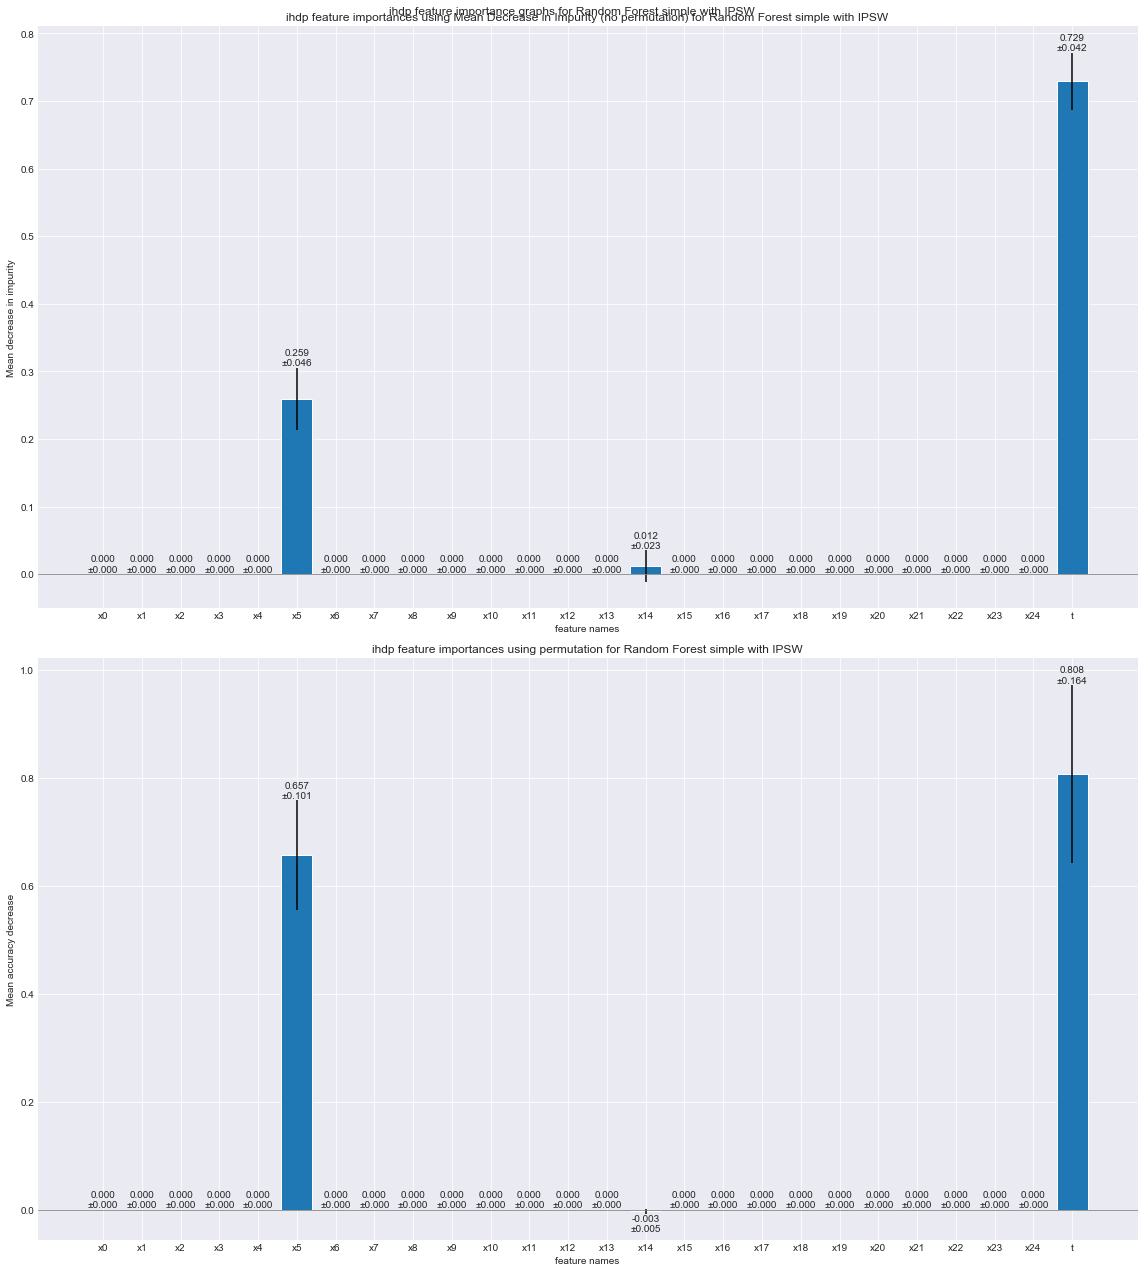

In [71]:
rf_simple_ipsw_best.importance_plotter().show()

Saving SHAP figure to ihdp\ihdp SHAP values for Random Forest simple.pdf...


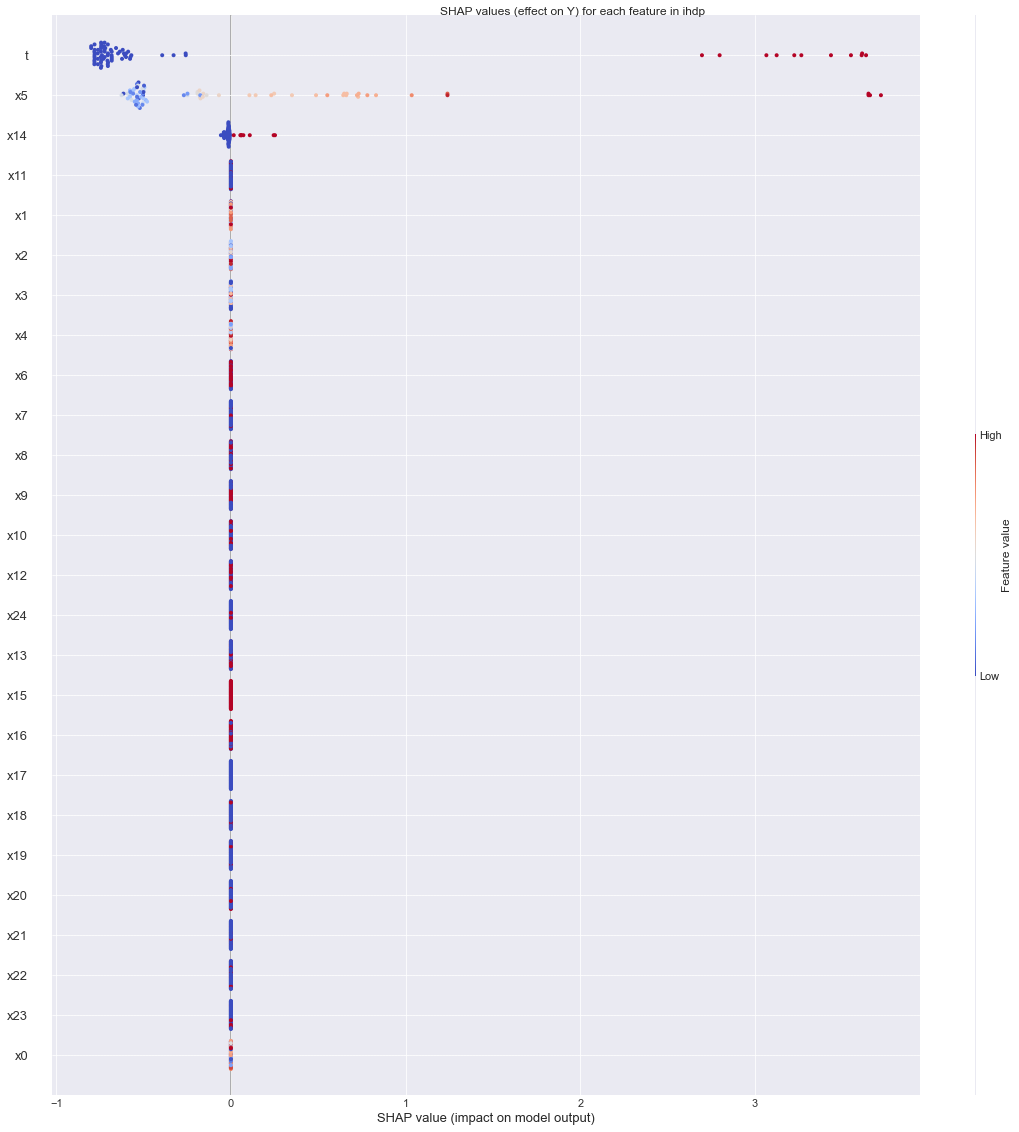

In [72]:
rf_simple_best.shap_importance_plotter().show()

In [73]:
%%time


ard_simple_ipsw_searched: List[
    slearner.SimpleHalvingGridSearchResults
] = slearner.simple_halving_grid_searcher(
    ARDRegression(),
    {
        #"regressor__n_iter": ard_iter,
        "estimator__tol": ard_tol,
        "estimator__alpha_1": ard_alpha_lambda,
        "estimator__alpha_2": ard_alpha_lambda,
        "estimator__lambda_1": ard_alpha_lambda,
        "estimator__lambda_2": ard_alpha_lambda,
        "estimator__threshold_lambda": ard_thresh_lambda
    },
    df_m=dfm,
    df_selection=df_utils.DatasetEnum.FACTUAL,
    learner_name="ARD simple with IPSW",
    kfold_splits=10,
    scorer_to_use=slearner.r2_score_id(),
    stratify_on=["t"],
    resource="estimator__n_iter",
    sample_weights=ipsw_calc,
    resource_param_values=ard_iter
)


-- 10-fold attempt 1/3 start --
max: 200, min: 14, factor: 15
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 1
min_resources_: 14
max_resources_: 200
aggressive_elimination: True
factor: 15
----------
iter: 0
n_candidates: 729
n_resources: 14
Fitting 10 folds for each of 729 candidates, totalling 7290 fits
----------
iter: 1
n_candidates: 49
n_resources: 14
Fitting 10 folds for each of 49 candidates, totalling 490 fits
----------
iter: 2
n_candidates: 4
n_resources: 14
Fitting 10 folds for each of 4 candidates, totalling 40 fits
best from this iteration: 
GridSearchResults summary ARD simple with IPSW ihdp
	test score:	0.5564596977895747
	train score:0.7174340703816985
	yf score:	0.7230858128688201
	ycf score:	0.6696308622344906
	t0 score:	0.49420677538586866
	t1 score:	-0.0880853724951618
	ite score:	-0.0008744474291235704
	abs ATE:	0.02540628505630016
	PEHE:   	0.8595360866486239
	abs ATT:	0.10410522166326874
	p. risk:	-5.4930213795885985

--- 1/3 END ---
-- 10-fold 

In [74]:
ard_simple_ipsw_best: slearner.SimpleHalvingGridSearchResults = max(
    ard_simple_ipsw_searched
)


In [75]:
print(ard_simple_ipsw_best.info)

ard_simple_ipsw_best.best_estimator_


GridSearchResults summary ARD simple with IPSW ihdp
	test score:	0.5564596977895747
	train score:0.7174340703816985
	yf score:	0.7230858128688201
	ycf score:	0.6696308622344906
	t0 score:	0.49420677538586866
	t1 score:	-0.0880853724951618
	ite score:	-0.0008744474291235704
	abs ATE:	0.02540628505630016
	PEHE:   	0.8595360866486239
	abs ATT:	0.10410522166326874
	p. risk:	-5.4930213795885985
	best params:
		estimator__alpha_1 : 1e-07
		estimator__alpha_2 : 1e-05
		estimator__lambda_1 : 1e-05
		estimator__lambda_2 : 1e-05
		estimator__threshold_lambda : 10000.0
		estimator__tol : 0.01
		estimator__n_iter : 14


PPipeline(steps=[('scaler', QuantileTransformer(output_distribution='normal')),
                 ('imputer', KNNImputer(weights='distance')),
                 ('estimator',
                  ARDRegression(alpha_1=1e-07, alpha_2=1e-05, lambda_1=1e-05,
                                lambda_2=1e-05, n_iter=14, tol=0.01))])

In [76]:
ard_simple_ipsw_best.save_me()

Pickling results to: \ihdp\ihdp ARD simple with IPSW results.pickle
pickled results!
Pickling simple estimator to \ihdp\ihdp ARD simple with IPSW estimator.pickle
pickled estimator!


Exporting feature importance graph to \ihdp\ihdp ARD simple with IPSW feature importances.pdf


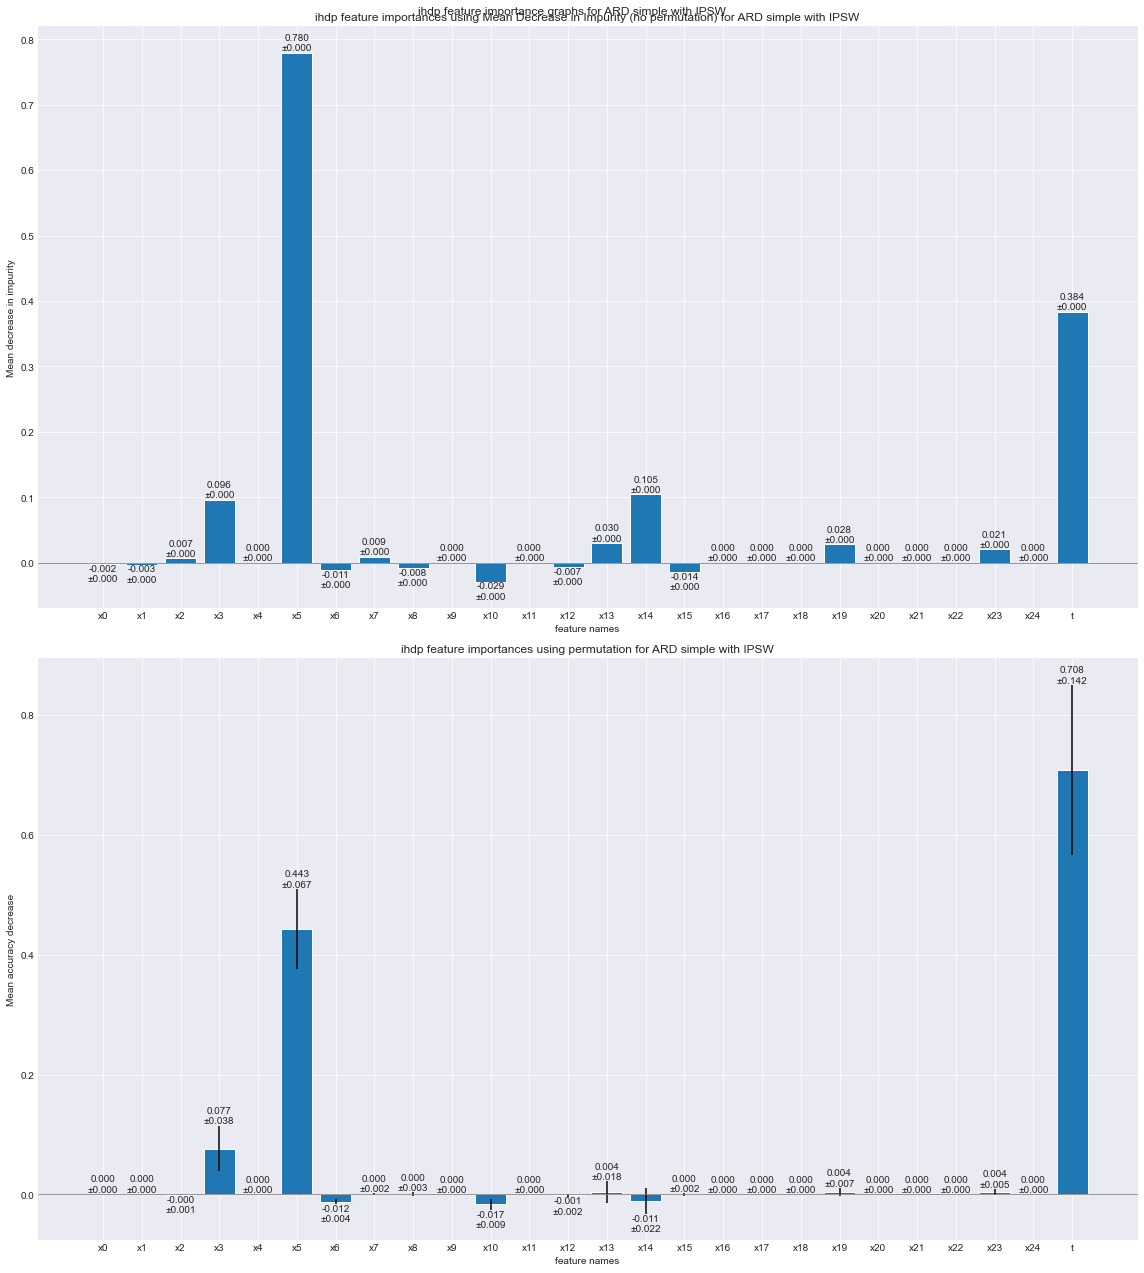

In [77]:
ard_simple_ipsw_best.importance_plotter().show()

In [78]:
%%time

sgd_simple_ipsw_searched: List[
    slearner.SimpleHalvingGridSearchResults
] = slearner.simple_halving_grid_searcher(
    SGDRegressor(
        random_state=seed(),
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=5,
        penalty="elasticnet"
    ),
    {
        #"regressor__n_iter": ard_iter,
        "estimator__alpha": sgd_alpha,
        "estimator__power_t": sgd_power_t,
        "estimator__learning_rate": sgd_learning_rate,
        "estimator__l1_ratio": sgd_l1_ratio
    },
    df_m=dfm,
    df_selection=df_utils.DatasetEnum.FACTUAL,
    learner_name="sgd simple ipsw",
    kfold_splits=10,
    scorer_to_use=slearner.r2_score_id(),
    stratify_on=["t"],
    resource="estimator__max_iter",
    resource_param_values=sgd_max_iter,
    sample_weights=ipsw_calc
)

-- 10-fold attempt 1/3 start --
max: 500, min: 22, factor: 23
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 1
min_resources_: 22
max_resources_: 500
aggressive_elimination: True
factor: 23
----------
iter: 0
n_candidates: 108
n_resources: 22
Fitting 10 folds for each of 108 candidates, totalling 1080 fits
----------
iter: 1
n_candidates: 5
n_resources: 22
Fitting 10 folds for each of 5 candidates, totalling 50 fits
best from this iteration: 
GridSearchResults summary sgd simple ipsw ihdp
	test score:	0.4425780268844929
	train score:0.6269645946519098
	yf score:	0.6427940441859836
	ycf score:	0.5531127392764995
	t0 score:	0.3320840758703357
	t1 score:	-0.4380164106561475
	ite score:	-0.03812289984639472
	abs ATE:	0.1677518344022335
	PEHE:   	0.8753841915845768
	abs ATT:	0.2949318616657459
	p. risk:	-5.323169480673895

--- 1/3 END ---
-- 10-fold attempt 2/3 start --
max: 1000, min: 32, factor: 32
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 1
min_reso

In [79]:

sgd_simple_ipsw_best: slearner.SimpleHalvingGridSearchResults = max(
    sgd_simple_ipsw_searched
)

In [80]:

print(sgd_simple_ipsw_best.info)

sgd_simple_ipsw_best.best_estimator_

GridSearchResults summary sgd simple ipsw ihdp
	test score:	0.4425780268844929
	train score:0.6269645946519098
	yf score:	0.6427940441859836
	ycf score:	0.5531127392764995
	t0 score:	0.3320840758703357
	t1 score:	-0.4380164106561475
	ite score:	-0.03812289984639472
	abs ATE:	0.1677518344022335
	PEHE:   	0.8753841915845768
	abs ATT:	0.2949318616657459
	p. risk:	-5.323169480673895
	best params:
		estimator__alpha : 0.001
		estimator__l1_ratio : 1
		estimator__learning_rate : invscaling
		estimator__power_t : 0.5
		estimator__max_iter : 22


PPipeline(steps=[('scaler', QuantileTransformer(output_distribution='normal')),
                 ('imputer', KNNImputer(weights='distance')),
                 ('estimator',
                  SGDRegressor(alpha=0.001, early_stopping=True, l1_ratio=1,
                               max_iter=22, penalty='elasticnet', power_t=0.5,
                               random_state=42))])

In [81]:

sgd_simple_ipsw_best.save_me()

Pickling results to: \ihdp\ihdp sgd simple ipsw results.pickle
pickled results!
Pickling simple estimator to \ihdp\ihdp sgd simple ipsw estimator.pickle
pickled estimator!


Exporting feature importance graph to \ihdp\ihdp sgd simple ipsw feature importances.pdf


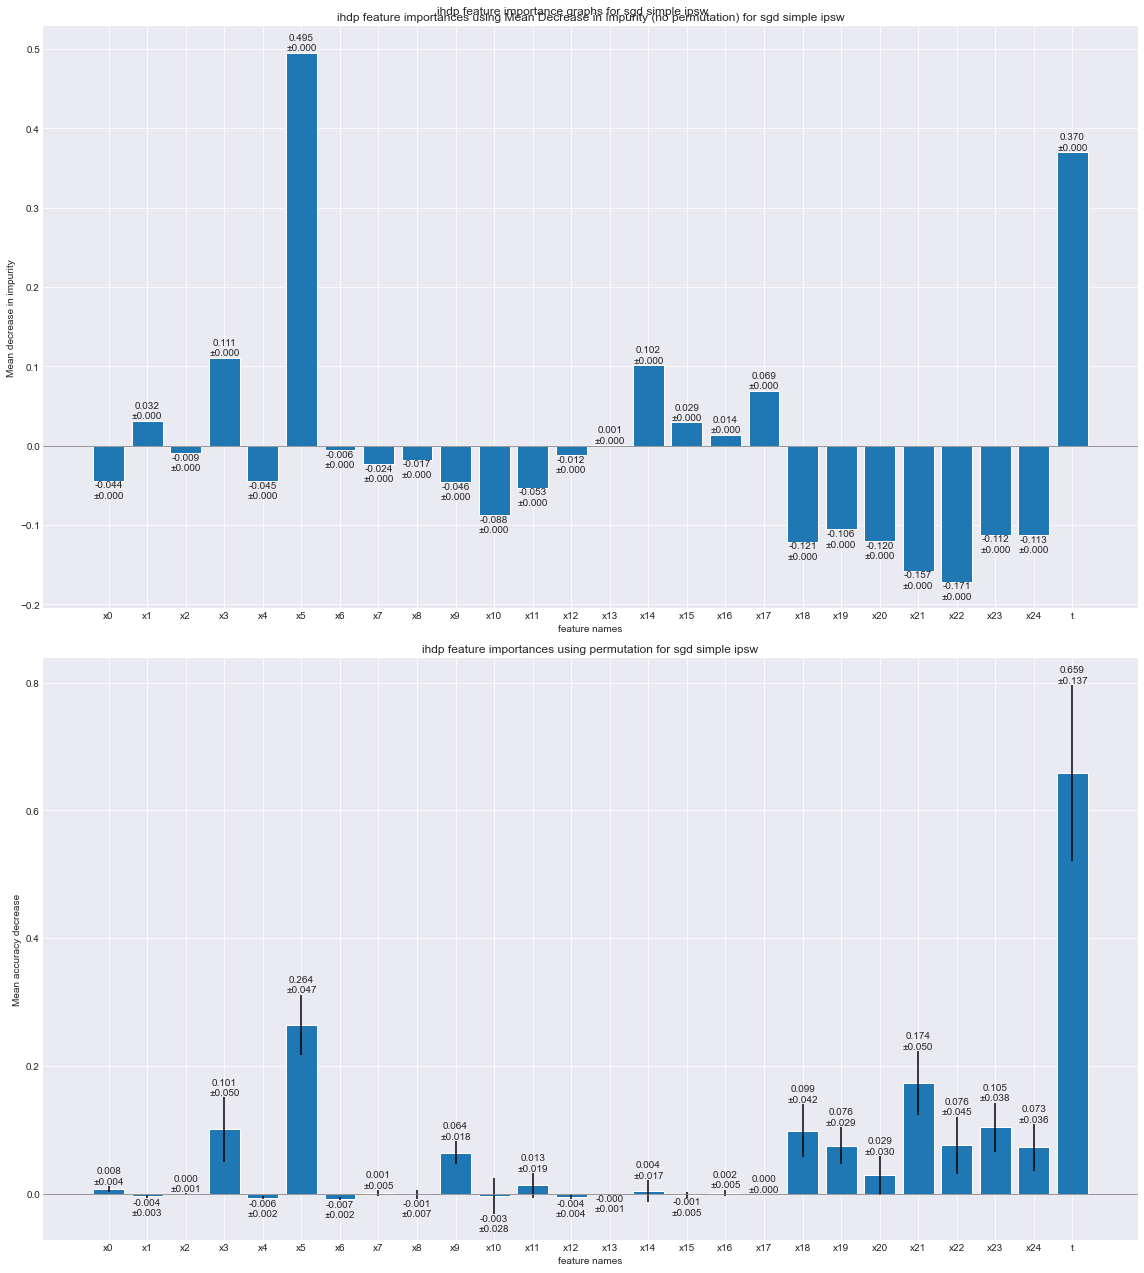

In [82]:
sgd_simple_ipsw_best.importance_plotter().show()

In [83]:
%%time


ada_rf_simple_ipsw_searched: List[
    slearner.SimpleHalvingGridSearchResults
] = slearner.simple_halving_grid_searcher(
    AdaBoostRegressor(
        random_state=seed()
    ),
    {
        #"regressor__base_estimator": [
        #    Pipeline(
        #        steps = [i for i in rf.best_estimator_.named_steps.items()]
        #    ) for rf in random_forest_searched_dict.keys()
        #],
        #"regressor__n_estimators": adaboost_estimators,
        "estimator__learning_rate": adaboost_learn_rate,
        "estimator__loss": adaboost_loss,
        "estimator__base_estimator": [
            *[pl.clone_best_final_estimator for pl in rf_simple_ipsw_searched],
            RandomForestRegressor(random_state=seed()),
            RandomForestRegressor(random_state=seed(), max_depth=10),
            DecisionTreeRegressor(random_state=seed()),
            DecisionTreeRegressor(random_state=seed(), max_depth=10)
        ]
    },
    df_m=dfm,
    df_selection=df_utils.DatasetEnum.FACTUAL,
    learner_name="Adaboost Random Forest simple with IPSW",
    kfold_splits=10,
    scorer_to_use=slearner.r2_score_id(),
    stratify_on=["t"],
    sample_weights=ipsw_calc,
    resource="estimator__n_estimators",
    resource_param_values=adaboost_estimators,
)

-- 10-fold attempt 1/3 start --
max: 25, min: 1, factor: 5
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 1
max_resources_: 25
aggressive_elimination: True
factor: 5
----------
iter: 0
n_candidates: 63
n_resources: 1
Fitting 10 folds for each of 63 candidates, totalling 630 fits
----------
iter: 1
n_candidates: 13
n_resources: 5
Fitting 10 folds for each of 13 candidates, totalling 130 fits
----------
iter: 2
n_candidates: 3
n_resources: 25
Fitting 10 folds for each of 3 candidates, totalling 30 fits
best from this iteration: 
GridSearchResults summary Adaboost Random Forest simple with IPSW ihdp
	test score:	0.6451151456399878
	train score:0.7647881231497995
	yf score:	0.9331340121563024
	ycf score:	0.6809523159575235
	t0 score:	0.8111136160660275
	t1 score:	0.10497306121133942
	ite score:	0.04569268384567937
	abs ATE:	0.05910762227097255
	PEHE:   	0.8393023527994102
	abs ATT:	0.053589010912391544
	p. risk:	-5.443254773257158

--- 1/3 END ---
-- 10-f

In [84]:

ada_rf_simple_ipsw_best: slearner.SimpleHalvingGridSearchResults = max(
    ada_rf_simple_ipsw_searched
)

In [85]:

print(ada_rf_simple_ipsw_best.info)

ada_rf_simple_ipsw_best.best_estimator_


GridSearchResults summary Adaboost Random Forest simple with IPSW ihdp
	test score:	0.6874527684187223
	train score:0.7717375370449718
	yf score:	0.7949866672400211
	ycf score:	0.6874438521286699
	t0 score:	0.6006350067021621
	t1 score:	0.027300132322316095
	ite score:	0.5947668249136354
	abs ATE:	0.011366591926843306
	PEHE:   	0.5469237842457962
	abs ATT:	0.10211627901466658
	p. risk:	-5.466444278879323
	best params:
		estimator__base_estimator : RandomForestRegressor(ccp_alpha=0.000246621207433047, max_features=None,
                      min_impurity_decrease=0.15, min_samples_split=4,
                      random_state=42)
		estimator__learning_rate : 0.8
		estimator__loss : square
		estimator__n_estimators : 9


PPipeline(steps=[('scaler', QuantileTransformer(output_distribution='normal')),
                 ('imputer', KNNImputer(weights='distance')),
                 ('estimator',
                  AdaBoostRegressor(base_estimator=RandomForestRegressor(ccp_alpha=0.000246621207433047,
                                                                         max_features=None,
                                                                         min_impurity_decrease=0.15,
                                                                         min_samples_split=4,
                                                                         random_state=42),
                                    learning_rate=0.8, loss='square',
                                    n_estimators=9, random_state=42))])

In [86]:
ada_rf_simple_ipsw_best.save_me()

Pickling results to: \ihdp\ihdp Adaboost Random Forest simple with IPSW results.pickle
pickled results!
Pickling simple estimator to \ihdp\ihdp Adaboost Random Forest simple with IPSW estimator.pickle
pickled estimator!


Exporting feature importance graph to \ihdp\ihdp Adaboost Random Forest simple with IPSW feature importances.pdf


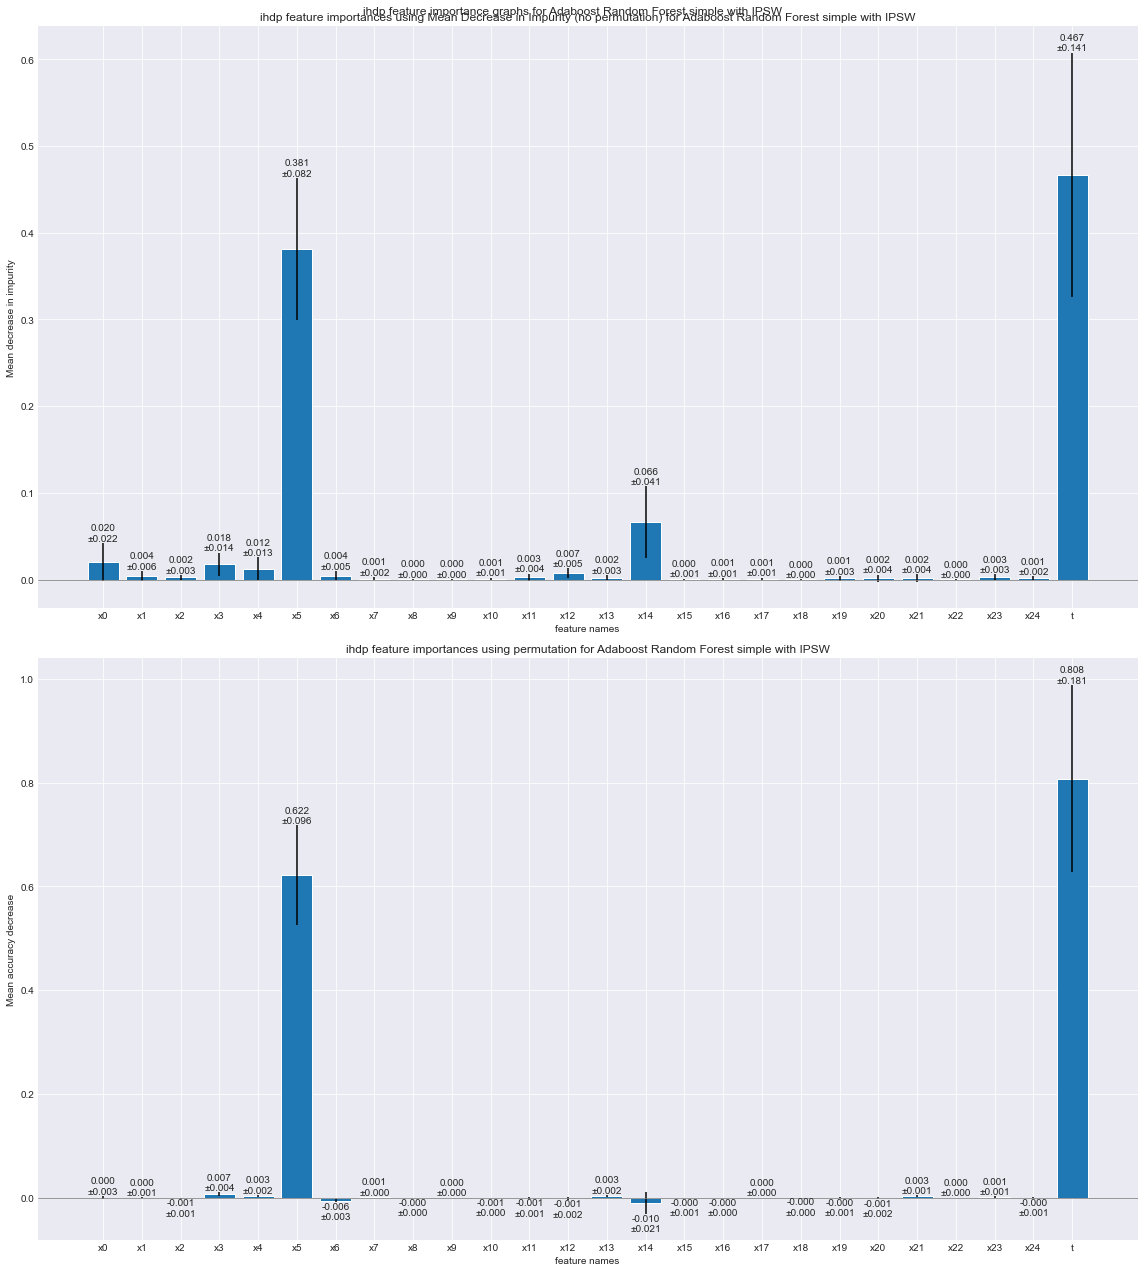

In [87]:
ada_rf_simple_ipsw_best.importance_plotter().show()

In [88]:
%%time
ada_ard_simple_ipsw_searched: List[
    slearner.SimpleHalvingGridSearchResults
] = slearner.simple_halving_grid_searcher(
    AdaBoostRegressor(
        random_state=seed()
    ),
    {
        #"regressor__base_estimator": [
        #    Pipeline(
        #        steps = [i for i in ard.best_estimator_.named_steps.items()]
        #    ) for ard in ard_searched_dict.keys()
        #],
        #"regressor__n_estimators": adaboost_estimators,
        "estimator__learning_rate": adaboost_learn_rate,
        "estimator__loss": adaboost_loss,
        "estimator__base_estimator": [
            pl.clone_best_final_estimator for pl in ard_simple_ipsw_searched
        ]
    },
    df_m=dfm,
    df_selection=df_utils.DatasetEnum.FACTUAL,
    learner_name="Adaboost ARD simple IPSW",
    kfold_splits=10,
    scorer_to_use=slearner.r2_score_id(),
    stratify_on=["t"],
    resource="estimator__n_estimators",
    sample_weights=ipsw_calc,
    resource_param_values=adaboost_estimators,
)


-- 10-fold attempt 1/3 start --
max: 25, min: 1, factor: 5
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 1
max_resources_: 25
aggressive_elimination: True
factor: 5
----------
iter: 0
n_candidates: 27
n_resources: 1
Fitting 10 folds for each of 27 candidates, totalling 270 fits
----------
iter: 1
n_candidates: 6
n_resources: 5
Fitting 10 folds for each of 6 candidates, totalling 60 fits
----------
iter: 2
n_candidates: 2
n_resources: 25
Fitting 10 folds for each of 2 candidates, totalling 20 fits
best from this iteration: 
GridSearchResults summary Adaboost ARD simple IPSW ihdp
	test score:	0.5087462065794635
	train score:0.695758292798755
	yf score:	0.7077255229933793
	ycf score:	0.647729328092481
	t0 score:	0.46771518330375905
	t1 score:	-0.16327030127030517
	ite score:	-0.06172731189434866
	abs ATE:	0.21980580090186885
	PEHE:   	0.885280317332184
	abs ATT:	0.13612280988914183
	p. risk:	-5.439688944523974

--- 1/3 END ---
-- 10-fold attempt 2/3 sta

In [89]:
ada_ard_simple_ipsw_best: slearner.SimpleHalvingGridSearchResults = max(
    ada_ard_simple_ipsw_searched
)


In [90]:
print(ada_ard_simple_ipsw_best.info)

ada_ard_simple_ipsw_best.best_estimator_


GridSearchResults summary Adaboost ARD simple IPSW ihdp
	test score:	0.51600483097099
	train score:0.705628359373024
	yf score:	0.710518280203459
	ycf score:	0.6514541765297475
	t0 score:	0.47079356947265294
	t1 score:	-0.14678133253730574
	ite score:	-0.055515909399514785
	abs ATE:	0.19590187415825122
	PEHE:   	0.882686949737021
	abs ATT:	0.11832144391352983
	p. risk:	-5.440470792714357
	best params:
		estimator__base_estimator : ARDRegression(alpha_1=1e-07, alpha_2=1e-05, lambda_1=1e-05, lambda_2=1e-05,
              n_iter=16, tol=0.01)
		estimator__learning_rate : 1.0
		estimator__loss : linear
		estimator__n_estimators : 7


PPipeline(steps=[('scaler', QuantileTransformer(output_distribution='normal')),
                 ('imputer', KNNImputer(weights='distance')),
                 ('estimator',
                  AdaBoostRegressor(base_estimator=ARDRegression(alpha_1=1e-07,
                                                                 alpha_2=1e-05,
                                                                 lambda_1=1e-05,
                                                                 lambda_2=1e-05,
                                                                 n_iter=16,
                                                                 tol=0.01),
                                    n_estimators=7, random_state=42))])

In [91]:
ada_ard_simple_ipsw_best.save_me()

Pickling results to: \ihdp\ihdp Adaboost ARD simple IPSW results.pickle
pickled results!
Pickling simple estimator to \ihdp\ihdp Adaboost ARD simple IPSW estimator.pickle
pickled estimator!


Exporting feature importance graph to \ihdp\ihdp Adaboost ARD simple IPSW feature importances.pdf


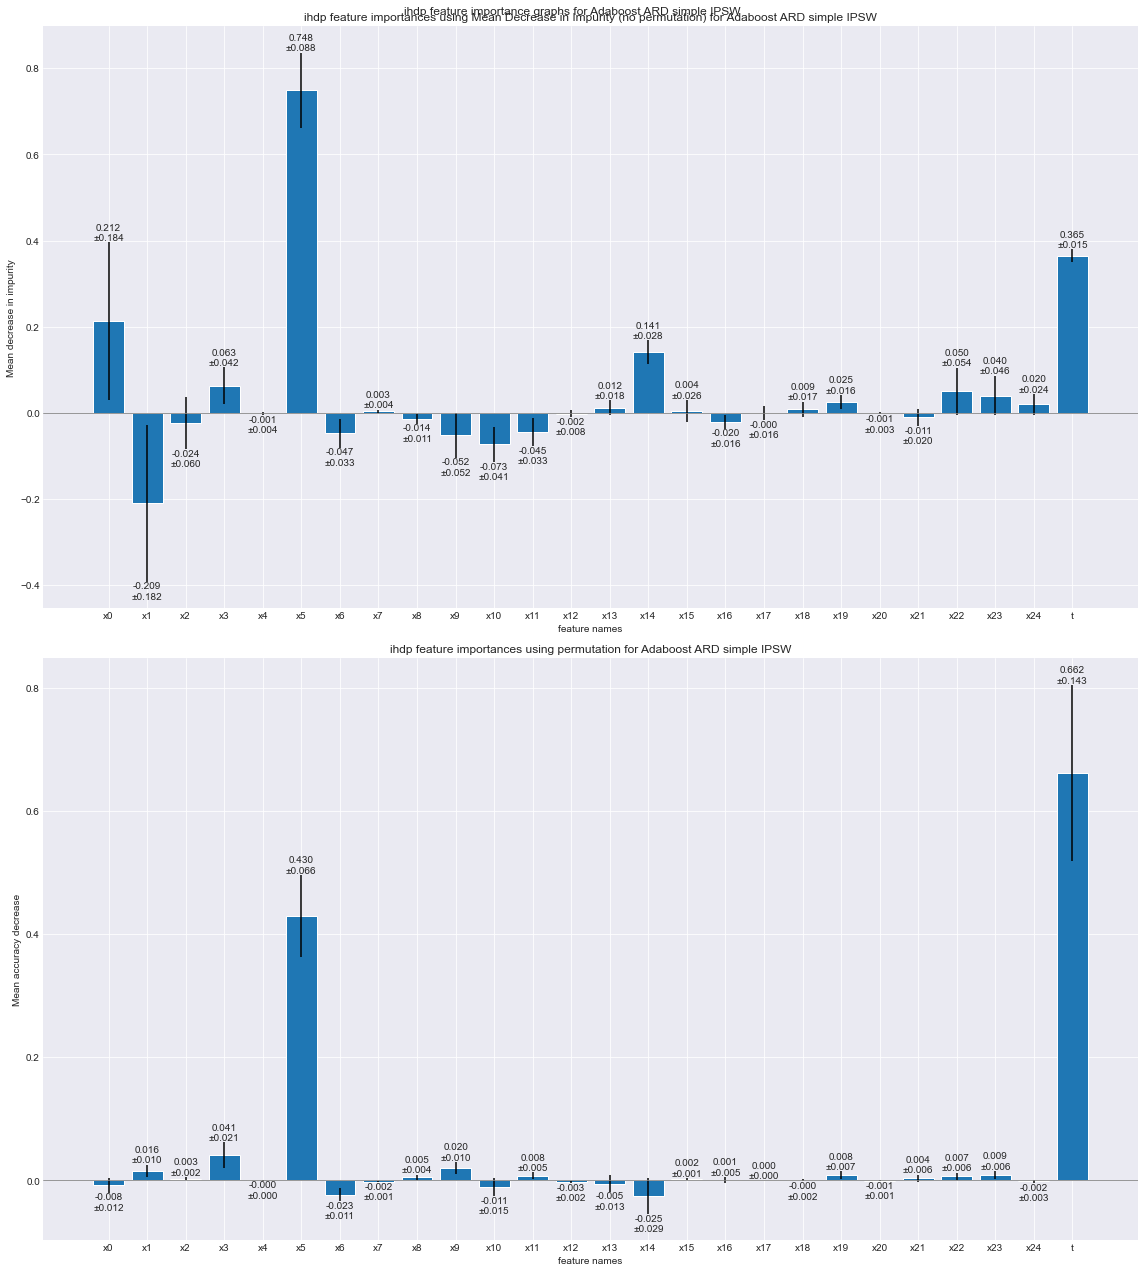

In [92]:
ada_ard_simple_ipsw_best.importance_plotter().show()


In [93]:
%%time


ada_sgd_simple_ipsw_searched: List[
    slearner.SimpleHalvingGridSearchResults
] = slearner.simple_halving_grid_searcher(
    AdaBoostRegressor(
        random_state=seed()
    ),
    {
        "estimator__learning_rate": adaboost_learn_rate,
        "estimator__loss": adaboost_loss,
        "estimator__base_estimator": [
            pl.clone_best_final_estimator for pl in sgd_simple_ipsw_searched
        ]
    },
    df_m=dfm,
    df_selection=df_utils.DatasetEnum.FACTUAL,
    learner_name="Adaboost SGD simple ipsw",
    kfold_splits=10,
    scorer_to_use=slearner.r2_score_id(),
    stratify_on=["t"],
    resource="estimator__n_estimators",
    resource_param_values=adaboost_estimators,
)

-- 10-fold attempt 1/3 start --
max: 25, min: 1, factor: 5
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 1
max_resources_: 25
aggressive_elimination: True
factor: 5
----------
iter: 0
n_candidates: 27
n_resources: 1
Fitting 10 folds for each of 27 candidates, totalling 270 fits
----------
iter: 1
n_candidates: 6
n_resources: 5
Fitting 10 folds for each of 6 candidates, totalling 60 fits
----------
iter: 2
n_candidates: 2
n_resources: 25
Fitting 10 folds for each of 2 candidates, totalling 20 fits
best from this iteration: 
GridSearchResults summary Adaboost SGD simple ipsw ihdp
	test score:	0.3573359105857906
	train score:0.6021236024090766
	yf score:	0.6267845509384288
	ycf score:	0.4914837988411156
	t0 score:	0.30724536891355914
	t1 score:	-0.6474622677203212
	ite score:	-0.3057742673050188
	abs ATE:	0.4874884413278333
	PEHE:   	0.9817668568019696
	abs ATT:	0.32632865671376887
	p. risk:	-5.351600832614066

--- 1/3 END ---
-- 10-fold attempt 2/3 sta

In [94]:

ada_sgd_simple_ipsw_best: slearner.SimpleHalvingGridSearchResults = max(
    ada_sgd_simple_ipsw_searched
)

In [95]:

print(ada_sgd_simple_ipsw_best.info)

ada_sgd_simple_ipsw_best.best_estimator_

GridSearchResults summary Adaboost SGD simple ipsw ihdp
	test score:	0.42940184648106683
	train score:0.6219592046886758
	yf score:	0.6439249643976184
	ycf score:	0.5369588132737715
	t0 score:	0.33026163075630954
	t1 score:	-0.4819142529692544
	ite score:	-0.2830904530221019
	abs ATE:	0.39483118899842795
	PEHE:   	0.9732019056907439
	abs ATT:	0.2516116582282546
	p. risk:	-5.29204169596698
	best params:
		estimator__base_estimator : SGDRegressor(alpha=0.001, early_stopping=True, l1_ratio=1, max_iter=32,
             penalty='elasticnet', power_t=0.5, random_state=42)
		estimator__learning_rate : 0.8
		estimator__loss : exponential
		estimator__n_estimators : 7


PPipeline(steps=[('scaler', QuantileTransformer(output_distribution='normal')),
                 ('imputer', KNNImputer(weights='distance')),
                 ('estimator',
                  AdaBoostRegressor(base_estimator=SGDRegressor(alpha=0.001,
                                                                early_stopping=True,
                                                                l1_ratio=1,
                                                                max_iter=32,
                                                                penalty='elasticnet',
                                                                power_t=0.5,
                                                                random_state=42),
                                    learning_rate=0.8, loss='exponential',
                                    n_estimators=7, random_state=42))])

In [96]:

ada_sgd_simple_ipsw_best.save_me()

Pickling results to: \ihdp\ihdp Adaboost SGD simple ipsw results.pickle
pickled results!
Pickling simple estimator to \ihdp\ihdp Adaboost SGD simple ipsw estimator.pickle
pickled estimator!


Exporting feature importance graph to \ihdp\ihdp Adaboost SGD simple ipsw feature importances.pdf


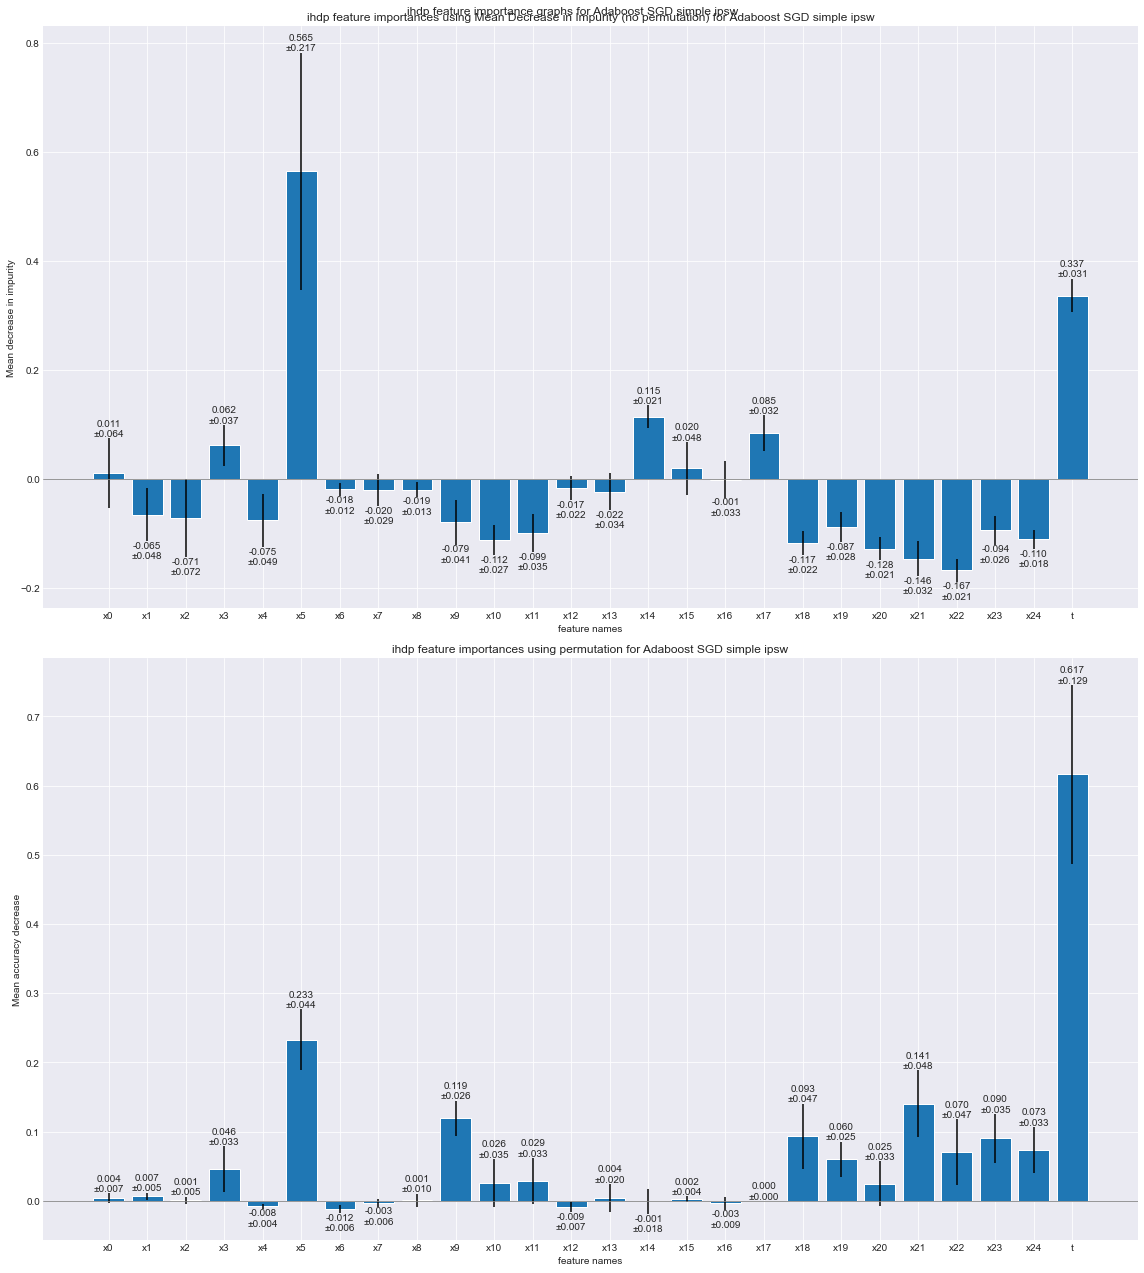

In [97]:
ada_sgd_simple_ipsw_best.importance_plotter().show()

Permutation explainer: 76it [00:17,  1.84it/s]                        


Saving SHAP figure to ihdp\ihdp SHAP values for Adaboost SGD simple ipsw.pdf...


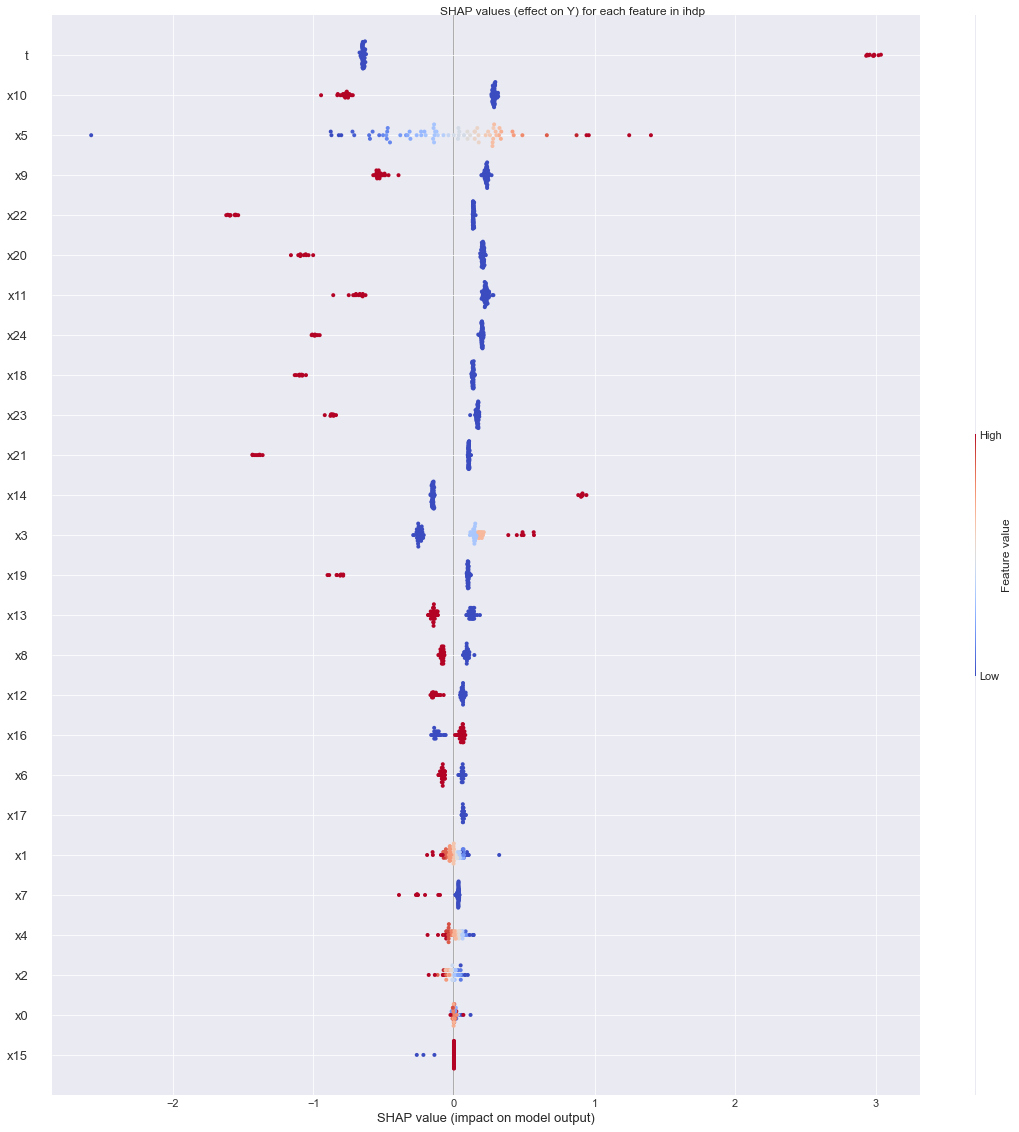

In [98]:
ada_sgd_simple_ipsw_best.shap_importance_plotter().show()

In [99]:
all_simple_ipsw_best: List[slearner.SimpleHalvingGridSearchResults] = [
    rf_simple_ipsw_best,
    ard_simple_ipsw_best,
    sgd_simple_ipsw_best,
    ada_rf_simple_ipsw_best,
    ada_ard_simple_ipsw_best,
    ada_sgd_simple_ipsw_best
]

all_simple_ipsw_best.sort(reverse=True)

In [100]:

for bc in all_simple_ipsw_best:
    print(bc.summary_info)

print("")

GridSearchResults summary Random Forest simple with IPSW ihdp
	test score:	0.7025444813007882
	train score:0.7283555982472381
	yf score:	0.7395090031744529
	ycf score:	0.6812144871945791
	t0 score:	0.5015229296143691
	t1 score:	-0.0017911736391860167
	ite score:	0.6985193472979756
	abs ATE:	0.04366266896597448
	PEHE:   	0.4717414496808599
	abs ATT:	0.11724985825270862
	p. risk:	-5.491525000452395
GridSearchResults summary Adaboost Random Forest simple with IPSW ihdp
	test score:	0.6874527684187223
	train score:0.7717375370449718
	yf score:	0.7949866672400211
	ycf score:	0.6874438521286699
	t0 score:	0.6006350067021621
	t1 score:	0.027300132322316095
	ite score:	0.5947668249136354
	abs ATE:	0.011366591926843306
	PEHE:   	0.5469237842457962
	abs ATT:	0.10211627901466658
	p. risk:	-5.466444278879323
GridSearchResults summary ARD simple with IPSW ihdp
	test score:	0.5564596977895747
	train score:0.7174340703816985
	yf score:	0.7230858128688201
	ycf score:	0.6696308622344906
	t0 score:	0.49

In [101]:
best_simple_ipsw_predictor: slearner.PPipeline = max(all_simple_ipsw_best).best_estimator_

In [102]:
best_simple_ipsw_predictor

PPipeline(steps=[('scaler', QuantileTransformer(output_distribution='normal')),
                 ('imputer', KNNImputer(weights='distance')),
                 ('estimator',
                  RandomForestRegressor(ccp_alpha=0.000246621207433047,
                                        max_features=None,
                                        min_impurity_decrease=0.15,
                                        min_samples_split=4,
                                        random_state=42))])

In [103]:
import dill
dill.dump_session(f"{os.getcwd()}\\{dataset}_env.pickle")

# 5: The CATE stuff

In [116]:
import dill
import os
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn import set_config

dataset = "ihdp"
dill.load_session(f"{os.getcwd()}\\{dataset}_env.pickle")



import matplotlib.style
if "seaborn-darkgrid" in matplotlib.style.available:
    matplotlib.style.use("seaborn-darkgrid")

%matplotlib inline

set_config(display="diagram")



In [117]:
from assignment2.a2_utils import econml_utils as ecutils

import econml


In [118]:
edfm: ecutils.EconDFM = ecutils.EconDFM.make(
    dfm=dfm,
    ipsw=ipsw_calc
)

ecutils.EconMLOutputs._edfm = edfm

In [124]:
%%time
causalForest_outputs: ecutils.EconMLOutputs = ecutils.EconMLOutputs.make_causal_forest(
    edfm=edfm,
    model_y=sklearn.base.clone(best_simple_est),
    model_t=sklearn.base.clone(best_ipsw_predictor)
)

print(causalForest_outputs.info)

Info for Causal Forest CATE estimator on ihdp:
	Error:  4.839652360851289 [mean squared error for XYTZ]
	PEHE:   2.4462813724881576	[Precision in Estimation of Heterogeneous treatment Effect]
	ATE:    2.2685069519544845	[Absolute error for Average Treatment Effect]
	ATT:    1.5287379909826944	[Absolute error for Average Treatment effect on the Treated]
	P. Risk:-4.791562087022146	[Policy Risk]
CPU times: total: 5.55 s
Wall time: 5.53 s


SHAP feature importances for the causal forest DML


 99%|===================| 736/747 [00:34<00:00]        

Saving SHAP figure to ihdp\ihdp SHAP values for Causal Forest.pdf...


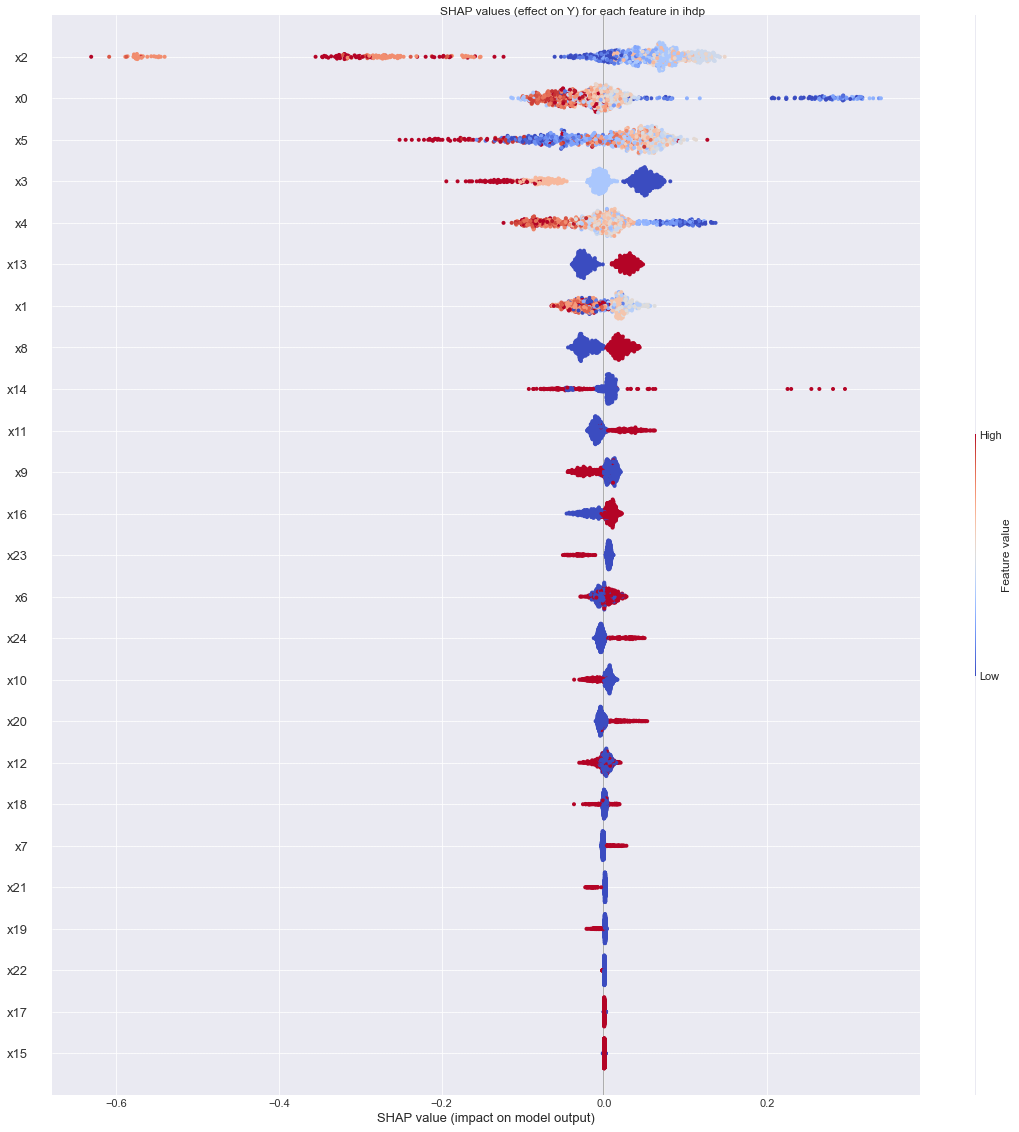

In [125]:
print("SHAP feature importances for the causal forest DML")
causalForest_outputs.shap_plot().show()

Tree-based visualization of the causal forest DML CATE
Exported via matplotlib to ihdp\Causal Forest CATE tree.pdf!
CPU times: total: 4.88 s
Wall time: 5.48 s


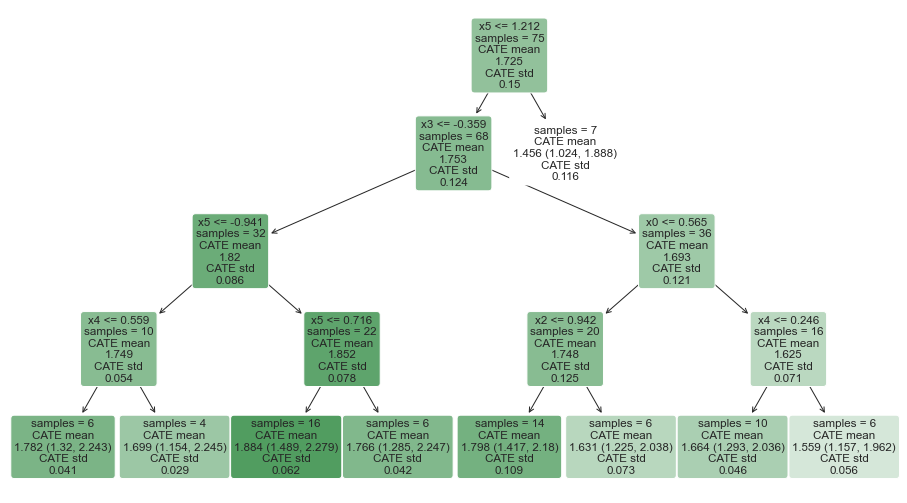

In [127]:
%%time
print("Tree-based visualization of the causal forest DML CATE")
causalForest_outputs.plot_tree(
    causalForest_outputs.cate_tree(),
    True
).show()

Tree-based visualization of the causal forest DML treatment policy
Exported via matplotlib to ihdp\Causal Forest policy tree.pdf!
CPU times: total: 2.88 s
Wall time: 3.25 s


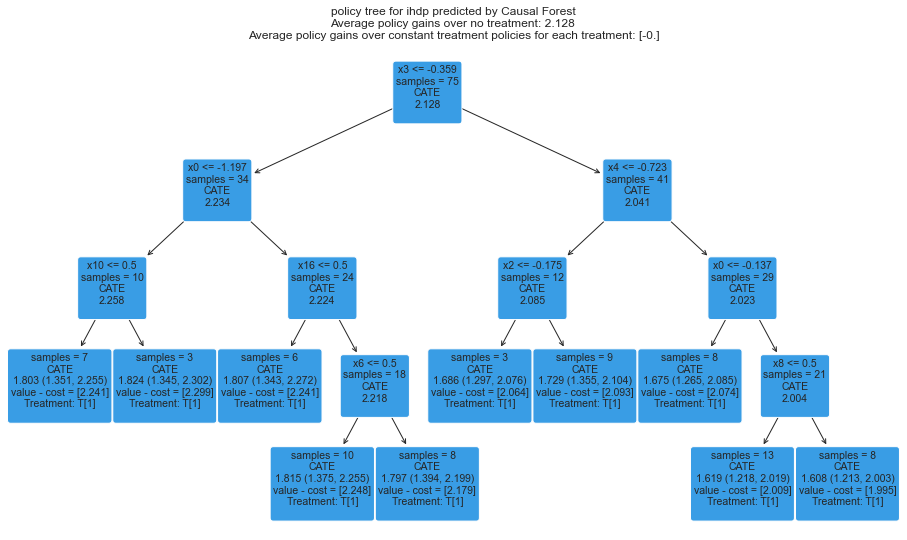

In [126]:
%%time
print("Tree-based visualization of the causal forest DML treatment policy")
causalForest_outputs.plot_tree(
    causalForest_outputs.policy_tree(),
    False
).show()

In [128]:
causalForest_outputs.save_me()

saving self to ihdp\Causal Forest CATE.pickle!
Saved!


In [129]:
%%time
forestDR_outputs: ecutils.EconMLOutputs = ecutils.EconMLOutputs.make_ForestDR(
    edfm=edfm,
    model_regression=sklearn.base.clone(best_simple_est),
    model_propensity=sklearn.base.clone(best_ipsw_predictor)
)

print(forestDR_outputs.info)

Info for Forest DR Learner CATE estimator on ihdp:
	Error:  522472614698.89197 [mean squared error for XYTZ]
	PEHE:   68332.93913561162	[Precision in Estimation of Heterogeneous treatment Effect]
	ATE:    50577.481264132	[Absolute error for Average Treatment Effect]
	ATT:    66231.3594777289	[Absolute error for Average Treatment effect on the Treated]
	P. Risk:-4.356885899715489	[Policy Risk]
CPU times: total: 7min 4s
Wall time: 5min 29s


SHAP feature importances for the double-robust forest


 99%|===================| 740/747 [00:30<00:00]        

Saving SHAP figure to ihdp\ihdp SHAP values for Forest DR Learner.pdf...


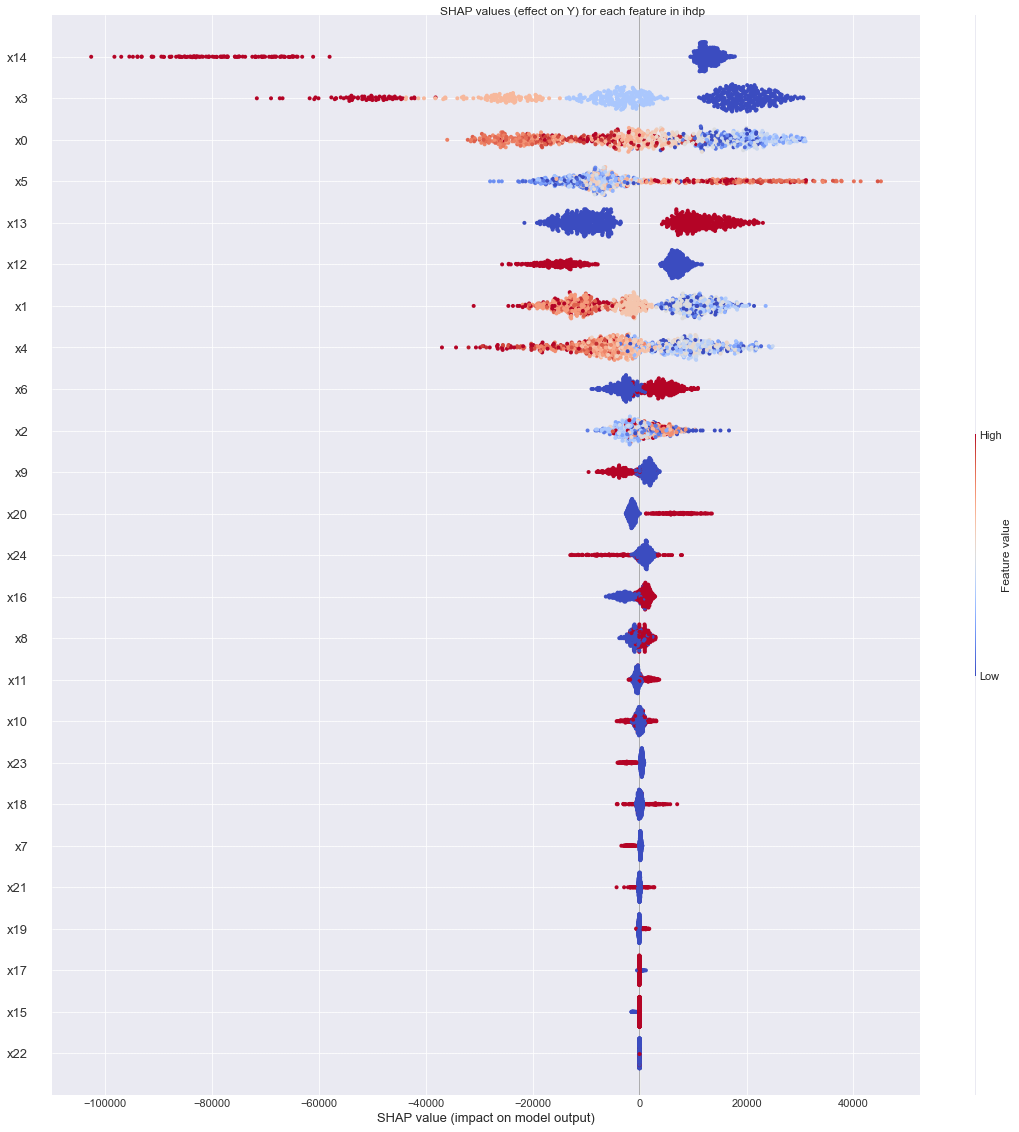

In [130]:
print("SHAP feature importances for the double-robust forest")
forestDR_outputs.shap_plot().show()

Tree-based visualization of the double-robust forest CATE
Exported via matplotlib to ihdp\Forest DR Learner CATE tree.pdf!
CPU times: total: 1min 30s
Wall time: 1min 22s


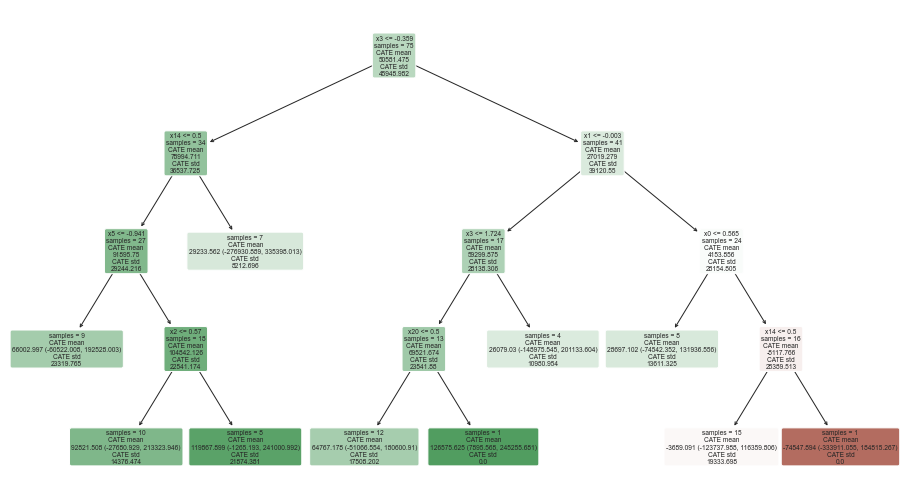

In [131]:
%%time
print("Tree-based visualization of the double-robust forest CATE")
forestDR_outputs.plot_tree(
    forestDR_outputs.cate_tree(),
    True
).show()

Tree-based visualization of the double-robust forest treatment policy
Exported via matplotlib to ihdp\Forest DR Learner policy tree.pdf!
CPU times: total: 1min 2s
Wall time: 58.5 s


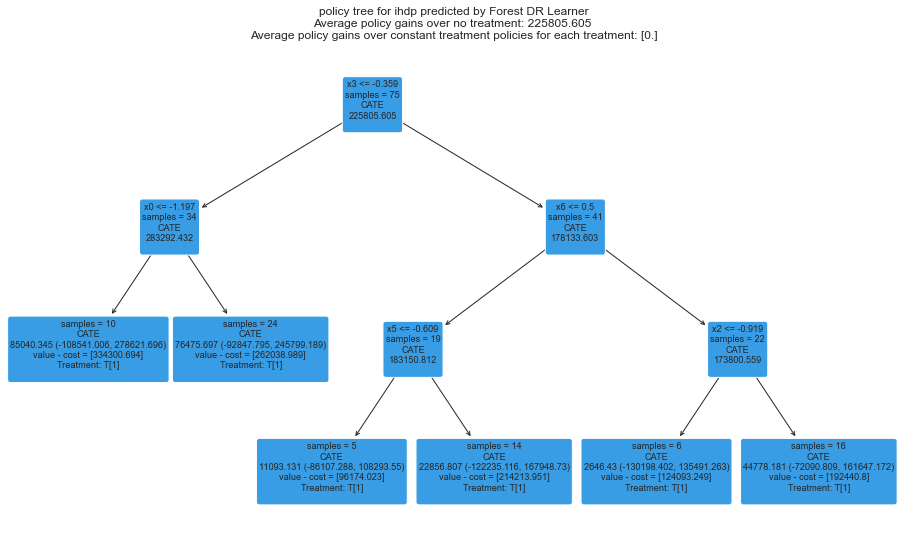

In [132]:
%%time
print("Tree-based visualization of the double-robust forest treatment policy")
forestDR_outputs.plot_tree(
    forestDR_outputs.policy_tree(),
    False
).show()

In [133]:
forestDR_outputs.save_me()

saving self to ihdp\Forest DR Learner CATE.pickle!
Saved!


In [134]:
DMLIV_outputs: ecutils.EconMLOutputs = ecutils.EconMLOutputs.make_DMLIV(
    edfm=edfm,
    model_y_xw=sklearn.base.clone(best_simple_ipsw_predictor)
)

print(DMLIV_outputs.info)

Info for DMLIV CATE estimator on ihdp:
	Error:  9.689662688713984 [mean squared error for XYTZ]
	PEHE:   4.126739926970496	[Precision in Estimation of Heterogeneous treatment Effect]
	ATE:    3.977145077377184	[Absolute error for Average Treatment Effect]
	ATT:    3.2768306884924105	[Absolute error for Average Treatment effect on the Treated]
	P. Risk:-3.262556176949431	[Policy Risk]


SHAP feature importances for the DMLIV
Saving SHAP figure to ihdp\ihdp SHAP values for DMLIV.pdf...
CPU times: total: 578 ms
Wall time: 626 ms


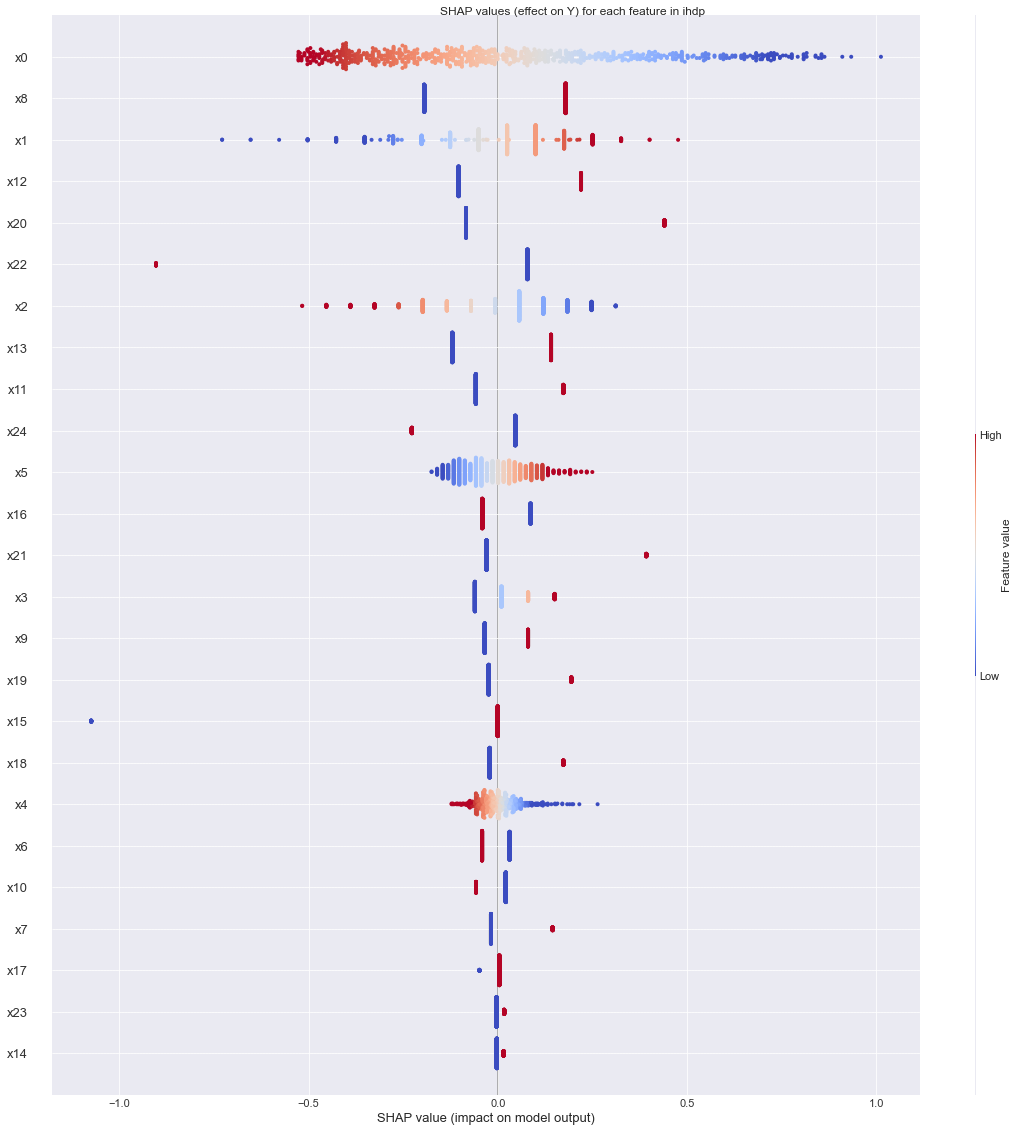

In [135]:
%%time
print("SHAP feature importances for the DMLIV")
DMLIV_outputs.shap_plot().show()

Tree-based visualization of the DMLIV CATE
Exported via matplotlib to ihdp\DMLIV CATE tree.pdf!
CPU times: total: 1.08 s
Wall time: 1.07 s


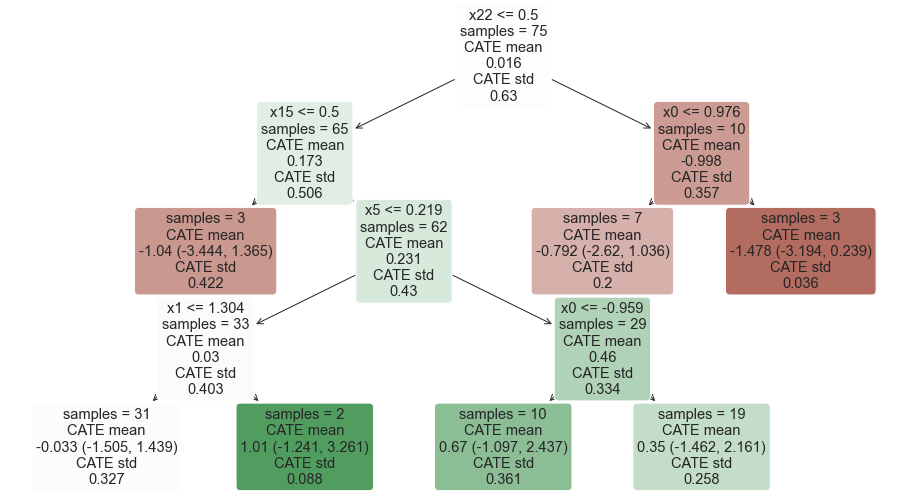

In [136]:
%%time
print("Tree-based visualization of the DMLIV CATE")
DMLIV_outputs.plot_tree(
    DMLIV_outputs.cate_tree(),
    True
).show()

Tree-based visualization of the DMLIV treatment policy
Exported via matplotlib to ihdp\DMLIV policy tree.pdf!
CPU times: total: 984 ms
Wall time: 1.1 s


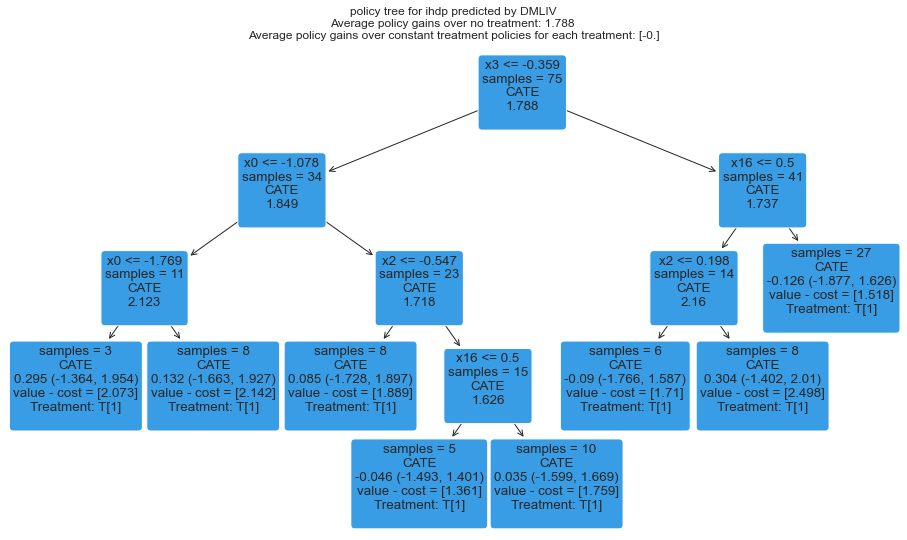

In [137]:
%%time
print("Tree-based visualization of the DMLIV treatment policy")
DMLIV_outputs.plot_tree(
    DMLIV_outputs.policy_tree(),
    False
).show()

In [138]:
DMLIV_outputs.save_me()

saving self to ihdp\DMLIV CATE.pickle!
Saved!


In [139]:
%%time
ForestDRIV_outputs: ecutils.EconMLOutputs = ecutils.EconMLOutputs.make_ForestDRIV(
    edfm=edfm,
    model_y_xw=sklearn.base.clone(best_simple_ipsw_predictor),
    model_z_xw="auto"
)
print(ForestDRIV_outputs.info)

Info for ForestDRIV CATE estimator on ihdp:
	Error:  0.0 [mean squared error for XYTZ]
	PEHE:   4.094484421057884	[Precision in Estimation of Heterogeneous treatment Effect]
	ATE:    3.9936436610020816	[Absolute error for Average Treatment Effect]
	ATT:    3.3150458586464495	[Absolute error for Average Treatment effect on the Treated]
	P. Risk:-1.4765162283756963	[Policy Risk]
CPU times: total: 38min 30s
Wall time: 16min 28s


SHAP feature importances for the ForestDRIV


 99%|===================| 739/747 [00:47<00:00]        

Saving SHAP figure to ihdp\ihdp SHAP values for ForestDRIV.pdf...
CPU times: total: 32.9 s
Wall time: 48.9 s


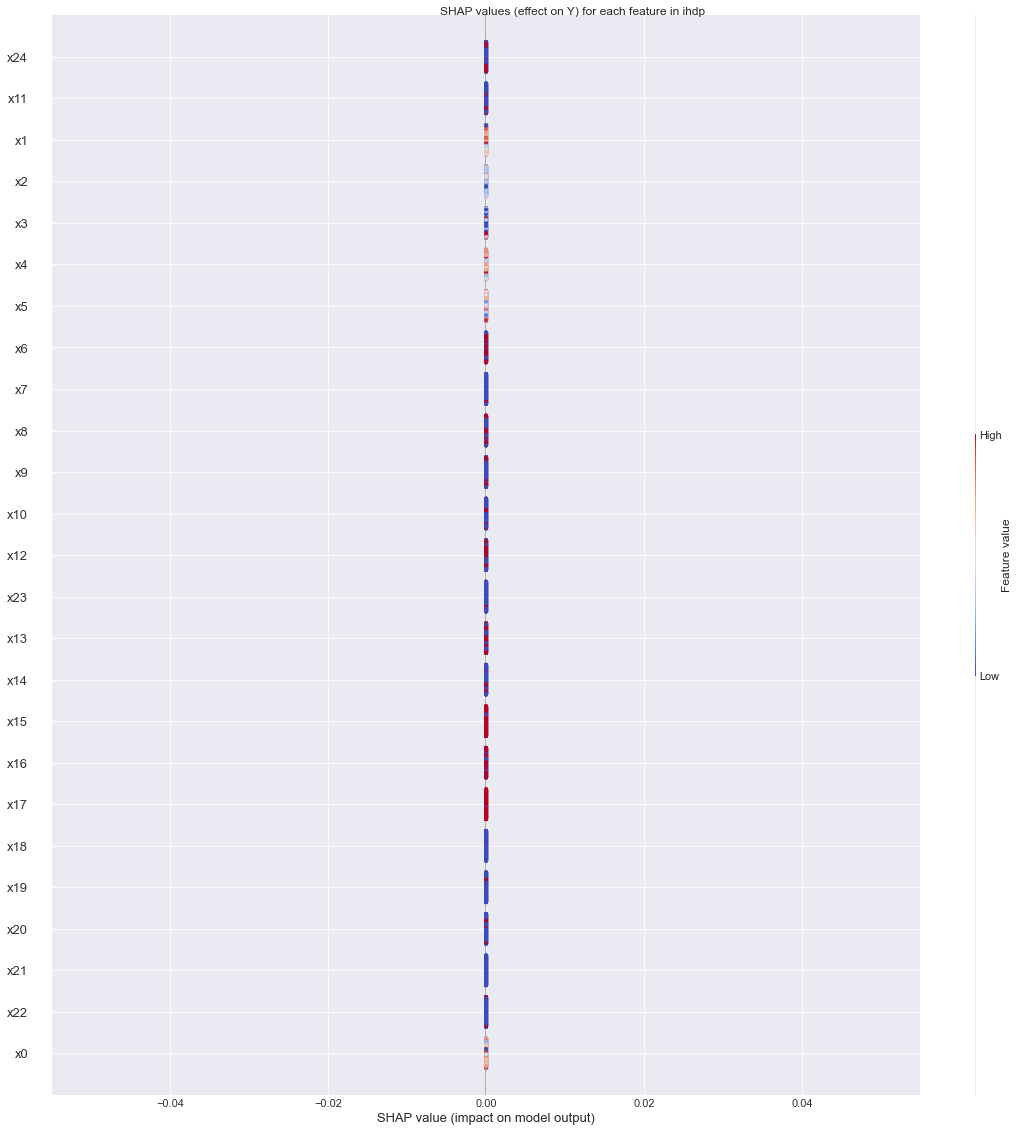

In [140]:
%%time
print("SHAP feature importances for the ForestDRIV")
ForestDRIV_outputs.shap_plot().show()

Tree-based visualization of the ForestDRIV CATE
Exported via matplotlib to ihdp\ForestDRIV CATE tree.pdf!
CPU times: total: 11.4 s
Wall time: 12.2 s


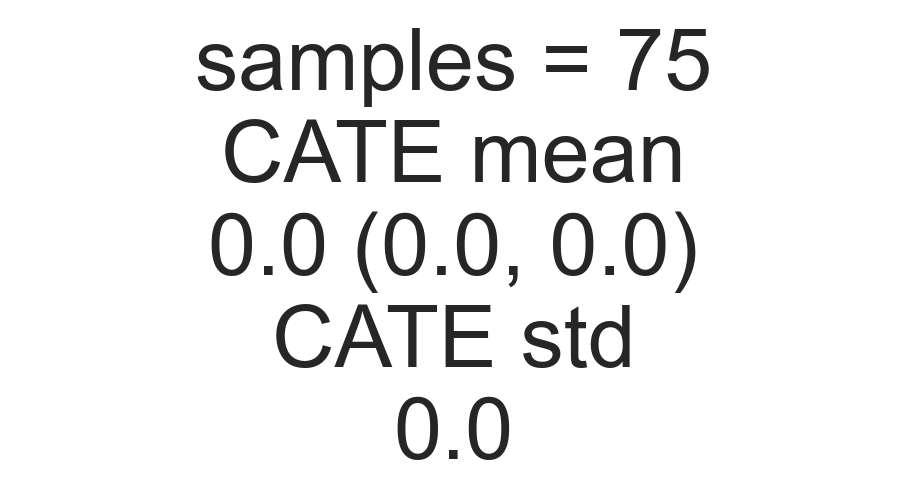

In [141]:
%%time
print("Tree-based visualization of the ForestDRIV CATE")
ForestDRIV_outputs.plot_tree(
    ForestDRIV_outputs.cate_tree(),
    True
).show()

Tree-based visualization of the ForestDRIV treatment policy
Exported via matplotlib to ihdp\ForestDRIV policy tree.pdf!
CPU times: total: 1min 58s
Wall time: 2min 13s


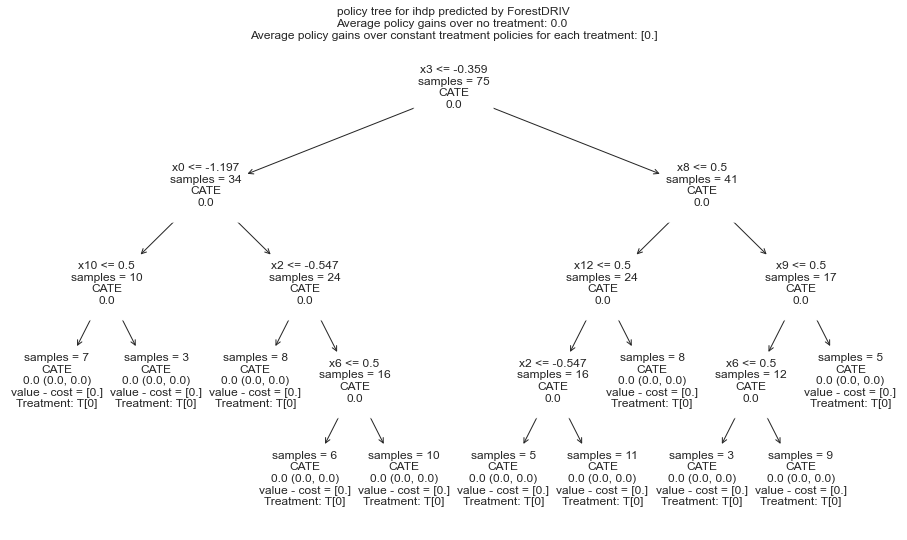

In [142]:
%%time
print("Tree-based visualization of the ForestDRIV treatment policy")
ForestDRIV_outputs.plot_tree(
    ForestDRIV_outputs.policy_tree(),
    False
).show()

In [143]:
ForestDRIV_outputs.save_me()

saving self to ihdp\ForestDRIV CATE.pickle!
Saved!


In [144]:
all_cate: List[ecutils.EconMLOutputs] = [
    causalForest_outputs,
    forestDR_outputs,
    DMLIV_outputs,
    ForestDRIV_outputs
]

all_cate.sort(reverse=True)

for eco in all_cate:
    print(eco.info)
    print("")


Info for Causal Forest CATE estimator on ihdp:
	Error:  4.839652360851289 [mean squared error for XYTZ]
	PEHE:   2.4462813724881576	[Precision in Estimation of Heterogeneous treatment Effect]
	ATE:    2.2685069519544845	[Absolute error for Average Treatment Effect]
	ATT:    1.5287379909826944	[Absolute error for Average Treatment effect on the Treated]
	P. Risk:-4.791562087022146	[Policy Risk]

Info for ForestDRIV CATE estimator on ihdp:
	Error:  0.0 [mean squared error for XYTZ]
	PEHE:   4.094484421057884	[Precision in Estimation of Heterogeneous treatment Effect]
	ATE:    3.9936436610020816	[Absolute error for Average Treatment Effect]
	ATT:    3.3150458586464495	[Absolute error for Average Treatment effect on the Treated]
	P. Risk:-1.4765162283756963	[Policy Risk]

Info for DMLIV CATE estimator on ihdp:
	Error:  9.689662688713984 [mean squared error for XYTZ]
	PEHE:   4.126739926970496	[Precision in Estimation of Heterogeneous treatment Effect]
	ATE:    3.977145077377184	[Absolute e

In [145]:
best_cate: ecutils.EconMLOutputs = max(all_cate)

print(f"The best CATE estimator is {best_cate.learner_name}")

The best CATE estimator is Causal Forest


In [147]:
dill.dump_session(f"{os.getcwd()}\\{dataset}_env.pickle")

ValueError: ctypes objects containing pointers cannot be pickled